In [1]:
import torch
from torch import nn,optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from utils import Logger

In [2]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
        #  transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        transforms.Normalize([0.5],[0.5])
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [3]:
def ss_data(flag='train'):
    if flag == 'train':
        return torch.load('../dataloader_32_train.pt')
    elif flag == 'test':
        return torch.load('../dataloader_32_test.pt')
    else:
        raise NameError("No such data loader")
train_dataloader = ss_data()
num_batches_train = len(train_dataloader)
test_dataloader = ss_data('test')
num_batches_test = len(test_dataloader)

In [4]:
def temper_data(flag="train"):
    if flag == 'train':
        return torch.load('../dataloader_temp_train2.pt')
    elif flag == 'test':
        return torch.load('../dataloader_temp_test2.pt')
    else:
        raise NameError('No such data loader')
train_dataloader = temper_data()
num_batches_train = len(train_dataloader)
test_dataloader = temper_data('test')
num_batches_test = len(test_dataloader)

In [5]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 19*7
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [6]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 22, 28)

In [7]:
print(19*7)

133


In [8]:
def images_to_vectors(images):
    return images.view(images.size(0),133)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 19, 7)

In [9]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 133
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [10]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100,dtype=torch.float32))
    return n


In [11]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [12]:
loss = nn.BCELoss()

In [13]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1,dtype=torch.float32))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1,dtype=torch.float32))
    return data

In [14]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [15]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [16]:
num_test_samples = 16
test_noise = noise(num_test_samples)

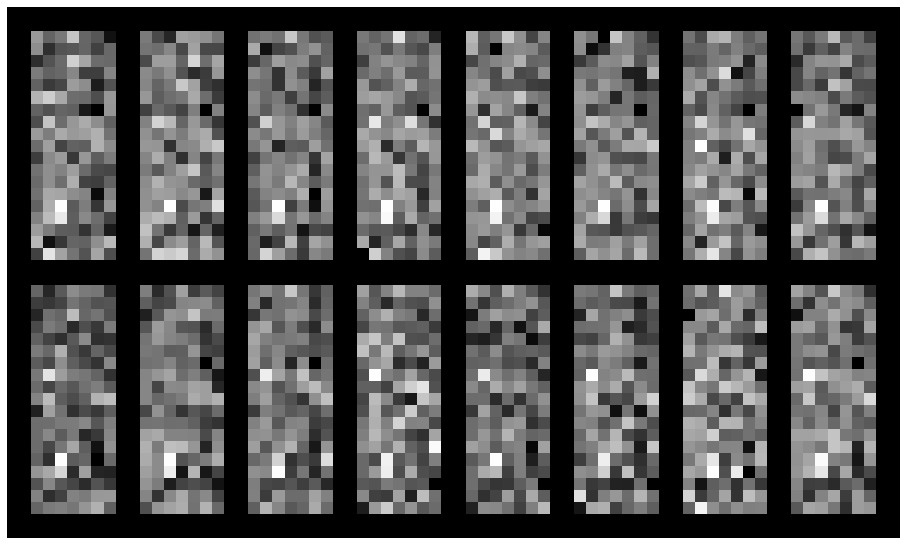

Epoch: [0/200], Batch Num: [0/54]
Discriminator Loss: 1.3030, Generator Loss: 0.6899
D(x): 0.5497, D(G(z)): 0.4993


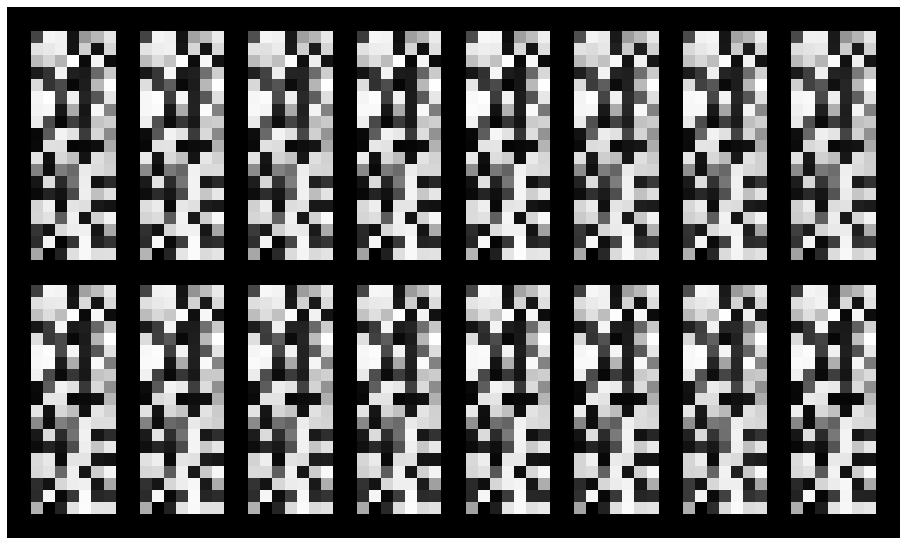

Epoch: [1/200], Batch Num: [0/54]
Discriminator Loss: 0.6337, Generator Loss: 1.2060
D(x): 0.8983, D(G(z)): 0.3883


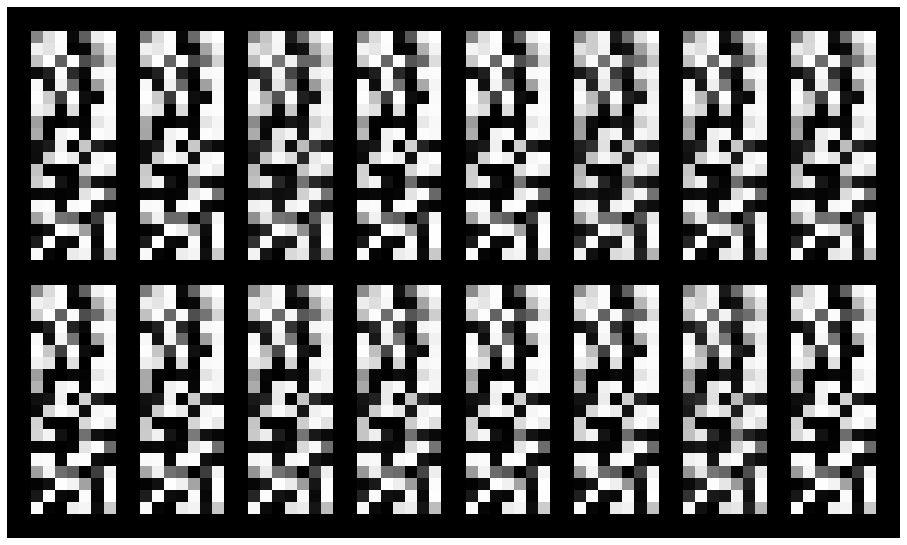

Epoch: [2/200], Batch Num: [0/54]
Discriminator Loss: 0.0857, Generator Loss: 4.1111
D(x): 0.9630, D(G(z)): 0.0261


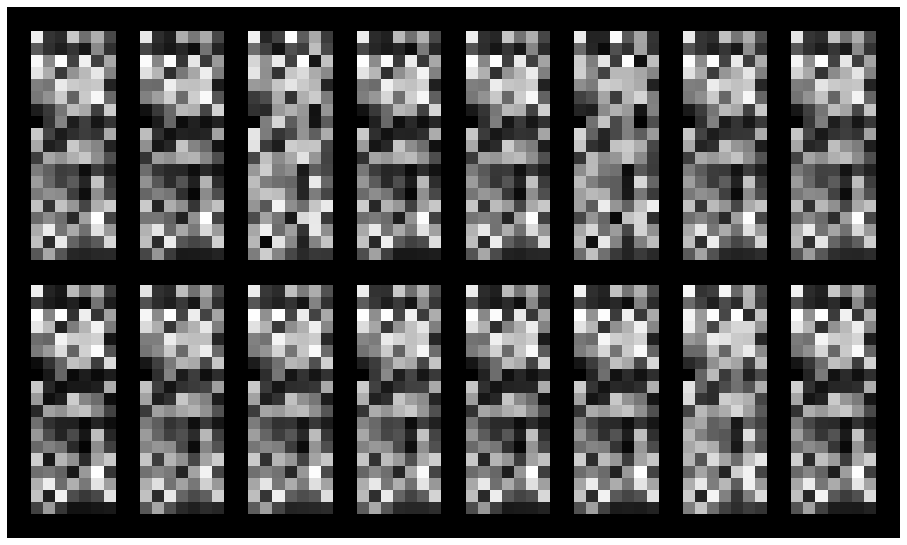

Epoch: [3/200], Batch Num: [0/54]
Discriminator Loss: 0.2541, Generator Loss: 2.2496
D(x): 0.9491, D(G(z)): 0.1401


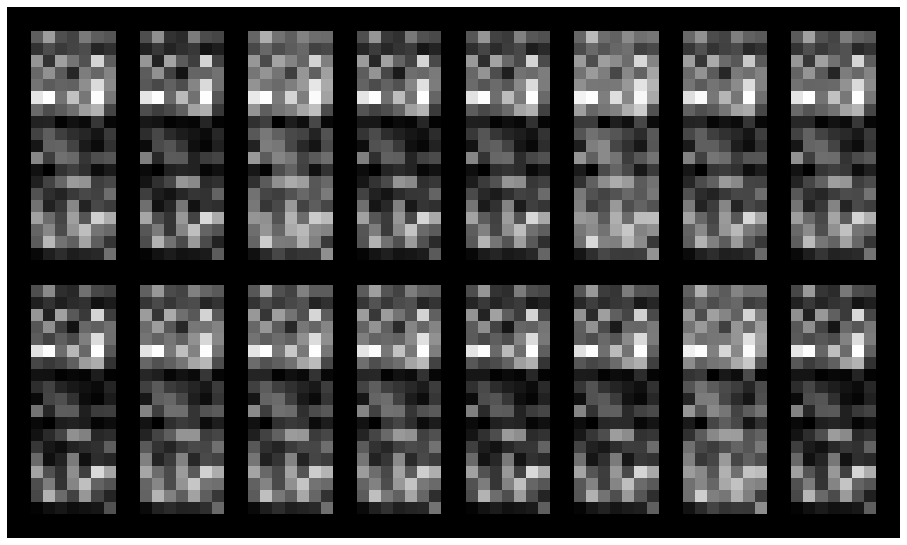

Epoch: [4/200], Batch Num: [0/54]
Discriminator Loss: 0.1912, Generator Loss: 3.6170
D(x): 0.9386, D(G(z)): 0.0412


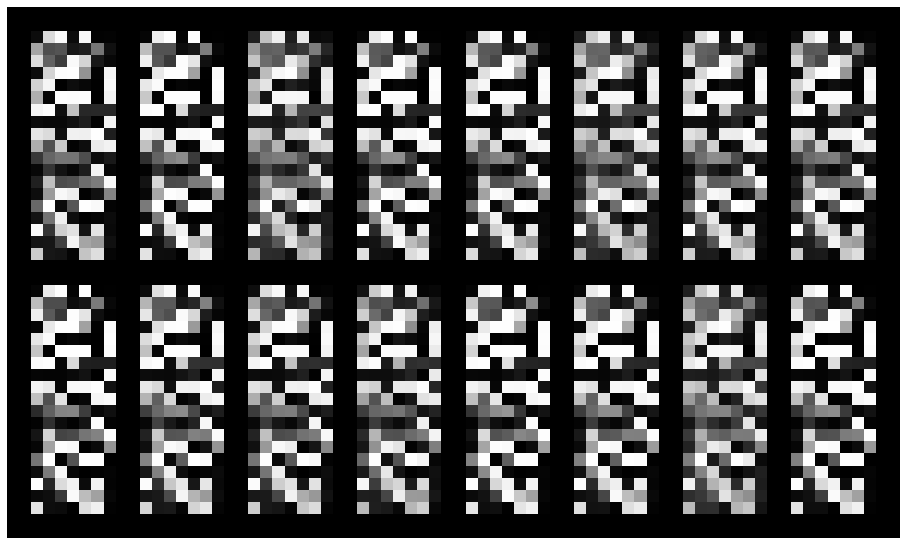

Epoch: [5/200], Batch Num: [0/54]
Discriminator Loss: 0.1476, Generator Loss: 5.0221
D(x): 0.9889, D(G(z)): 0.1058


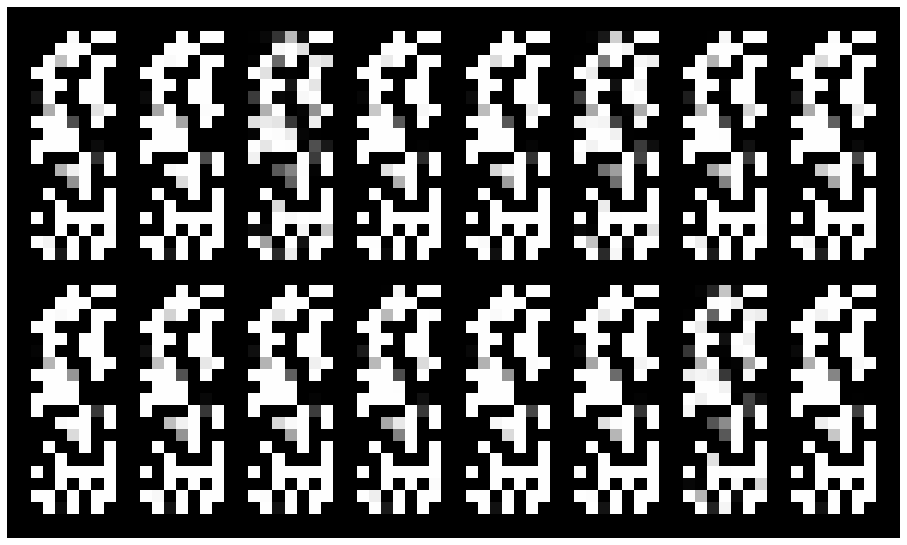

Epoch: [6/200], Batch Num: [0/54]
Discriminator Loss: 0.1013, Generator Loss: 5.3550
D(x): 0.9723, D(G(z)): 0.0345


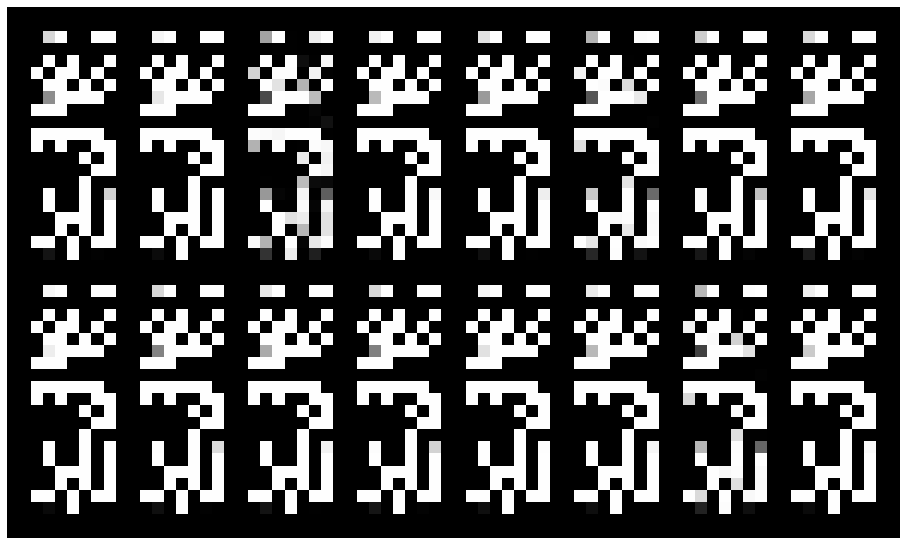

Epoch: [7/200], Batch Num: [0/54]
Discriminator Loss: 0.0387, Generator Loss: 9.4980
D(x): 0.9851, D(G(z)): 0.0005


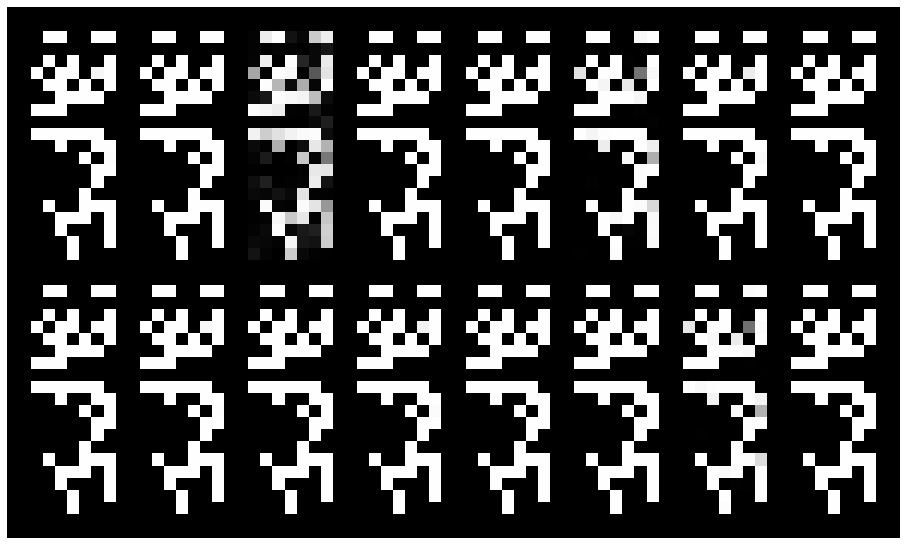

Epoch: [8/200], Batch Num: [0/54]
Discriminator Loss: 0.0054, Generator Loss: 7.3663
D(x): 0.9976, D(G(z)): 0.0028


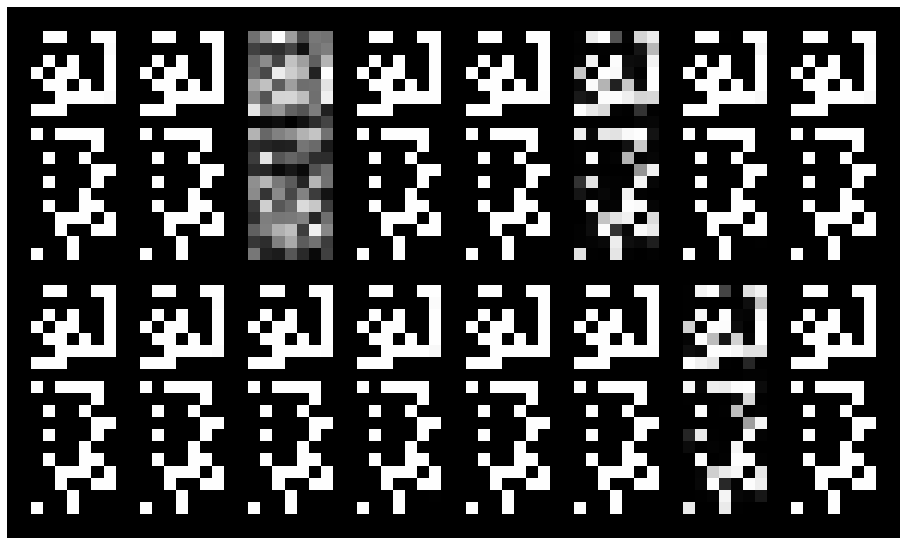

Epoch: [9/200], Batch Num: [0/54]
Discriminator Loss: 0.0213, Generator Loss: 7.1267
D(x): 0.9934, D(G(z)): 0.0069


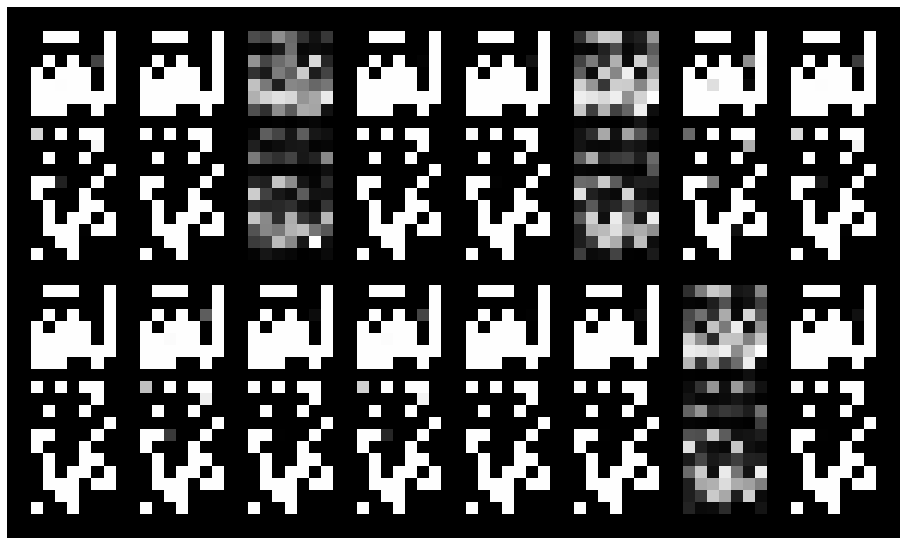

Epoch: [10/200], Batch Num: [0/54]
Discriminator Loss: 0.0348, Generator Loss: 7.7996
D(x): 0.9907, D(G(z)): 0.0181


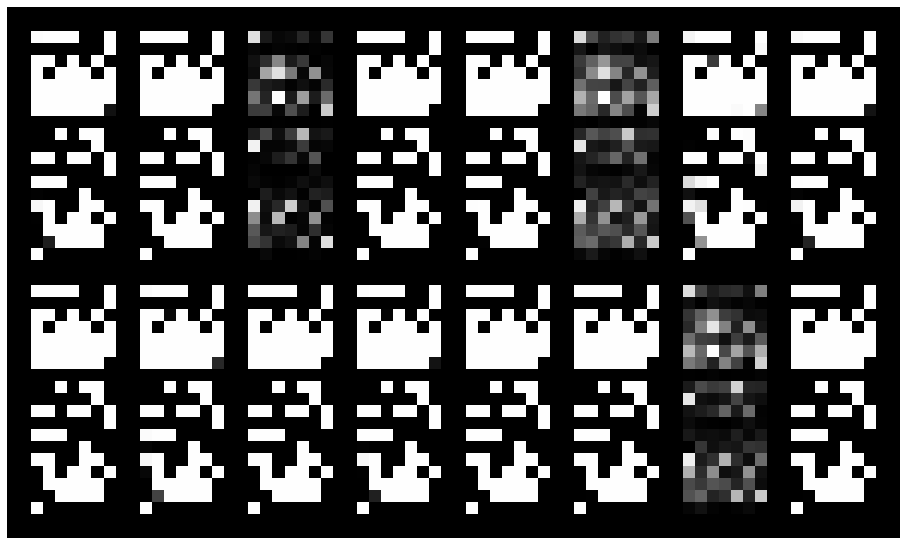

Epoch: [11/200], Batch Num: [0/54]
Discriminator Loss: 0.0307, Generator Loss: 6.6142
D(x): 0.9936, D(G(z)): 0.0122


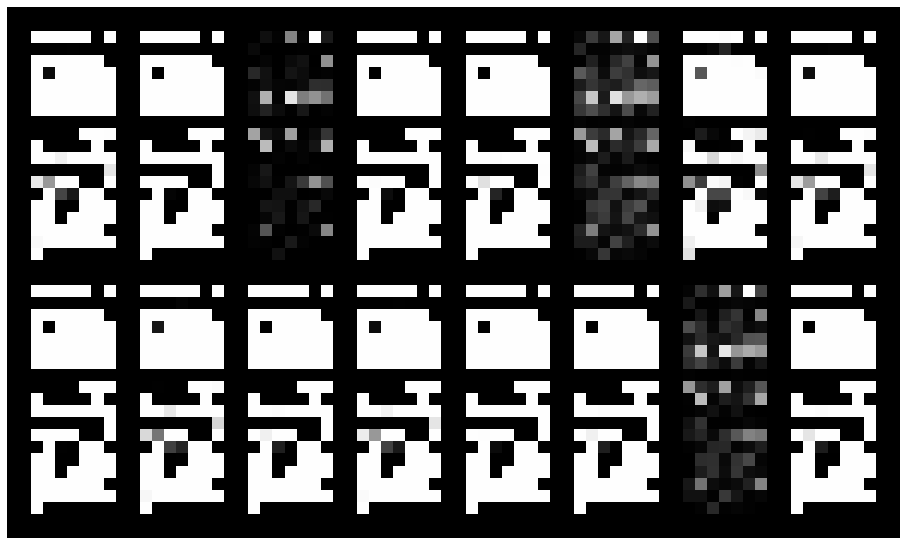

Epoch: [12/200], Batch Num: [0/54]
Discriminator Loss: 0.0878, Generator Loss: 4.8315
D(x): 0.9889, D(G(z)): 0.0499


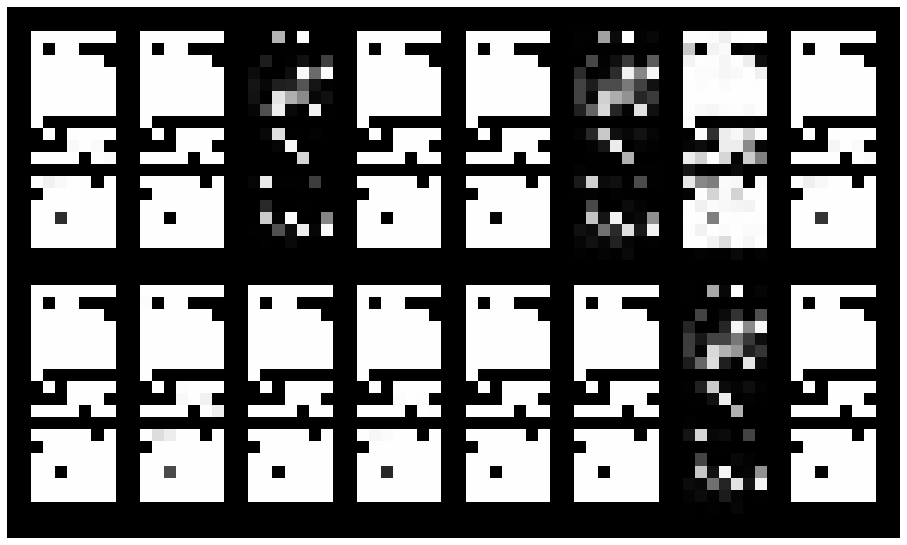

Epoch: [13/200], Batch Num: [0/54]
Discriminator Loss: 0.0317, Generator Loss: 6.2768
D(x): 0.9906, D(G(z)): 0.0120


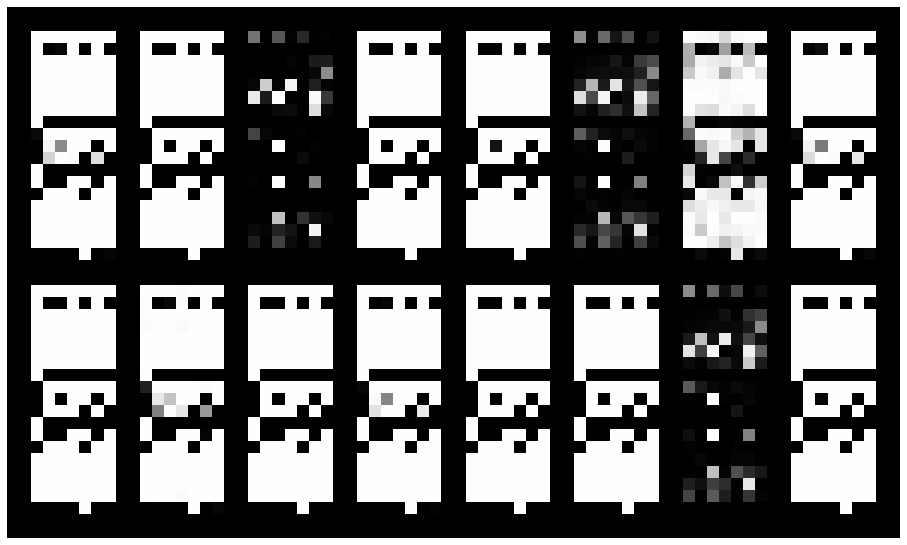

Epoch: [14/200], Batch Num: [0/54]
Discriminator Loss: 0.0677, Generator Loss: 6.6332
D(x): 0.9784, D(G(z)): 0.0154


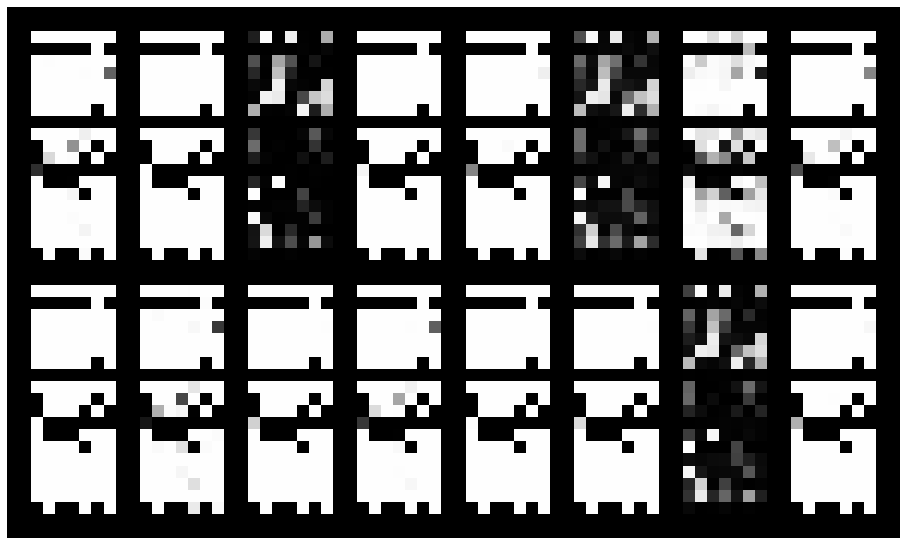

Epoch: [15/200], Batch Num: [0/54]
Discriminator Loss: 0.0202, Generator Loss: 7.2145
D(x): 0.9923, D(G(z)): 0.0076


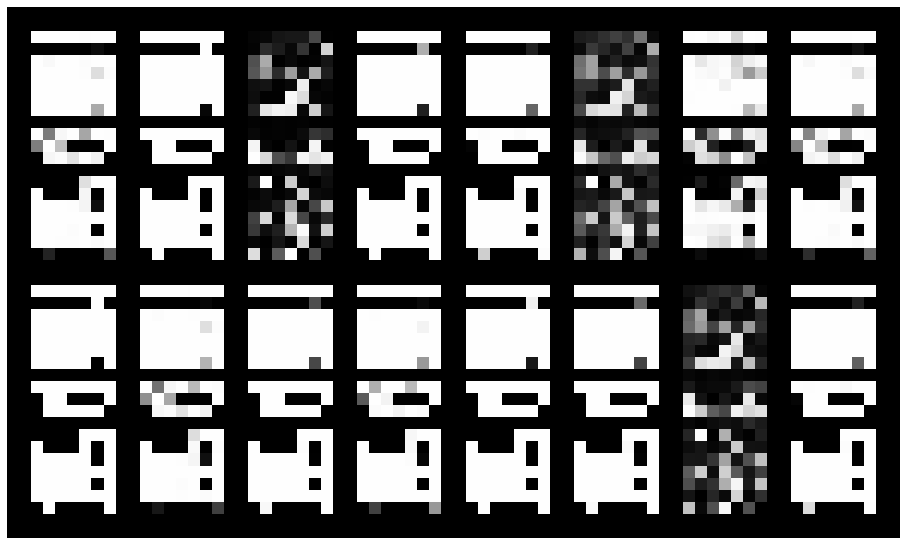

Epoch: [16/200], Batch Num: [0/54]
Discriminator Loss: 0.0271, Generator Loss: 7.6527
D(x): 0.9895, D(G(z)): 0.0101


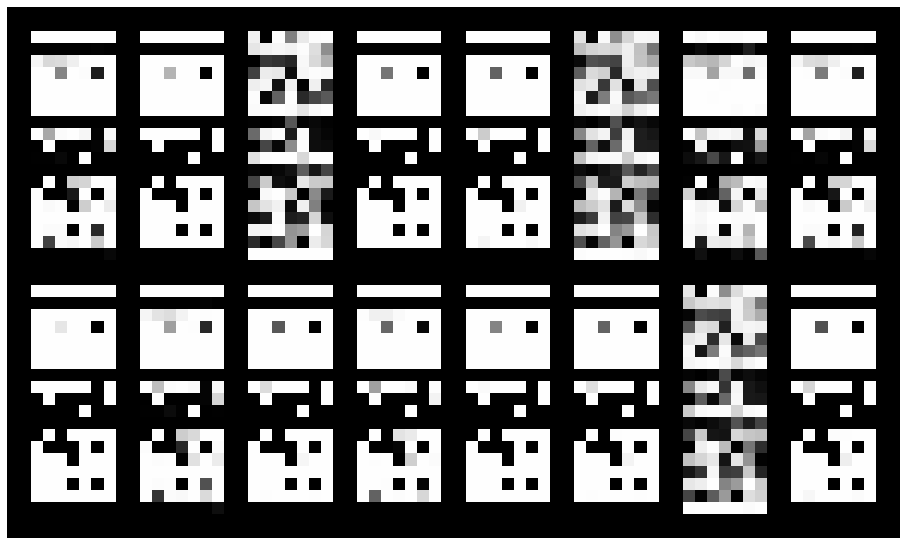

Epoch: [17/200], Batch Num: [0/54]
Discriminator Loss: 0.0642, Generator Loss: 7.8483
D(x): 0.9822, D(G(z)): 0.0137


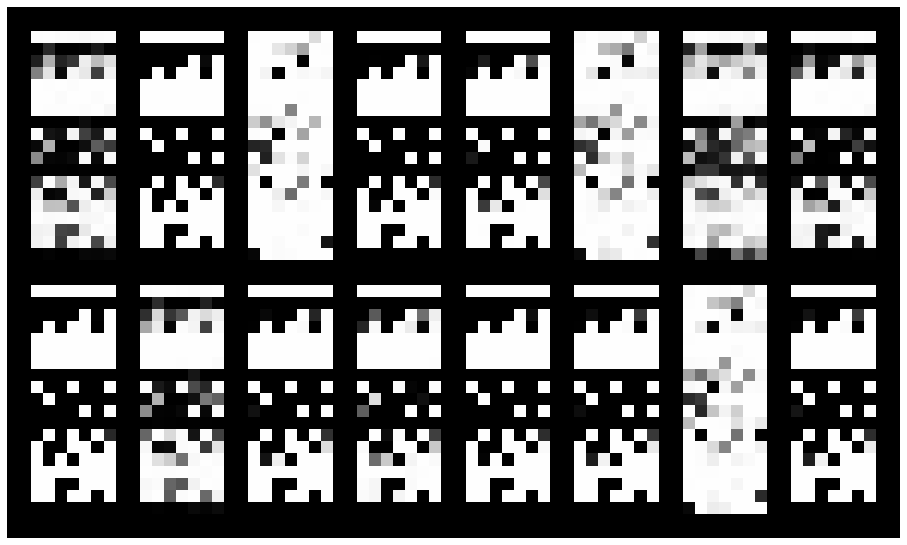

Epoch: [18/200], Batch Num: [0/54]
Discriminator Loss: 0.0476, Generator Loss: 7.7208
D(x): 0.9961, D(G(z)): 0.0304


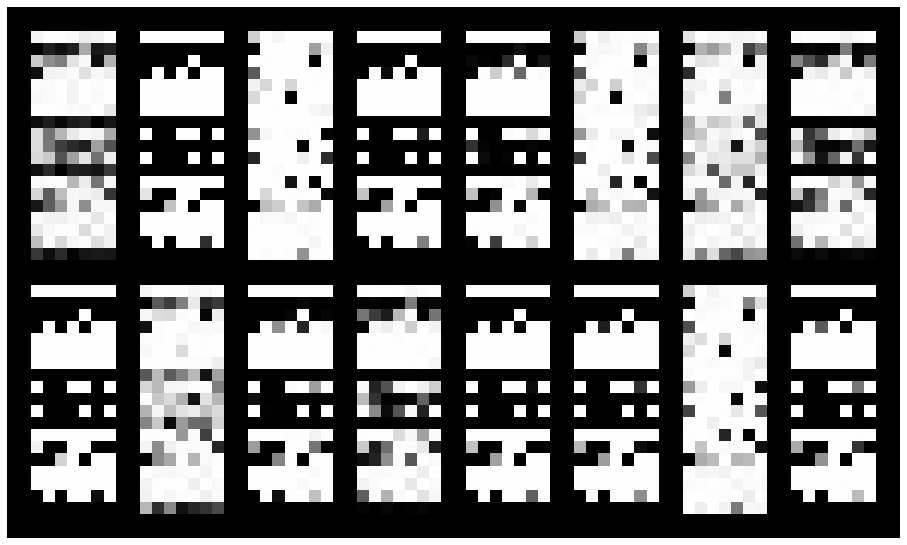

Epoch: [19/200], Batch Num: [0/54]
Discriminator Loss: 0.0631, Generator Loss: 8.5649
D(x): 0.9965, D(G(z)): 0.0369


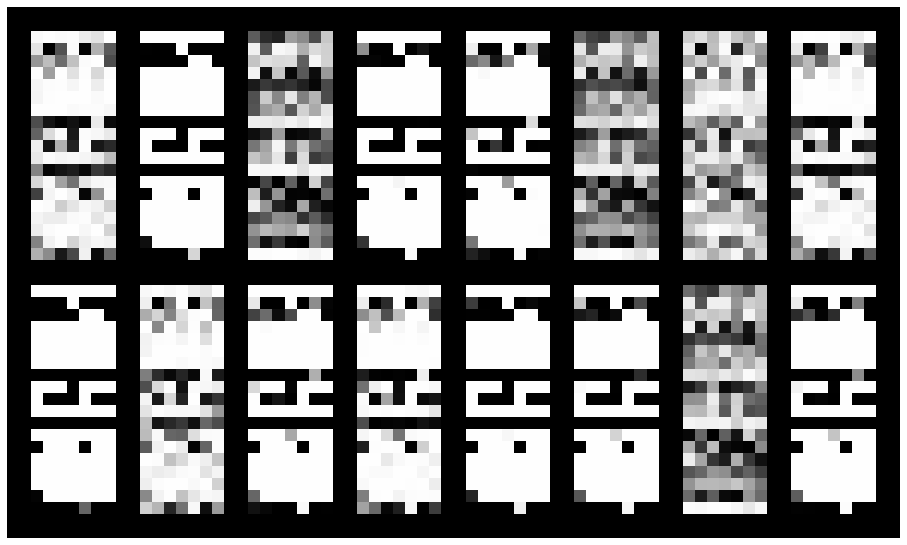

Epoch: [20/200], Batch Num: [0/54]
Discriminator Loss: 0.0198, Generator Loss: 6.5691
D(x): 0.9945, D(G(z)): 0.0102


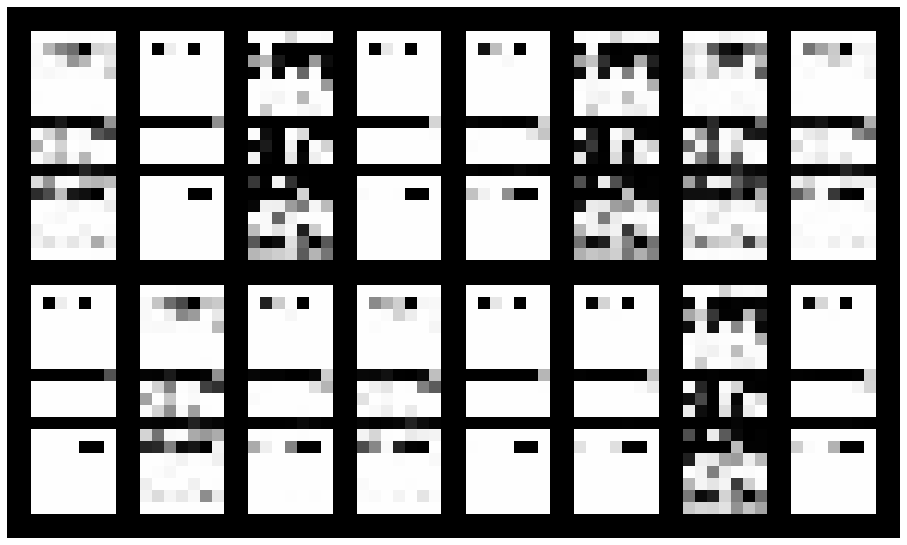

Epoch: [21/200], Batch Num: [0/54]
Discriminator Loss: 0.0567, Generator Loss: 7.6457
D(x): 0.9865, D(G(z)): 0.0077


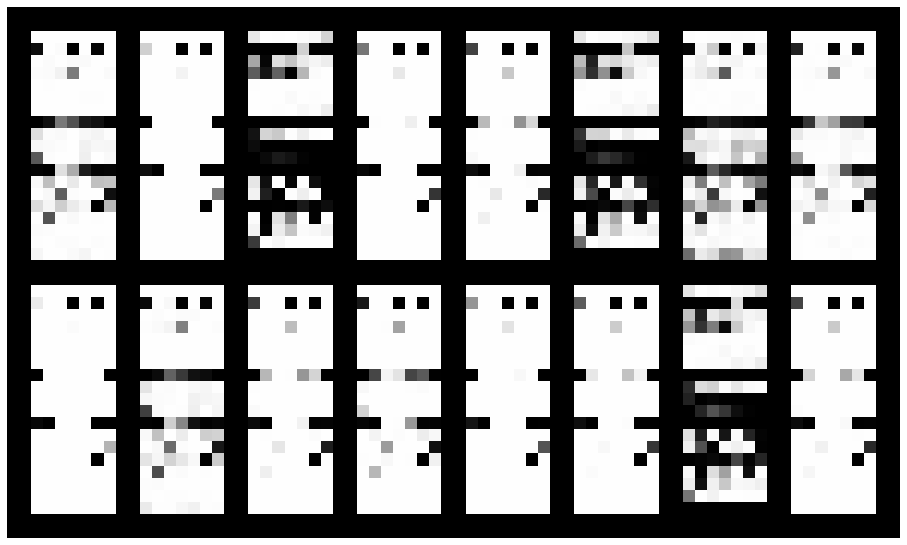

Epoch: [22/200], Batch Num: [0/54]
Discriminator Loss: 0.0389, Generator Loss: 7.4499
D(x): 0.9967, D(G(z)): 0.0211


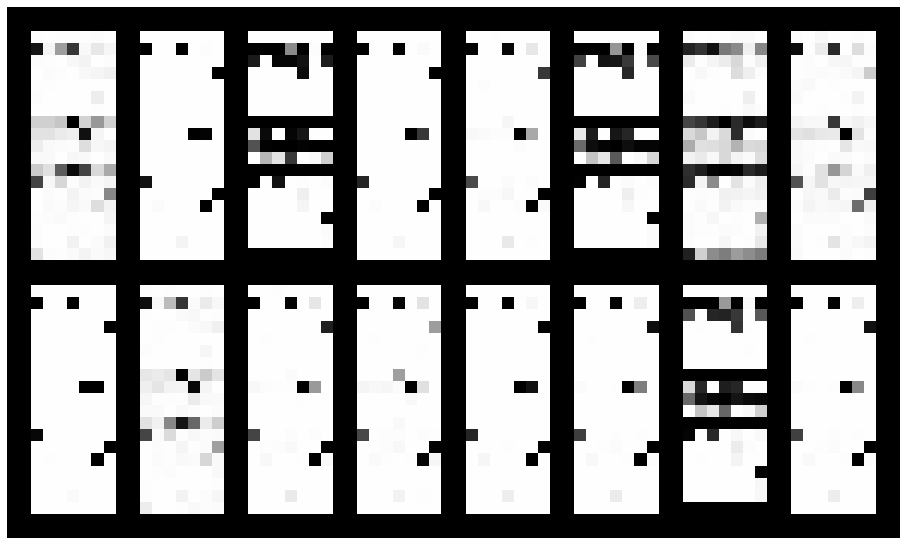

Epoch: [23/200], Batch Num: [0/54]
Discriminator Loss: 0.0304, Generator Loss: 7.2503
D(x): 0.9918, D(G(z)): 0.0120


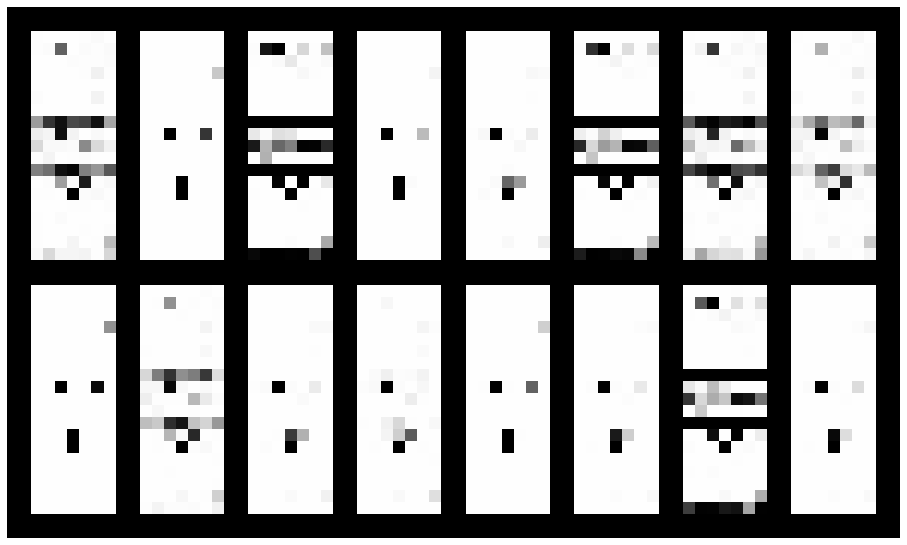

Epoch: [24/200], Batch Num: [0/54]
Discriminator Loss: 0.0138, Generator Loss: 7.8433
D(x): 0.9966, D(G(z)): 0.0051


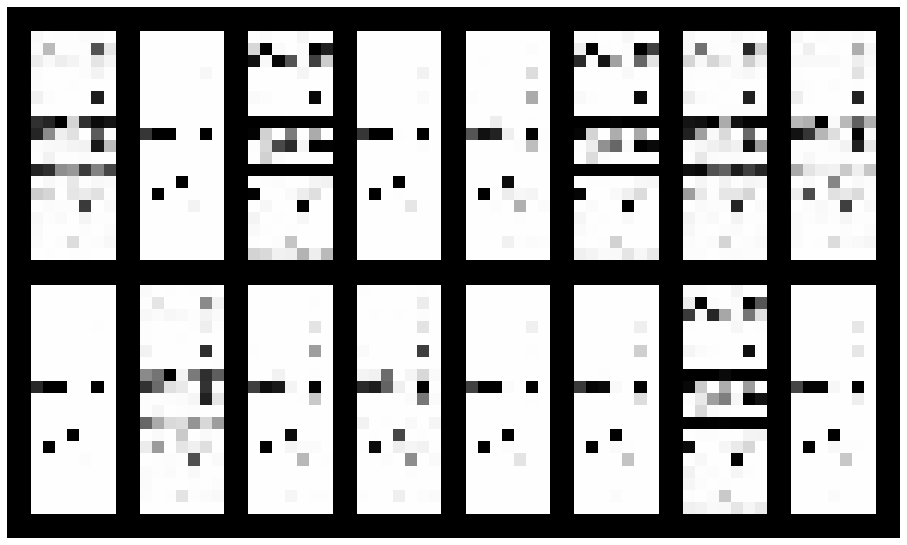

Epoch: [25/200], Batch Num: [0/54]
Discriminator Loss: 0.0308, Generator Loss: 6.6765
D(x): 0.9933, D(G(z)): 0.0188


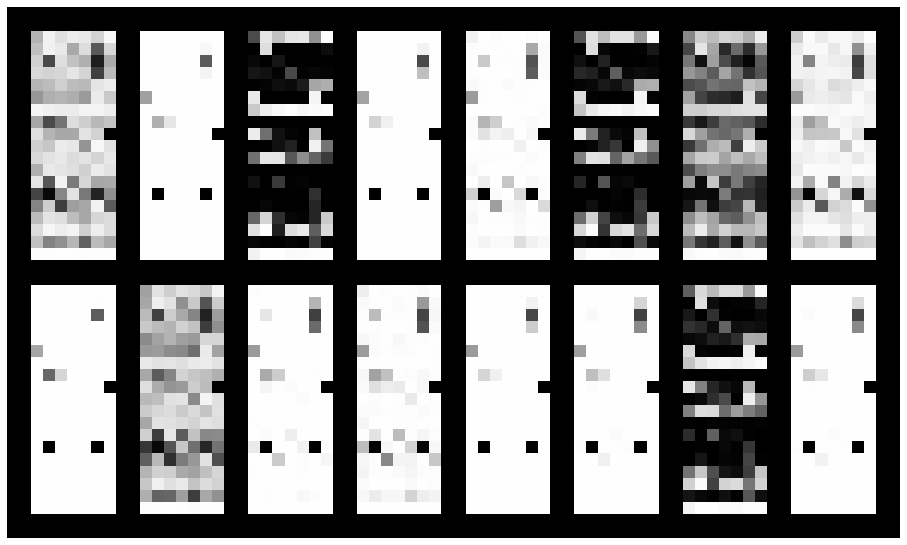

Epoch: [26/200], Batch Num: [0/54]
Discriminator Loss: 0.0726, Generator Loss: 7.7231
D(x): 0.9842, D(G(z)): 0.0118


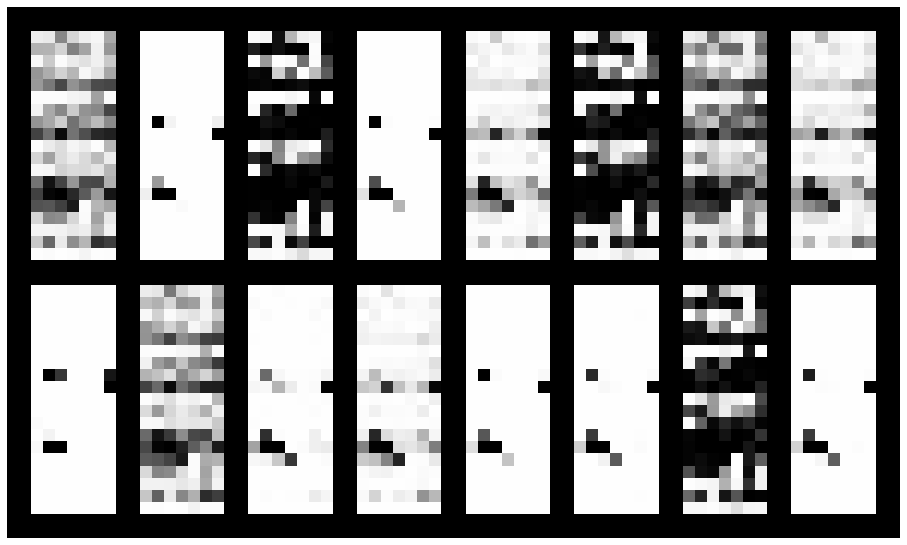

Epoch: [27/200], Batch Num: [0/54]
Discriminator Loss: 0.0225, Generator Loss: 8.3169
D(x): 0.9933, D(G(z)): 0.0051


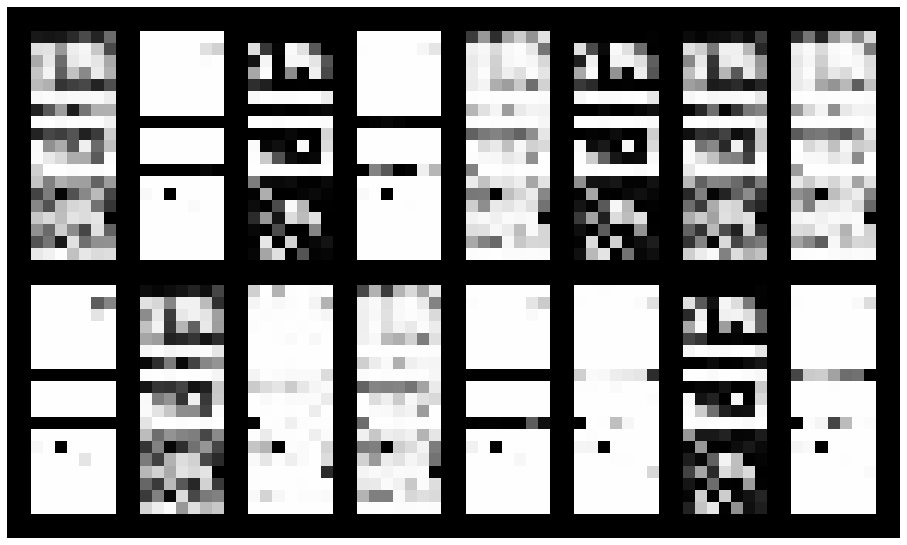

Epoch: [28/200], Batch Num: [0/54]
Discriminator Loss: 0.0377, Generator Loss: 9.8195
D(x): 0.9916, D(G(z)): 0.0117


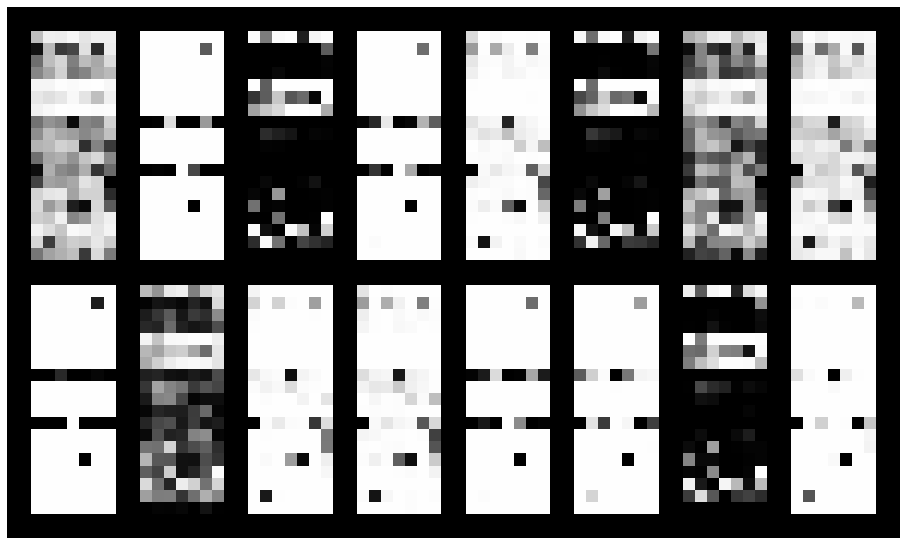

Epoch: [29/200], Batch Num: [0/54]
Discriminator Loss: 0.0434, Generator Loss: 7.5242
D(x): 0.9900, D(G(z)): 0.0068


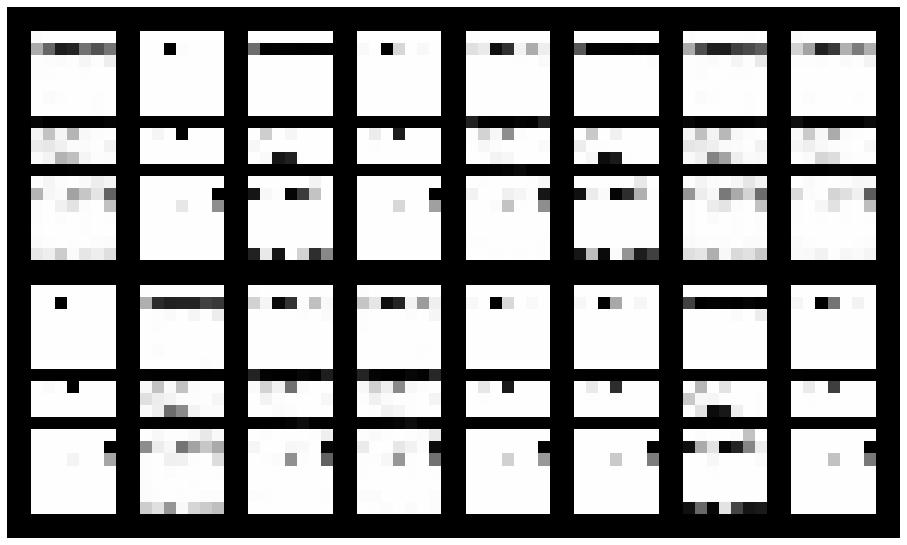

Epoch: [30/200], Batch Num: [0/54]
Discriminator Loss: 0.0191, Generator Loss: 6.2998
D(x): 0.9942, D(G(z)): 0.0065


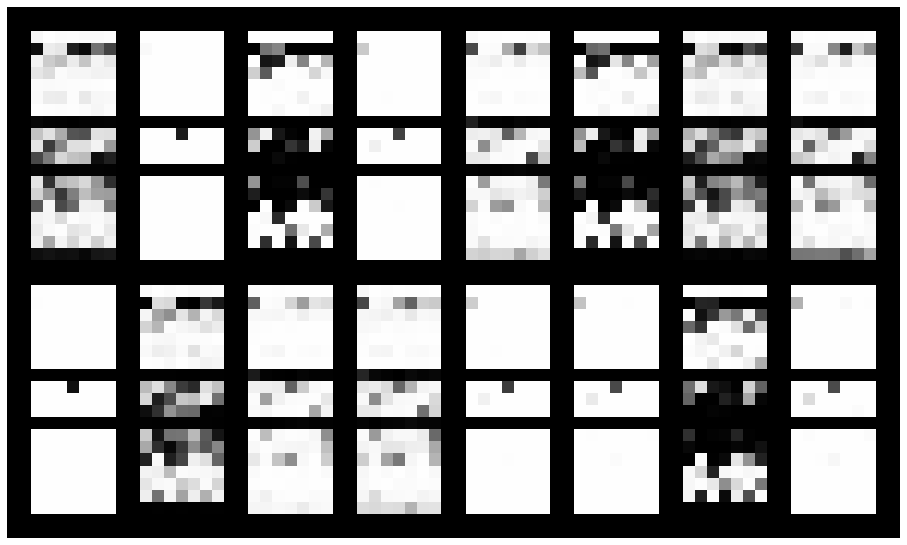

Epoch: [31/200], Batch Num: [0/54]
Discriminator Loss: 0.0227, Generator Loss: 7.4140
D(x): 0.9937, D(G(z)): 0.0107


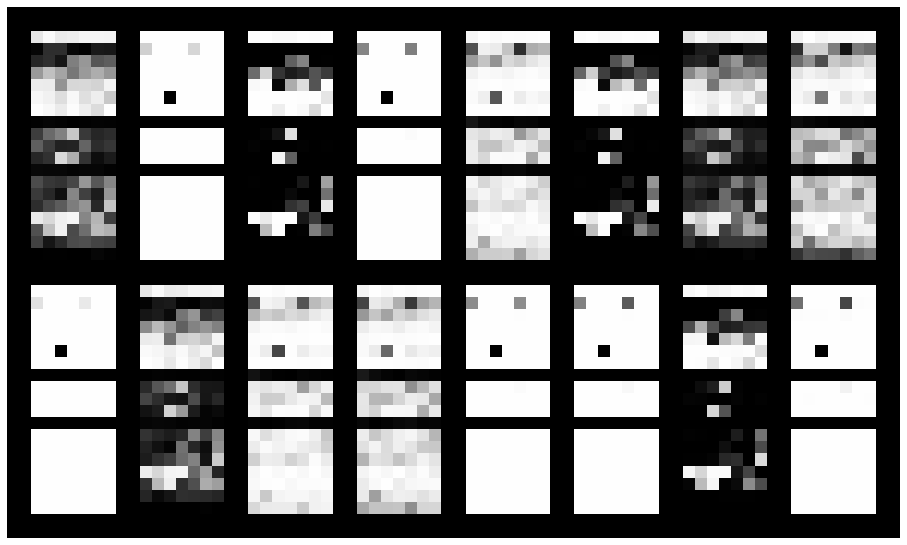

Epoch: [32/200], Batch Num: [0/54]
Discriminator Loss: 0.0189, Generator Loss: 7.1998
D(x): 0.9948, D(G(z)): 0.0080


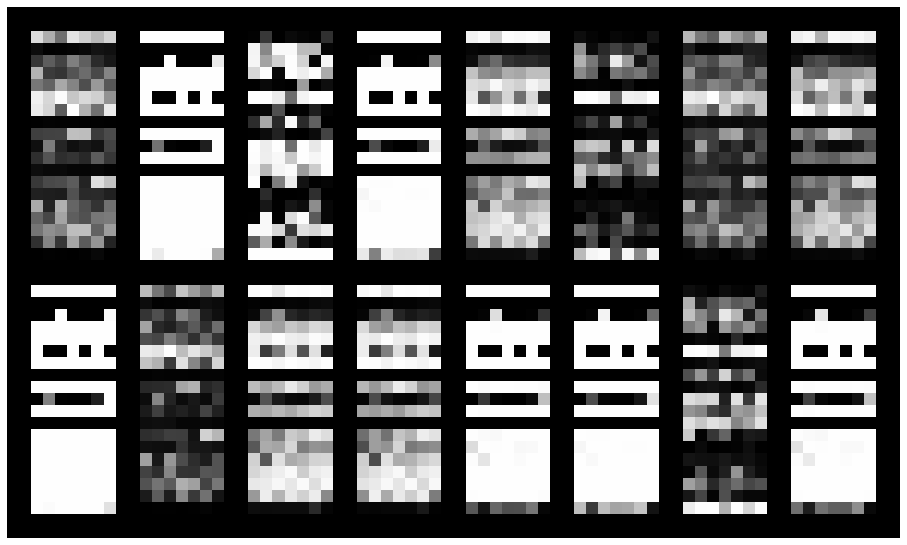

Epoch: [33/200], Batch Num: [0/54]
Discriminator Loss: 0.0469, Generator Loss: 6.9582
D(x): 0.9890, D(G(z)): 0.0110


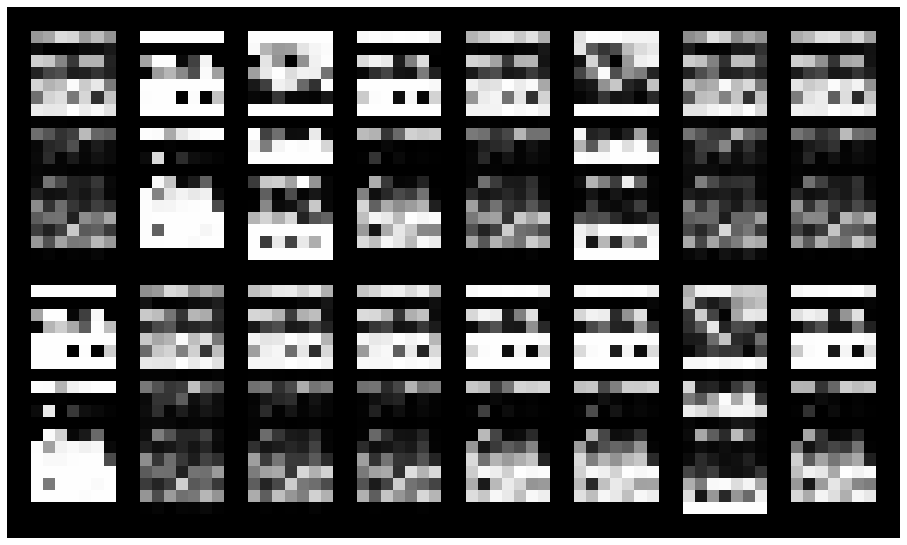

Epoch: [34/200], Batch Num: [0/54]
Discriminator Loss: 0.0742, Generator Loss: 6.3469
D(x): 0.9914, D(G(z)): 0.0231


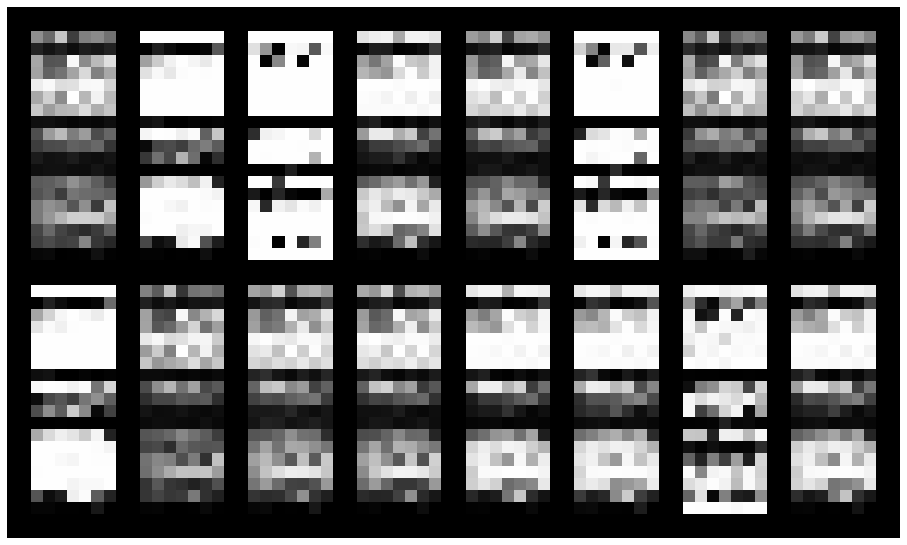

Epoch: [35/200], Batch Num: [0/54]
Discriminator Loss: 0.0561, Generator Loss: 8.0543
D(x): 0.9840, D(G(z)): 0.0031


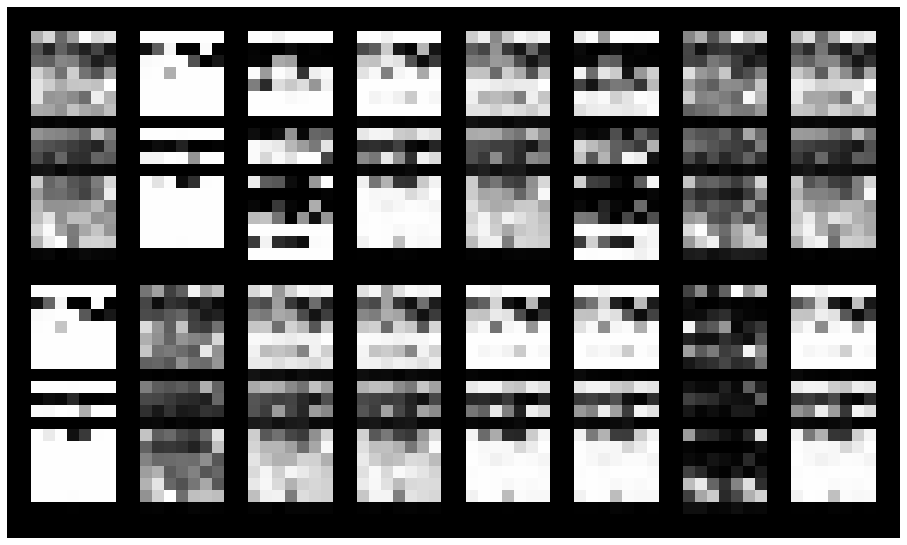

Epoch: [36/200], Batch Num: [0/54]
Discriminator Loss: 0.0643, Generator Loss: 6.9175
D(x): 0.9881, D(G(z)): 0.0217


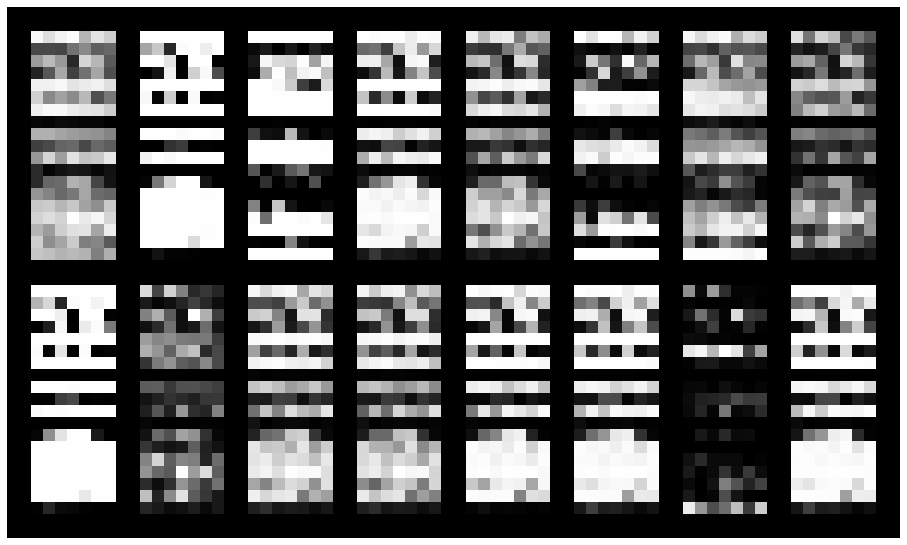

Epoch: [37/200], Batch Num: [0/54]
Discriminator Loss: 0.0148, Generator Loss: 8.7562
D(x): 0.9985, D(G(z)): 0.0109


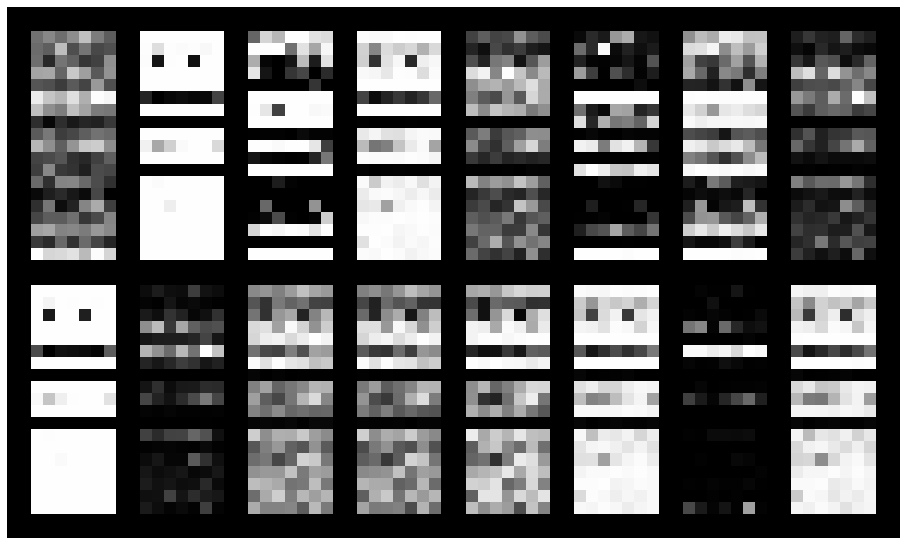

Epoch: [38/200], Batch Num: [0/54]
Discriminator Loss: 0.0238, Generator Loss: 7.4155
D(x): 0.9926, D(G(z)): 0.0067


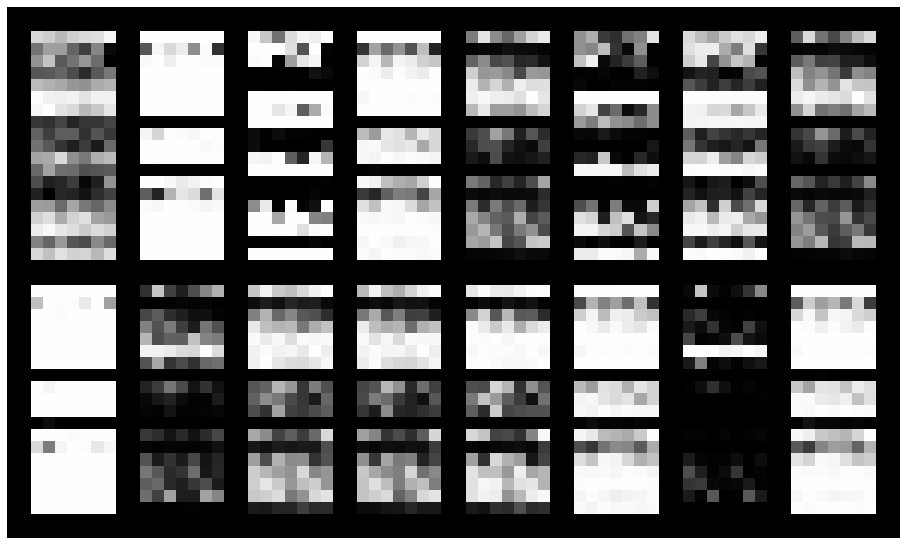

Epoch: [39/200], Batch Num: [0/54]
Discriminator Loss: 0.0577, Generator Loss: 6.1388
D(x): 0.9860, D(G(z)): 0.0122


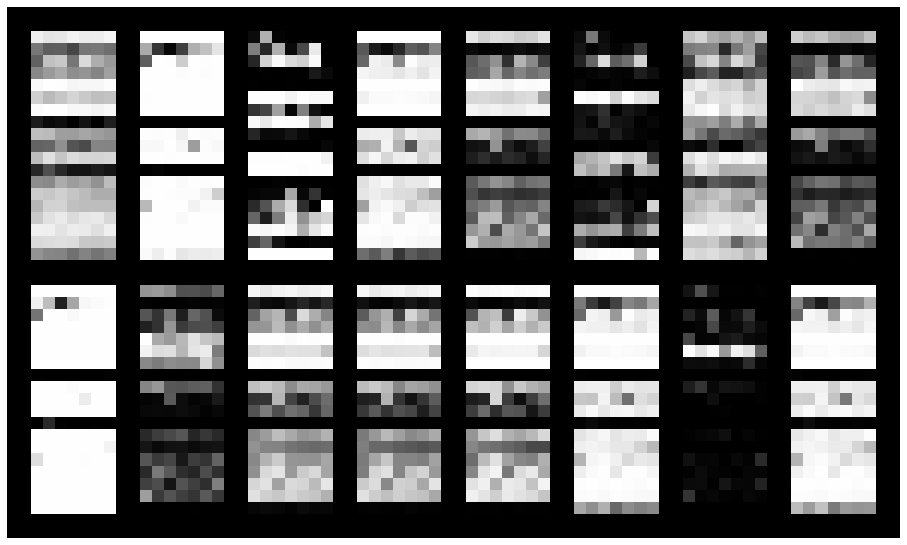

Epoch: [40/200], Batch Num: [0/54]
Discriminator Loss: 0.0222, Generator Loss: 6.6997
D(x): 0.9951, D(G(z)): 0.0087


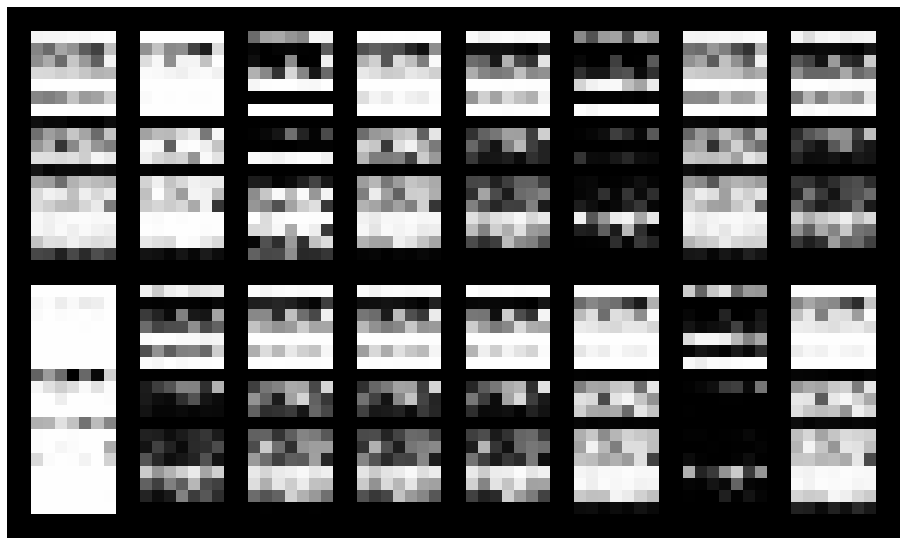

Epoch: [41/200], Batch Num: [0/54]
Discriminator Loss: 0.1156, Generator Loss: 6.9477
D(x): 0.9824, D(G(z)): 0.0059


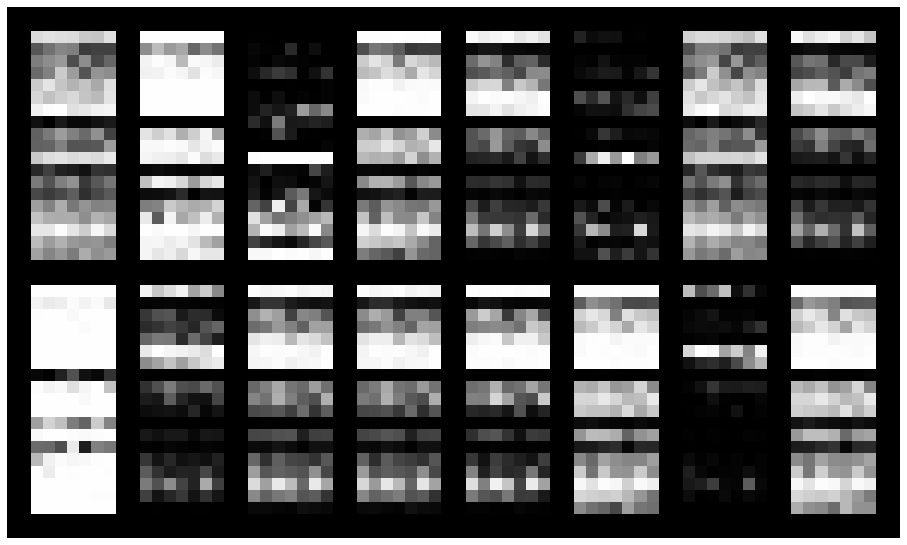

Epoch: [42/200], Batch Num: [0/54]
Discriminator Loss: 0.0344, Generator Loss: 6.0269
D(x): 0.9944, D(G(z)): 0.0204


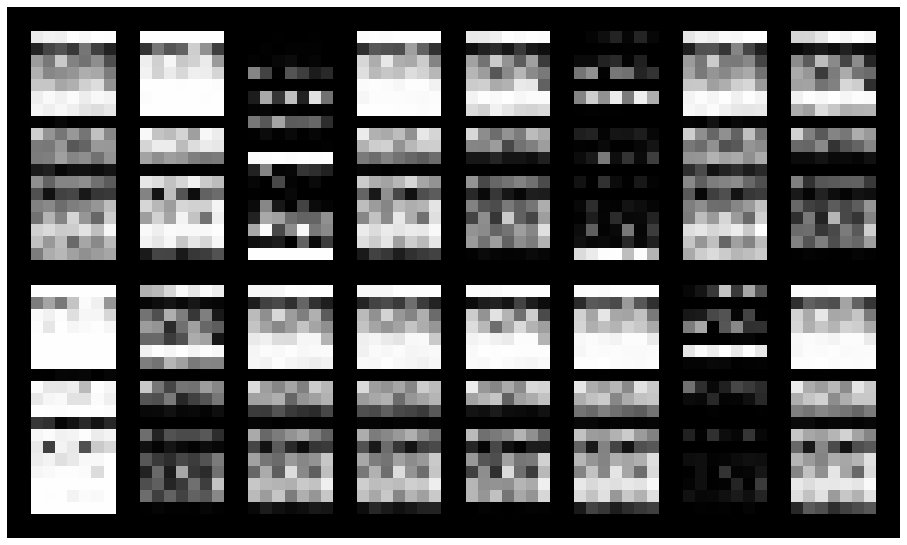

Epoch: [43/200], Batch Num: [0/54]
Discriminator Loss: 0.0423, Generator Loss: 6.2338
D(x): 0.9890, D(G(z)): 0.0071


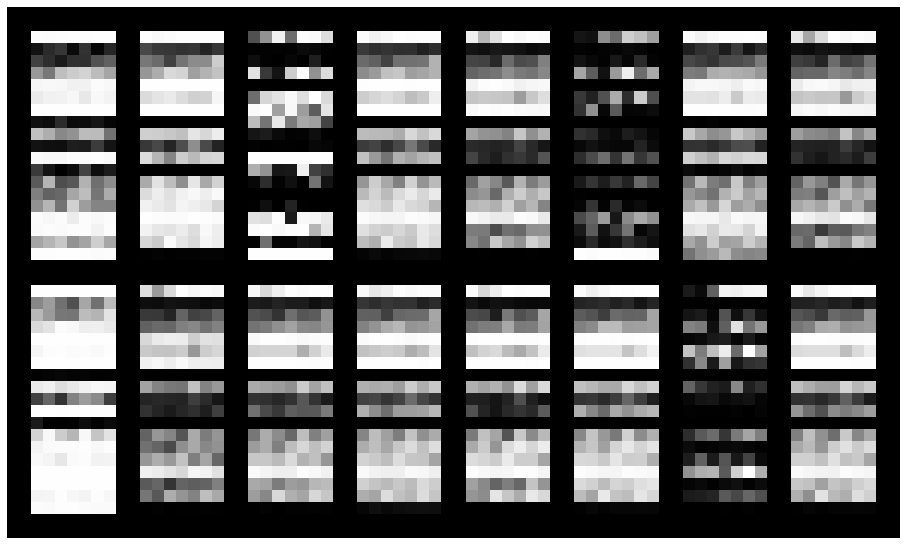

Epoch: [44/200], Batch Num: [0/54]
Discriminator Loss: 0.0488, Generator Loss: 5.6865
D(x): 0.9903, D(G(z)): 0.0106


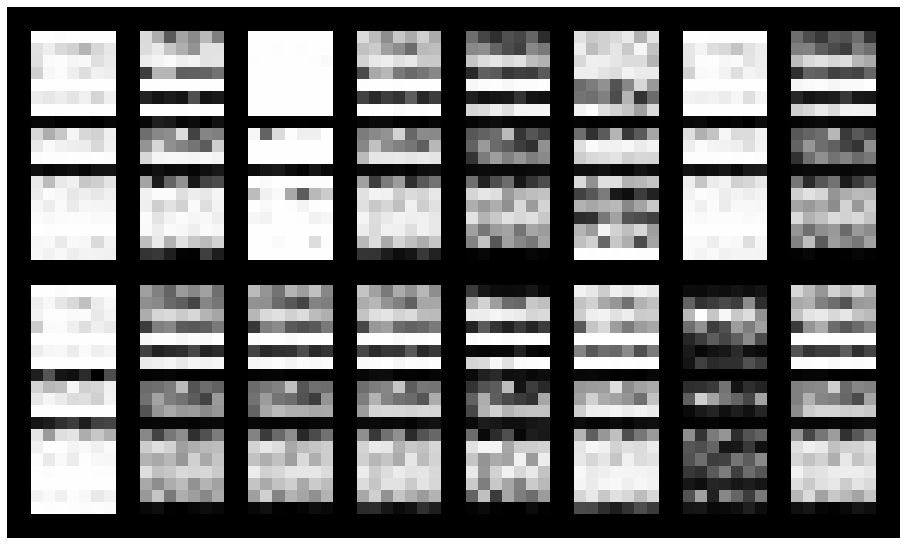

Epoch: [45/200], Batch Num: [0/54]
Discriminator Loss: 0.0670, Generator Loss: 8.7654
D(x): 0.9807, D(G(z)): 0.0025


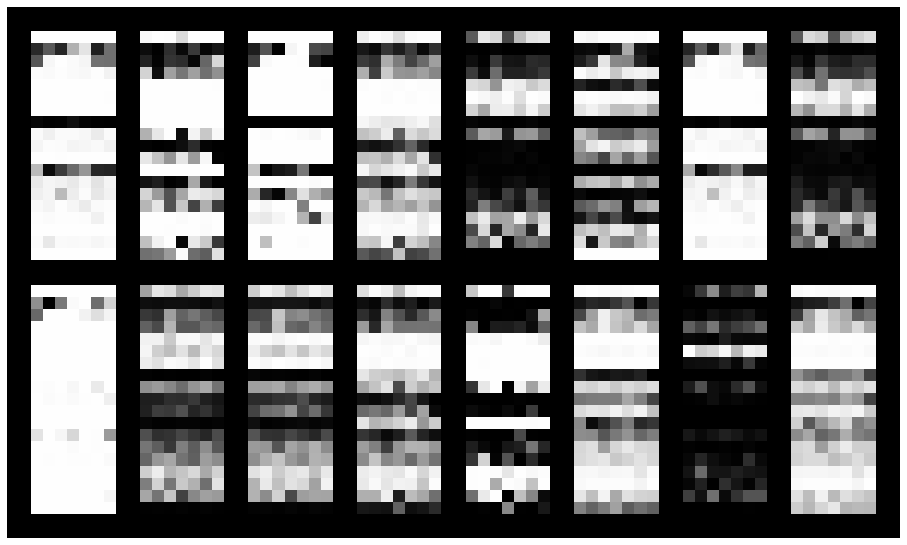

Epoch: [46/200], Batch Num: [0/54]
Discriminator Loss: 0.0720, Generator Loss: 6.0924
D(x): 0.9778, D(G(z)): 0.0149


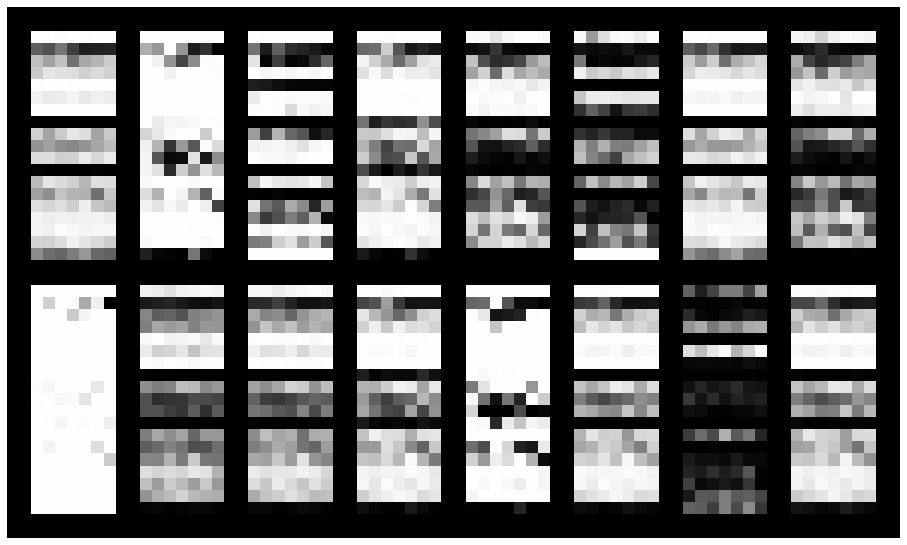

Epoch: [47/200], Batch Num: [0/54]
Discriminator Loss: 0.0359, Generator Loss: 6.1007
D(x): 0.9924, D(G(z)): 0.0141


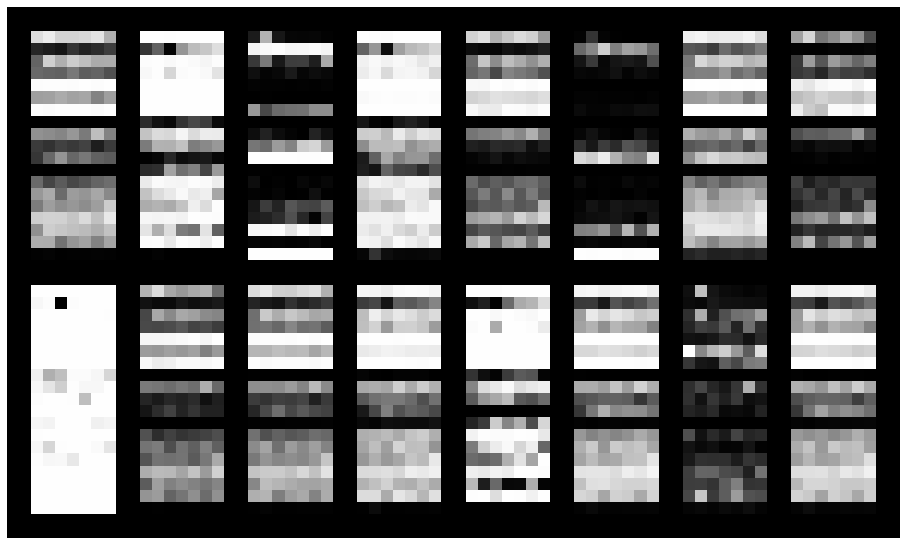

Epoch: [48/200], Batch Num: [0/54]
Discriminator Loss: 0.0382, Generator Loss: 5.5221
D(x): 0.9932, D(G(z)): 0.0148


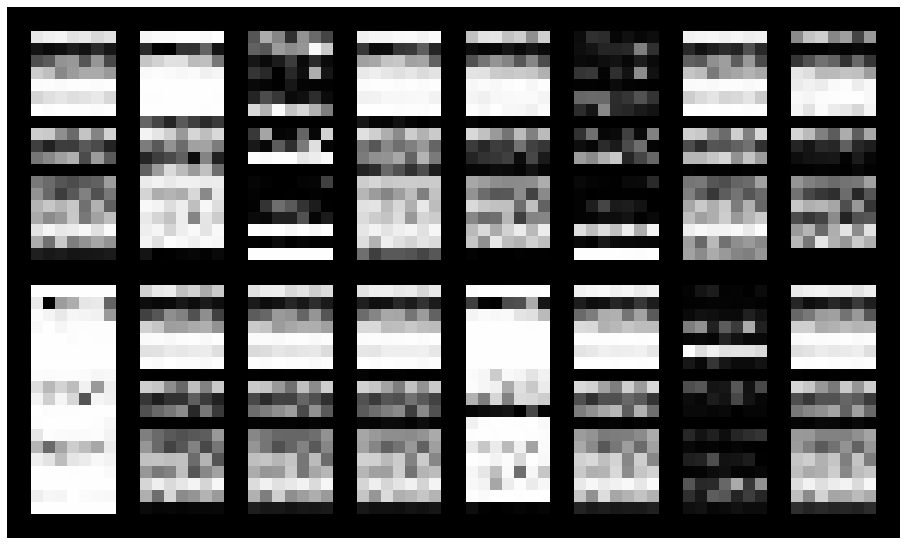

Epoch: [49/200], Batch Num: [0/54]
Discriminator Loss: 0.0559, Generator Loss: 5.4166
D(x): 0.9810, D(G(z)): 0.0129


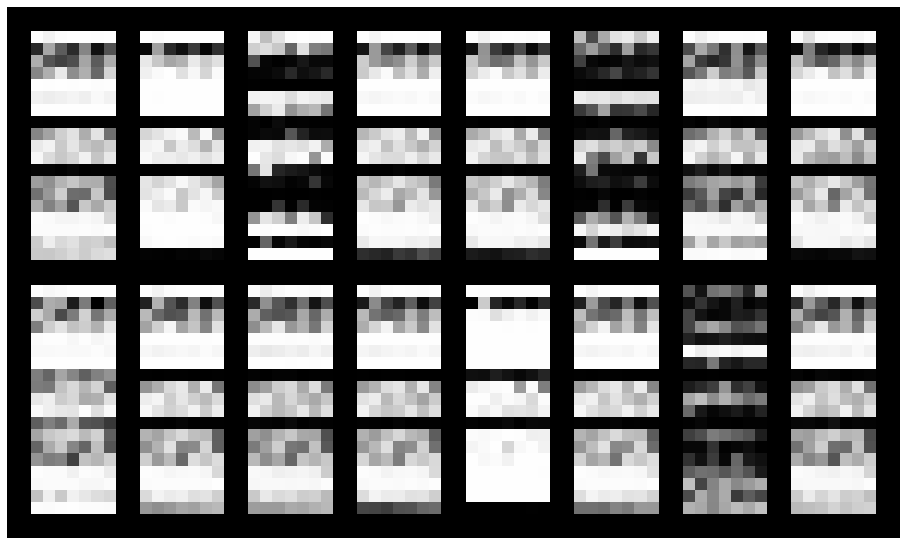

Epoch: [50/200], Batch Num: [0/54]
Discriminator Loss: 0.0787, Generator Loss: 5.2730
D(x): 0.9825, D(G(z)): 0.0192


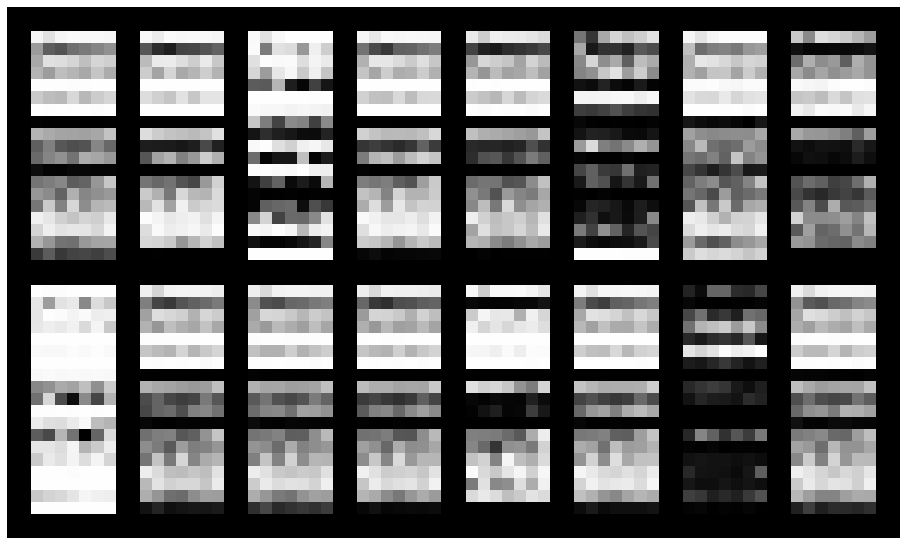

Epoch: [51/200], Batch Num: [0/54]
Discriminator Loss: 0.0358, Generator Loss: 5.8663
D(x): 0.9900, D(G(z)): 0.0113


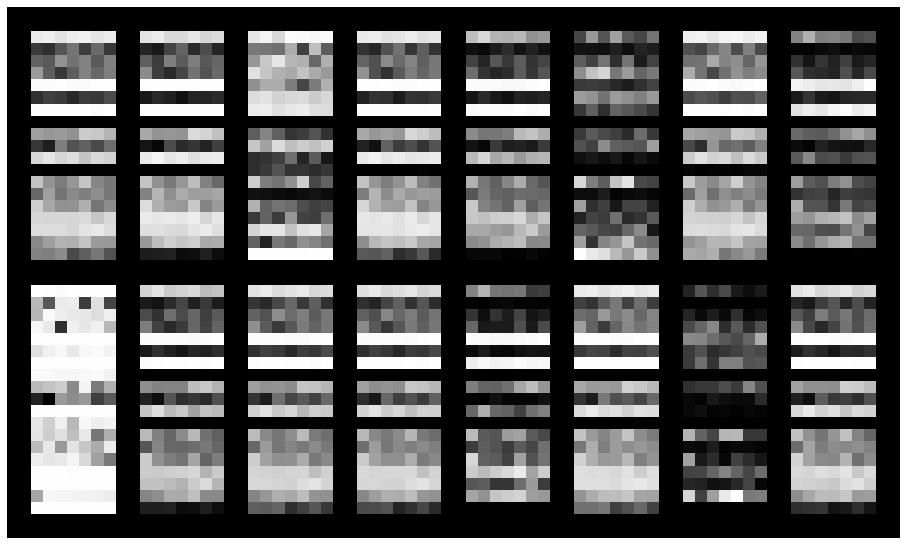

Epoch: [52/200], Batch Num: [0/54]
Discriminator Loss: 0.0519, Generator Loss: 6.0616
D(x): 0.9878, D(G(z)): 0.0086


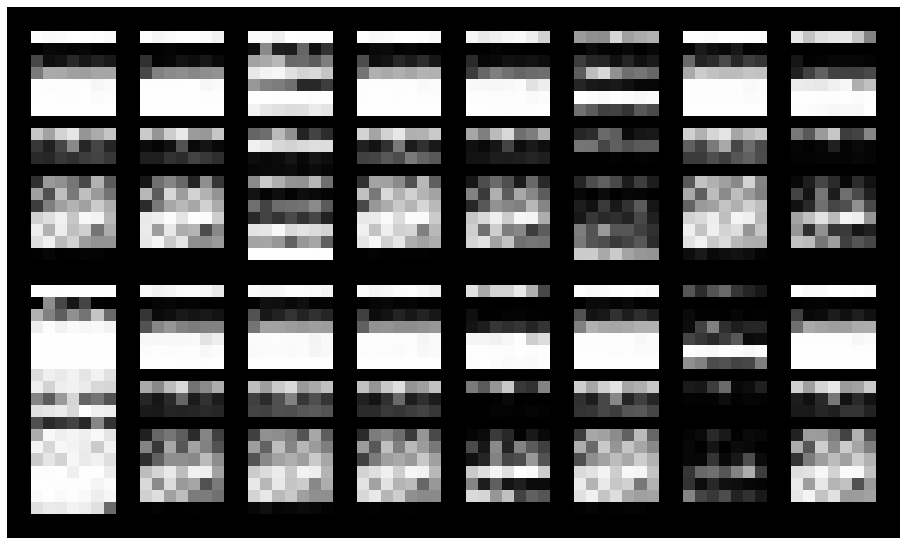

Epoch: [53/200], Batch Num: [0/54]
Discriminator Loss: 0.0393, Generator Loss: 5.9008
D(x): 0.9959, D(G(z)): 0.0174


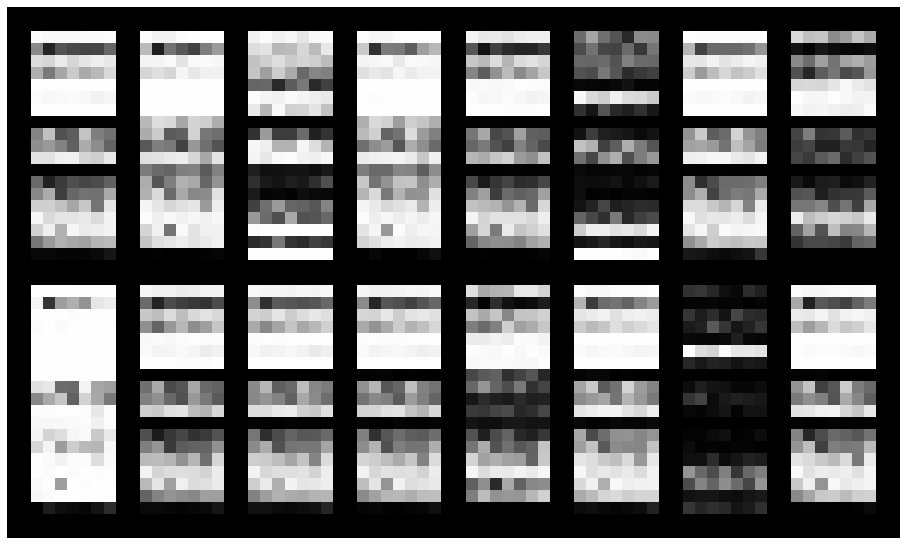

Epoch: [54/200], Batch Num: [0/54]
Discriminator Loss: 0.0363, Generator Loss: 5.7607
D(x): 0.9937, D(G(z)): 0.0131


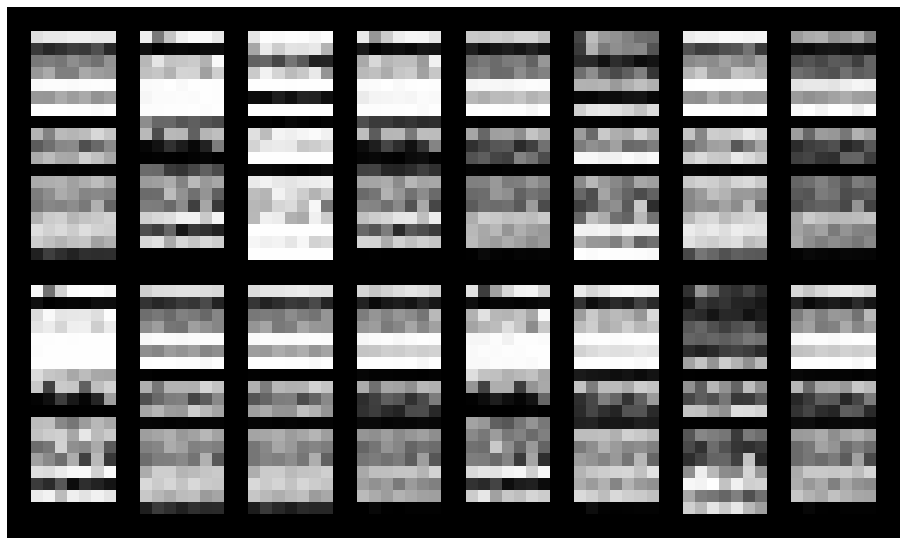

Epoch: [55/200], Batch Num: [0/54]
Discriminator Loss: 0.0661, Generator Loss: 6.6900
D(x): 0.9826, D(G(z)): 0.0090


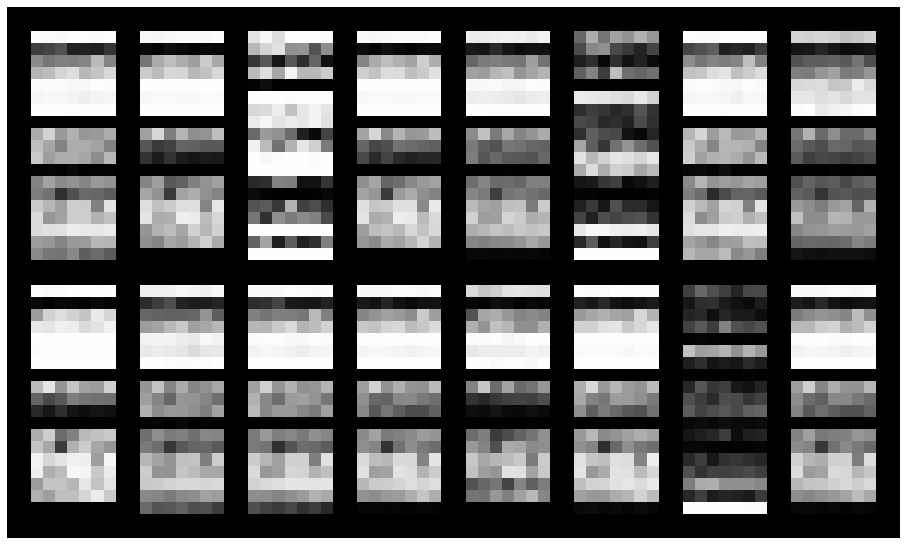

Epoch: [56/200], Batch Num: [0/54]
Discriminator Loss: 0.0201, Generator Loss: 6.0999
D(x): 0.9958, D(G(z)): 0.0104


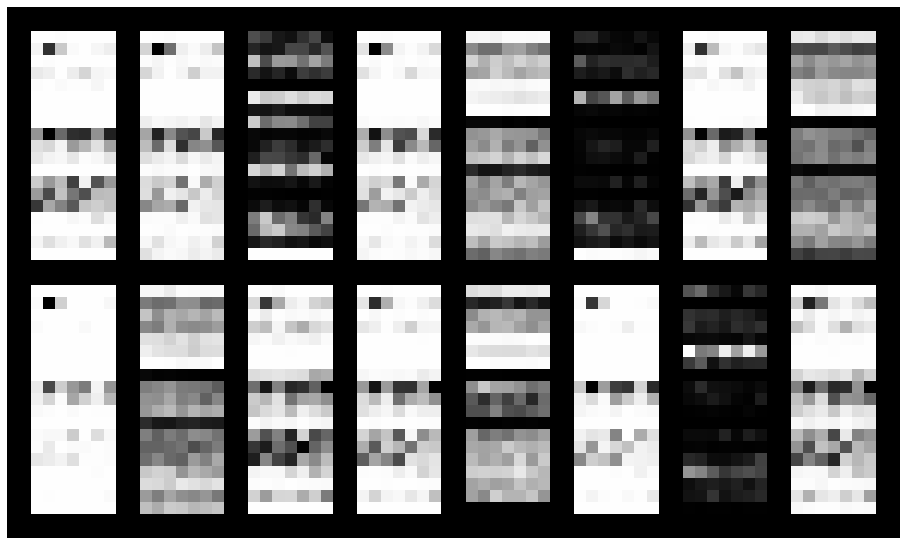

Epoch: [57/200], Batch Num: [0/54]
Discriminator Loss: 0.0284, Generator Loss: 6.2803
D(x): 0.9943, D(G(z)): 0.0137


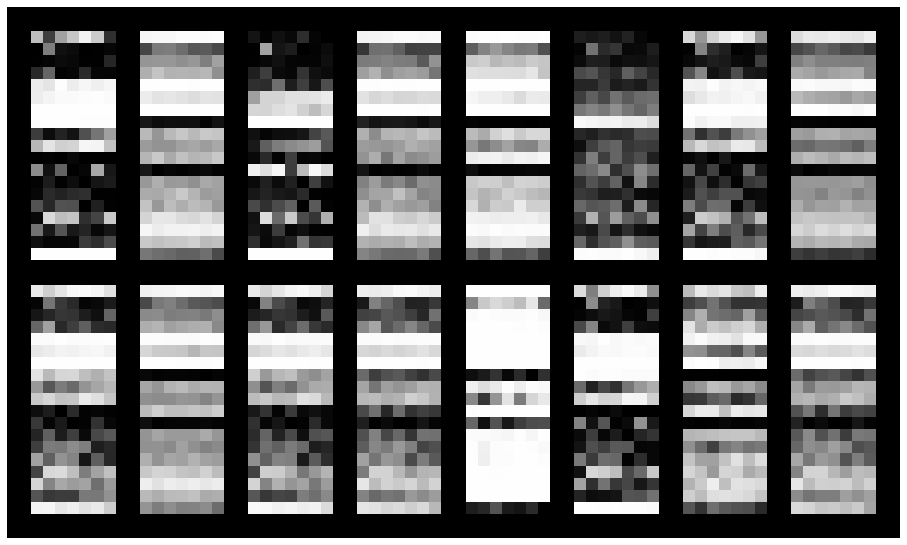

Epoch: [58/200], Batch Num: [0/54]
Discriminator Loss: 0.0734, Generator Loss: 5.6578
D(x): 0.9871, D(G(z)): 0.0212


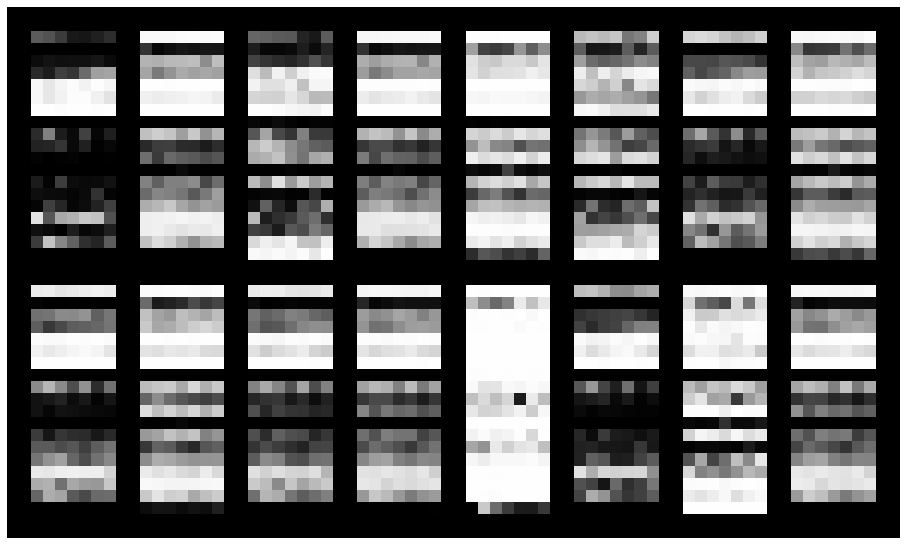

Epoch: [59/200], Batch Num: [0/54]
Discriminator Loss: 0.0346, Generator Loss: 6.0261
D(x): 0.9930, D(G(z)): 0.0108


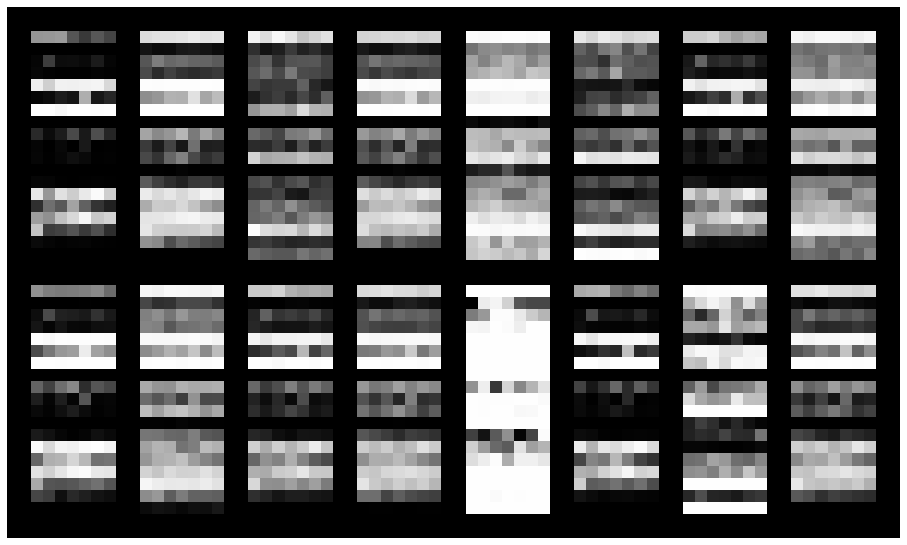

Epoch: [60/200], Batch Num: [0/54]
Discriminator Loss: 0.0738, Generator Loss: 6.3526
D(x): 0.9839, D(G(z)): 0.0096


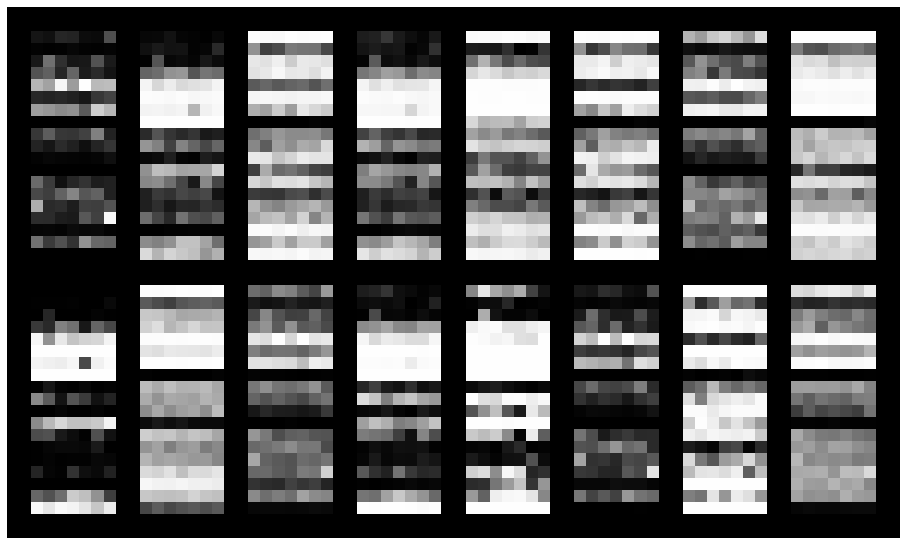

Epoch: [61/200], Batch Num: [0/54]
Discriminator Loss: 0.0386, Generator Loss: 6.0111
D(x): 0.9925, D(G(z)): 0.0121


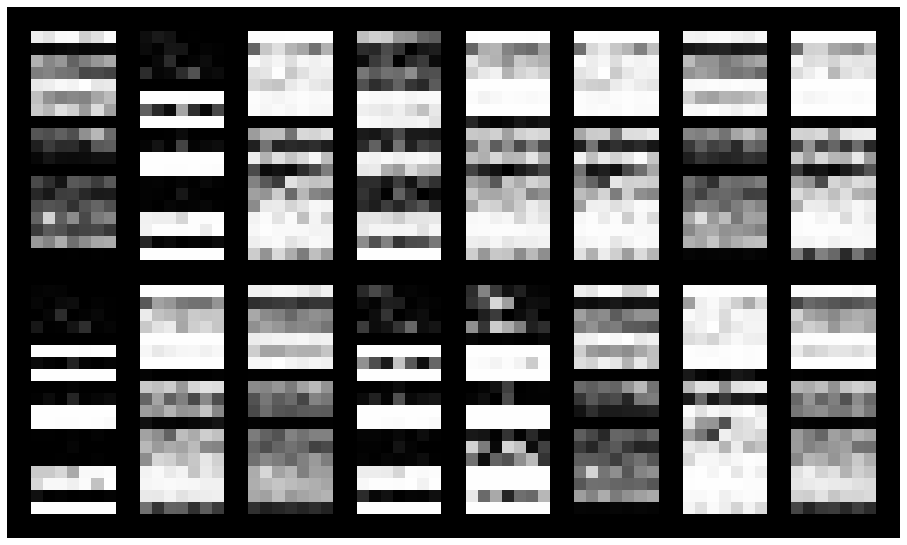

Epoch: [62/200], Batch Num: [0/54]
Discriminator Loss: 0.0318, Generator Loss: 5.8882
D(x): 0.9939, D(G(z)): 0.0108


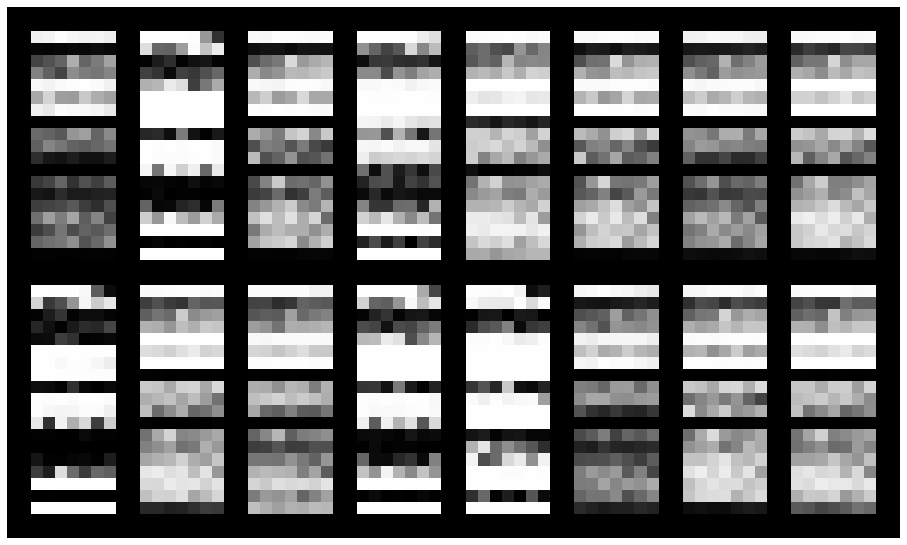

Epoch: [63/200], Batch Num: [0/54]
Discriminator Loss: 0.0475, Generator Loss: 5.2782
D(x): 0.9888, D(G(z)): 0.0131


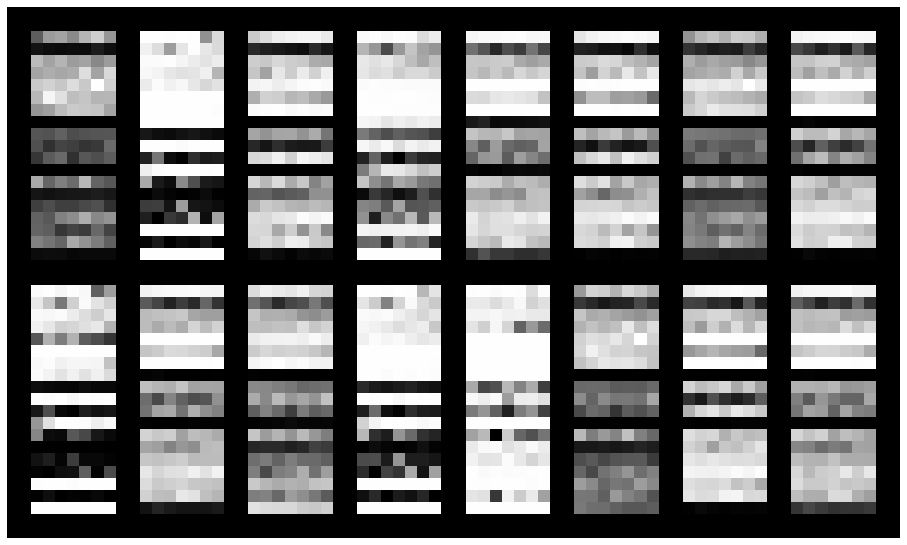

Epoch: [64/200], Batch Num: [0/54]
Discriminator Loss: 0.0403, Generator Loss: 5.9394
D(x): 0.9903, D(G(z)): 0.0083


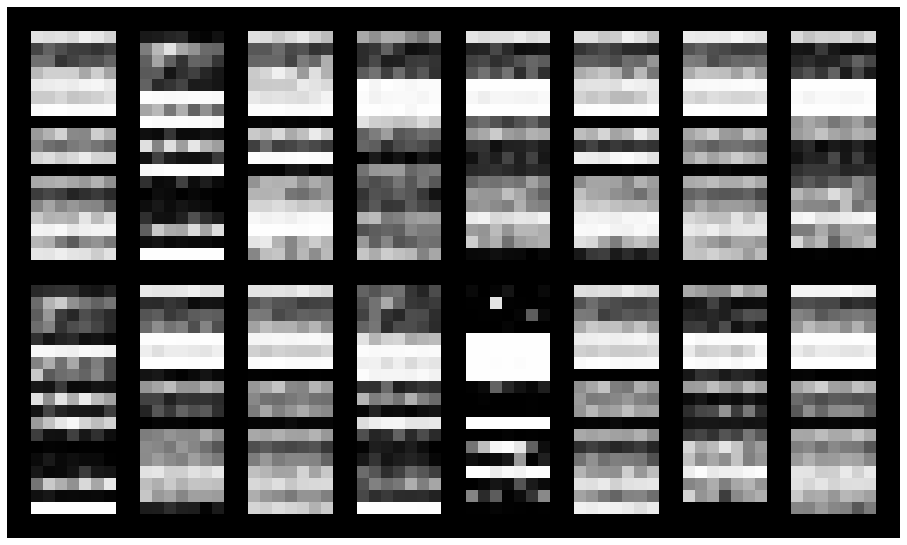

Epoch: [65/200], Batch Num: [0/54]
Discriminator Loss: 0.0240, Generator Loss: 6.0562
D(x): 0.9953, D(G(z)): 0.0134


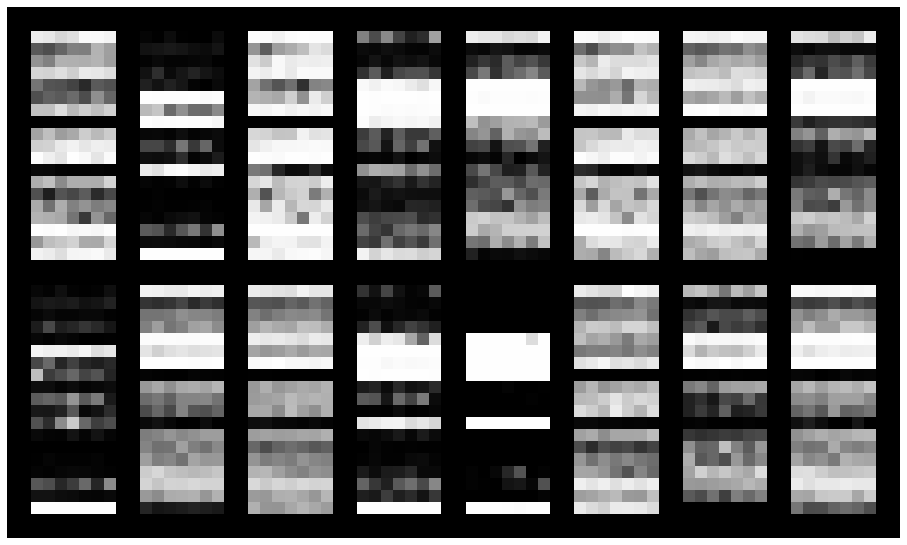

Epoch: [66/200], Batch Num: [0/54]
Discriminator Loss: 0.0220, Generator Loss: 5.6904
D(x): 0.9970, D(G(z)): 0.0130


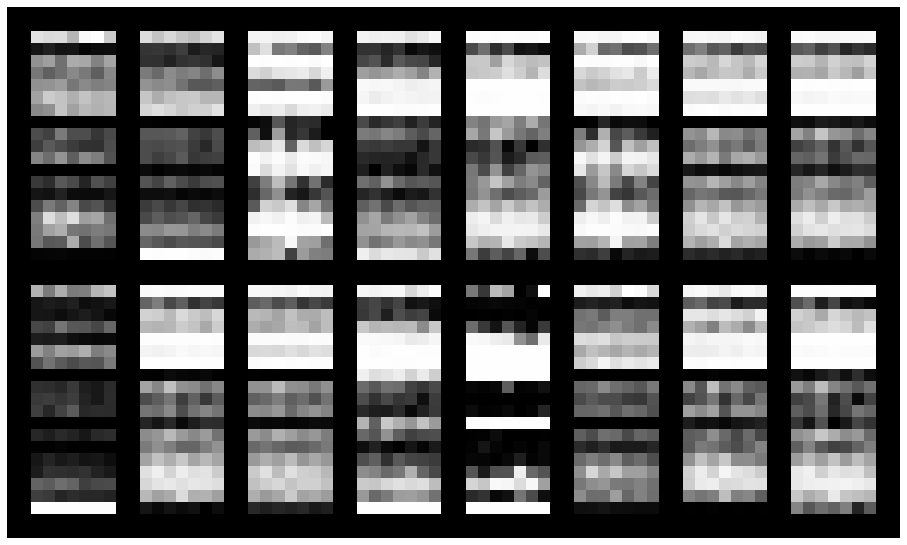

Epoch: [67/200], Batch Num: [0/54]
Discriminator Loss: 0.0393, Generator Loss: 5.5568
D(x): 0.9943, D(G(z)): 0.0123


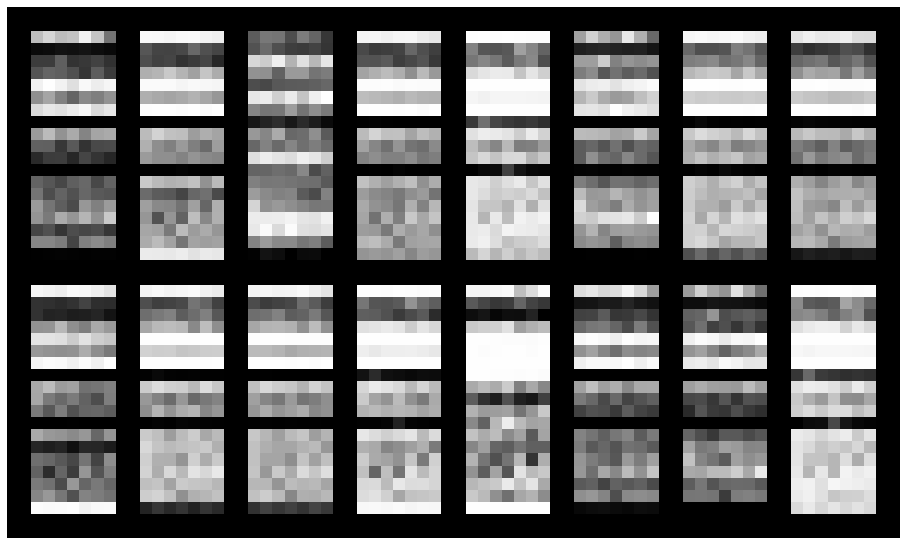

Epoch: [68/200], Batch Num: [0/54]
Discriminator Loss: 0.0744, Generator Loss: 5.1930
D(x): 0.9829, D(G(z)): 0.0111


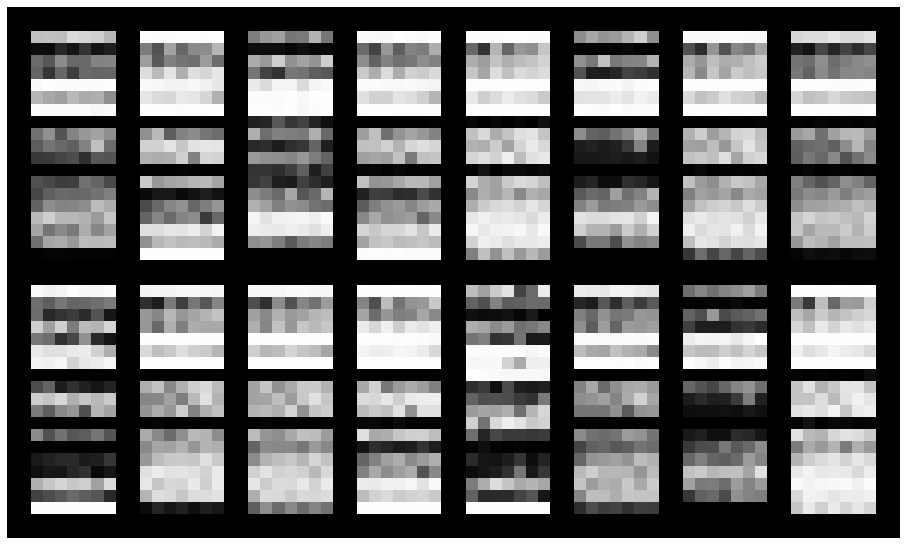

Epoch: [69/200], Batch Num: [0/54]
Discriminator Loss: 0.0499, Generator Loss: 5.7006
D(x): 0.9841, D(G(z)): 0.0089


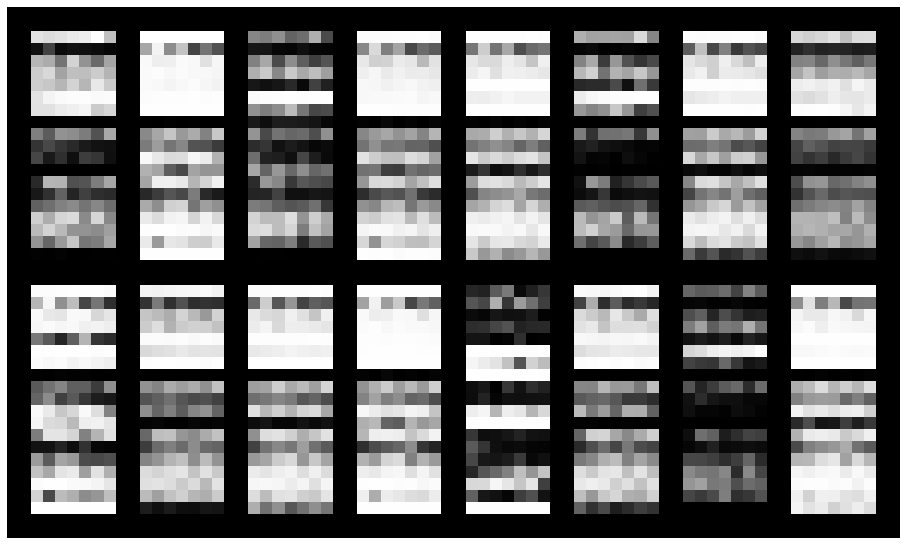

Epoch: [70/200], Batch Num: [0/54]
Discriminator Loss: 0.0329, Generator Loss: 5.9406
D(x): 0.9914, D(G(z)): 0.0067


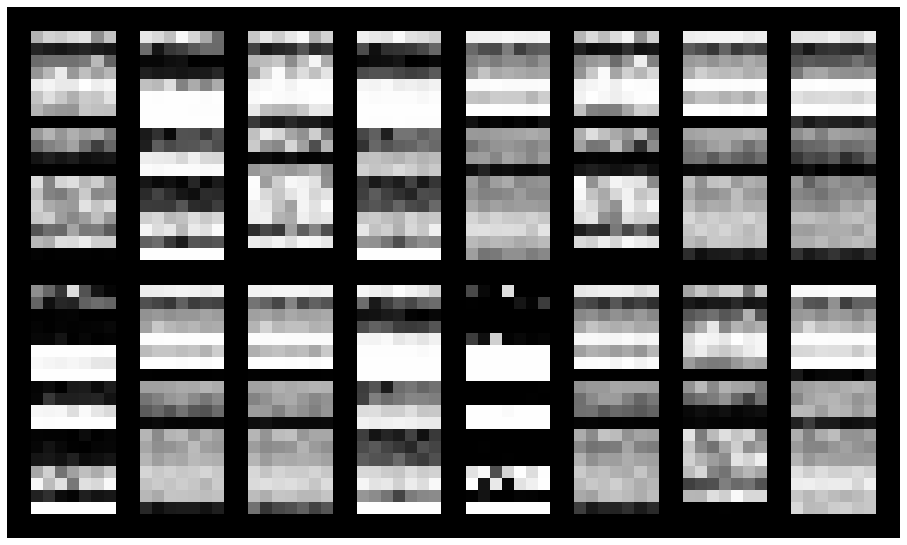

Epoch: [71/200], Batch Num: [0/54]
Discriminator Loss: 0.0969, Generator Loss: 6.1975
D(x): 0.9815, D(G(z)): 0.0087


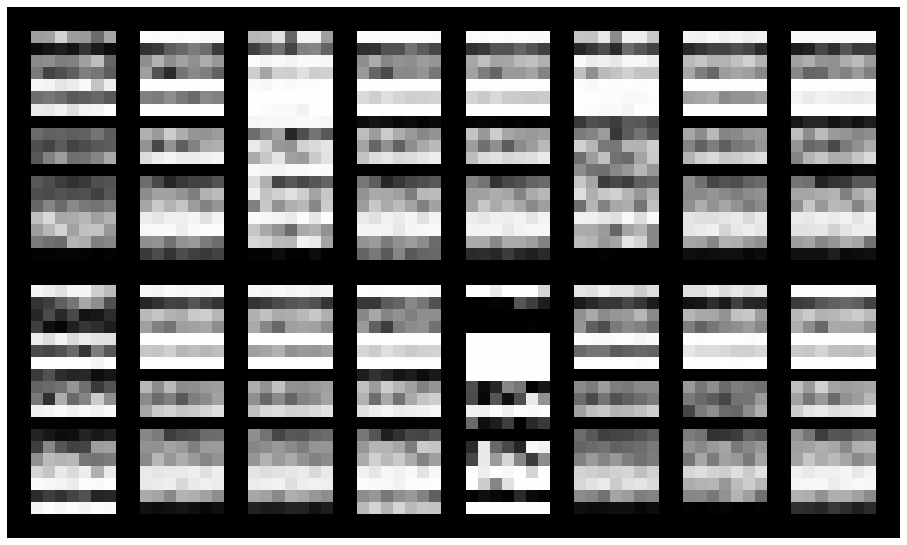

Epoch: [72/200], Batch Num: [0/54]
Discriminator Loss: 0.0226, Generator Loss: 6.2916
D(x): 0.9959, D(G(z)): 0.0044


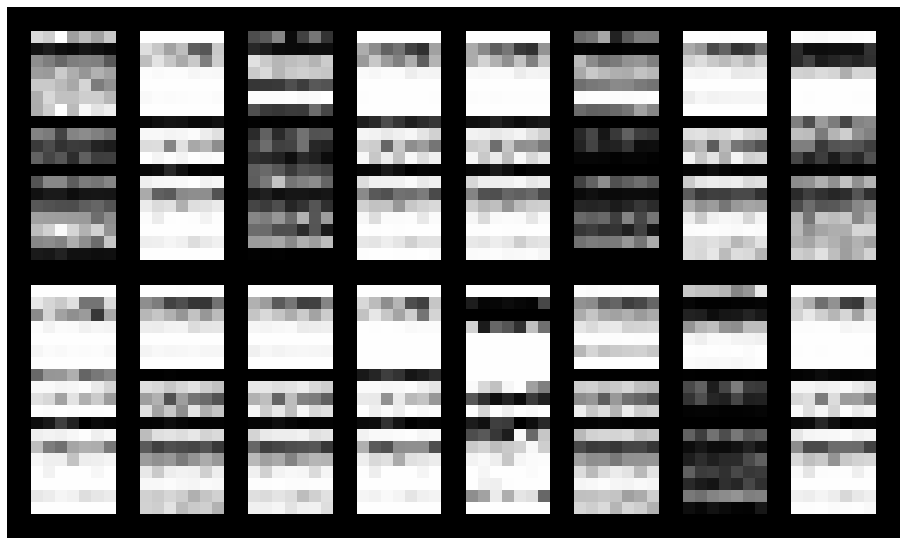

Epoch: [73/200], Batch Num: [0/54]
Discriminator Loss: 0.0643, Generator Loss: 7.0484
D(x): 0.9873, D(G(z)): 0.0055


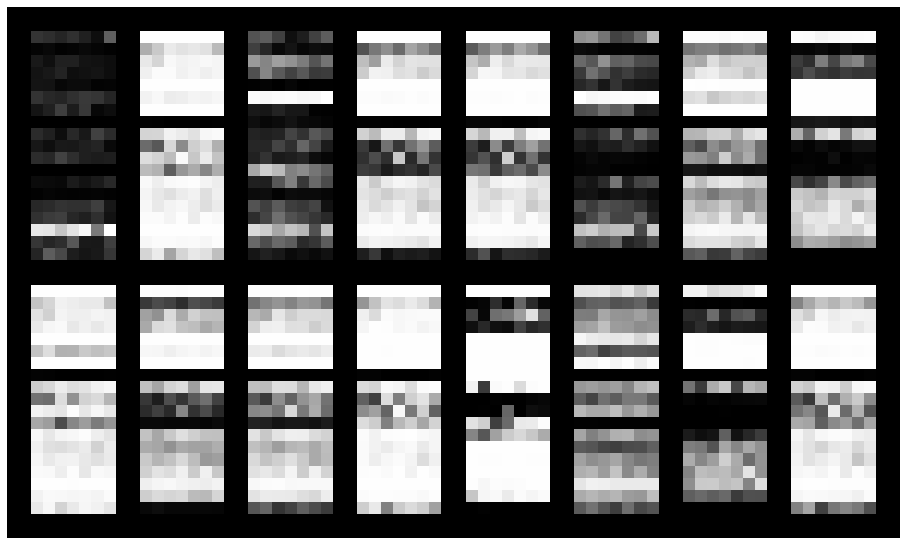

Epoch: [74/200], Batch Num: [0/54]
Discriminator Loss: 0.0293, Generator Loss: 6.4174
D(x): 0.9942, D(G(z)): 0.0066


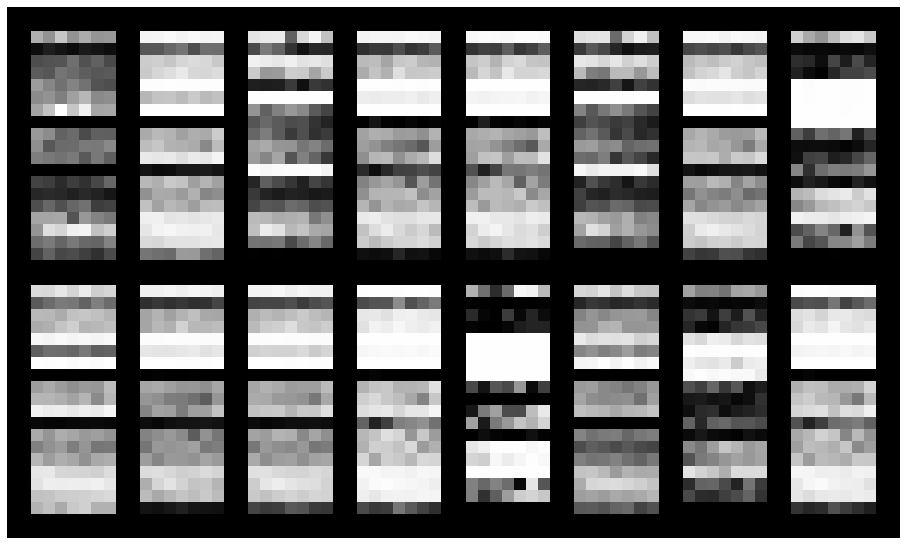

Epoch: [75/200], Batch Num: [0/54]
Discriminator Loss: 0.0137, Generator Loss: 6.1307
D(x): 0.9962, D(G(z)): 0.0085


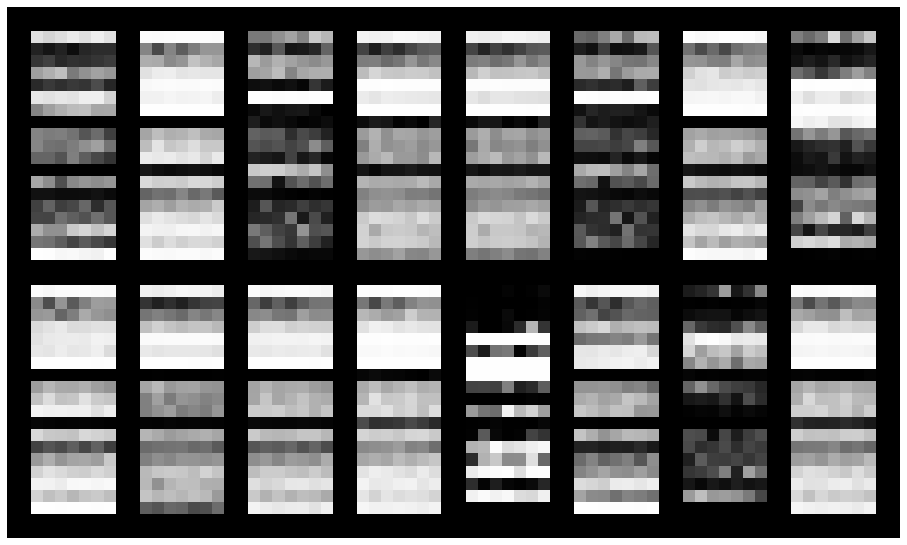

Epoch: [76/200], Batch Num: [0/54]
Discriminator Loss: 0.0208, Generator Loss: 6.1275
D(x): 0.9959, D(G(z)): 0.0090


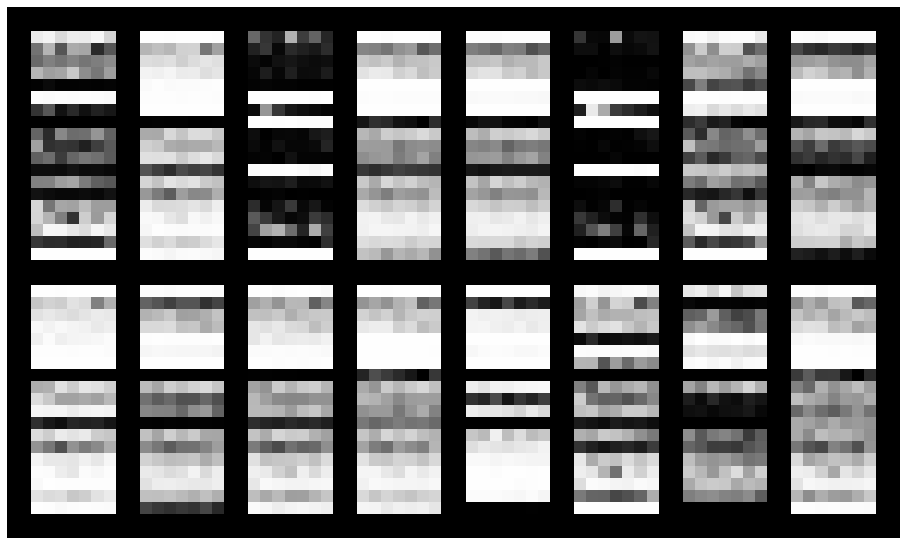

Epoch: [77/200], Batch Num: [0/54]
Discriminator Loss: 0.0652, Generator Loss: 5.9371
D(x): 0.9880, D(G(z)): 0.0082


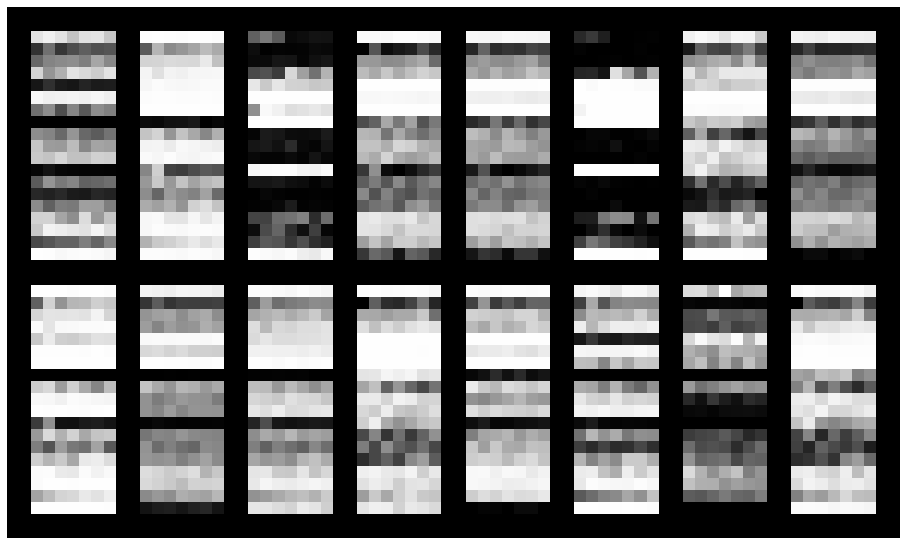

Epoch: [78/200], Batch Num: [0/54]
Discriminator Loss: 0.0333, Generator Loss: 5.8665
D(x): 0.9913, D(G(z)): 0.0079


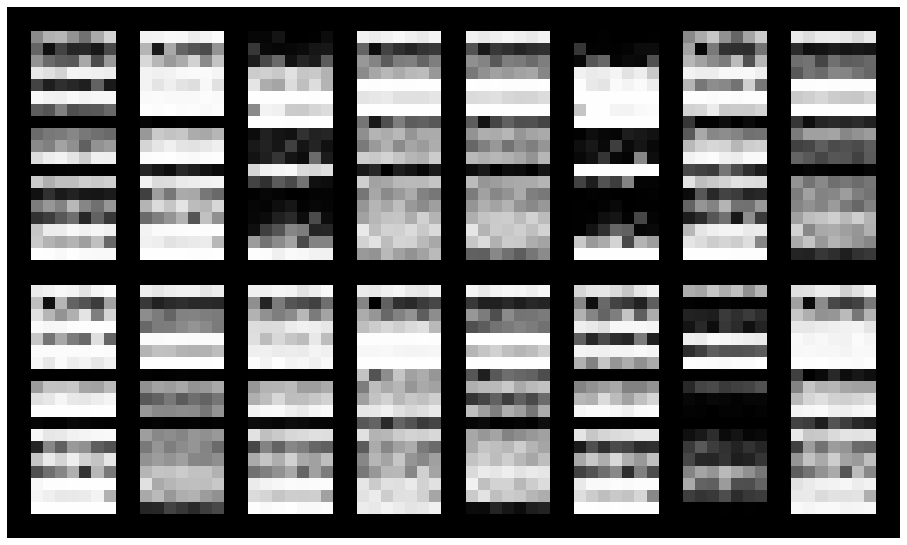

Epoch: [79/200], Batch Num: [0/54]
Discriminator Loss: 0.0120, Generator Loss: 5.6391
D(x): 0.9993, D(G(z)): 0.0103


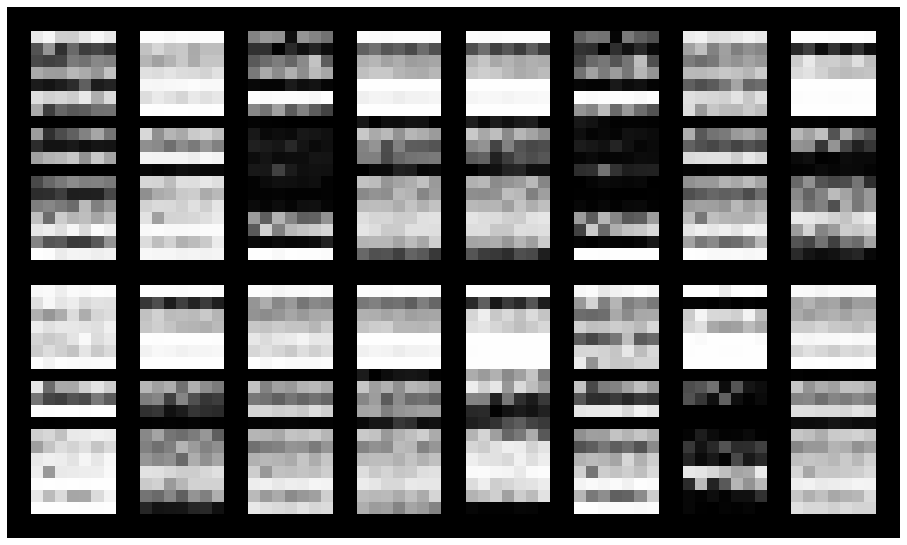

Epoch: [80/200], Batch Num: [0/54]
Discriminator Loss: 0.0306, Generator Loss: 6.1632
D(x): 0.9939, D(G(z)): 0.0069


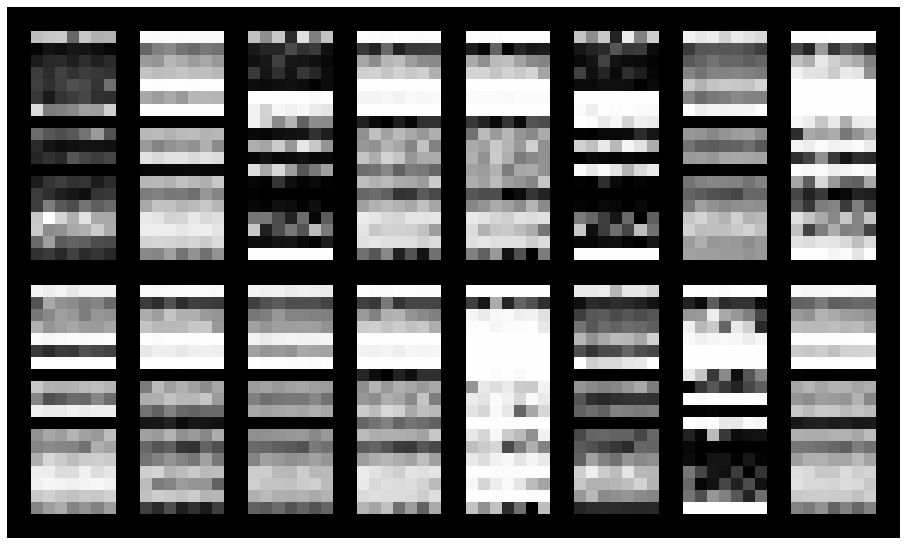

Epoch: [81/200], Batch Num: [0/54]
Discriminator Loss: 0.0690, Generator Loss: 6.7313
D(x): 0.9881, D(G(z)): 0.0049


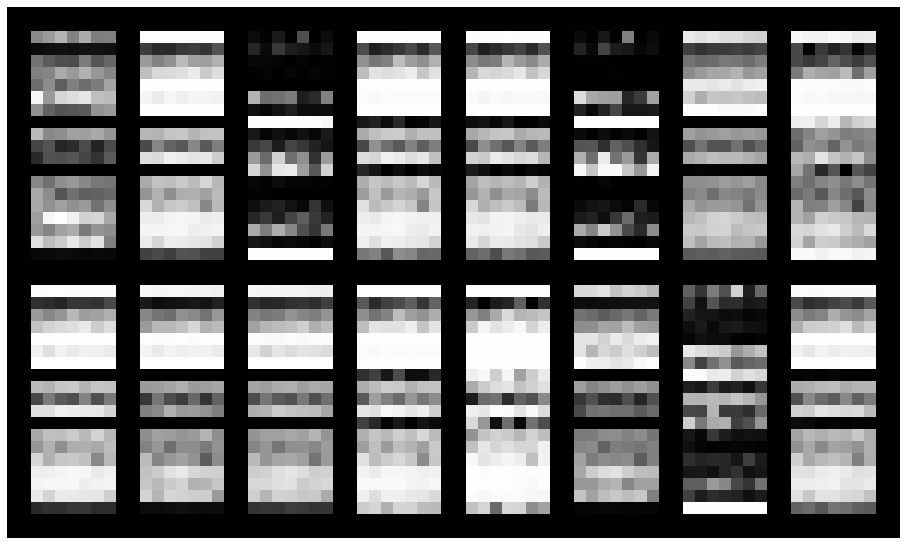

Epoch: [82/200], Batch Num: [0/54]
Discriminator Loss: 0.0662, Generator Loss: 5.4442
D(x): 0.9874, D(G(z)): 0.0102


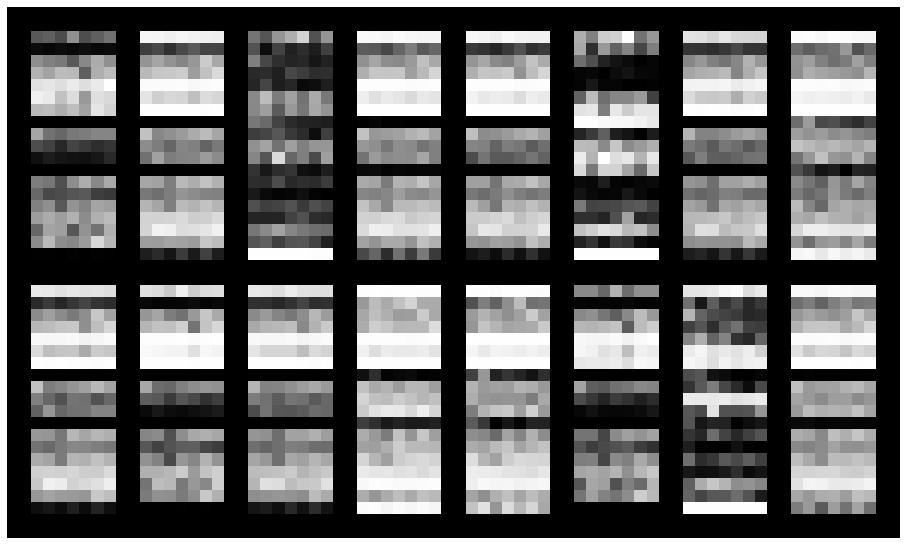

Epoch: [83/200], Batch Num: [0/54]
Discriminator Loss: 0.0231, Generator Loss: 6.2746
D(x): 0.9937, D(G(z)): 0.0052


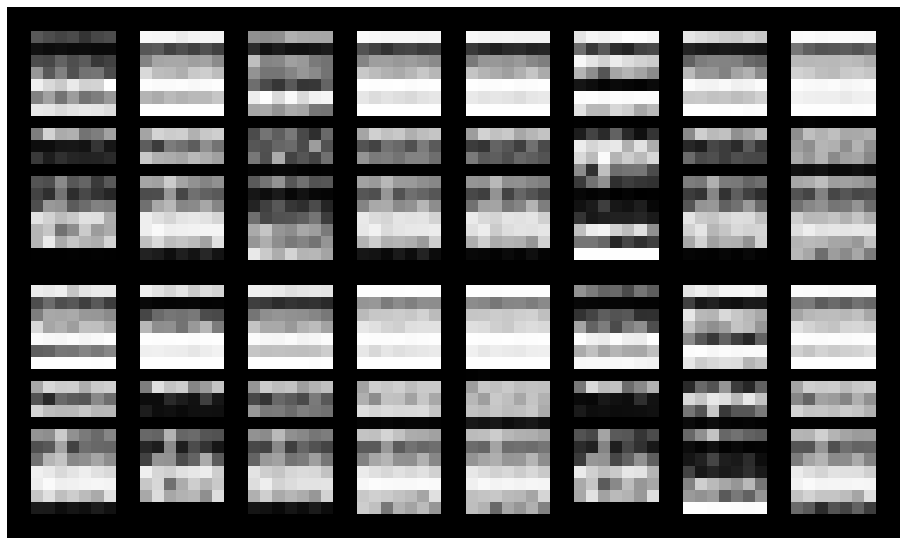

Epoch: [84/200], Batch Num: [0/54]
Discriminator Loss: 0.0622, Generator Loss: 6.7042
D(x): 0.9879, D(G(z)): 0.0057


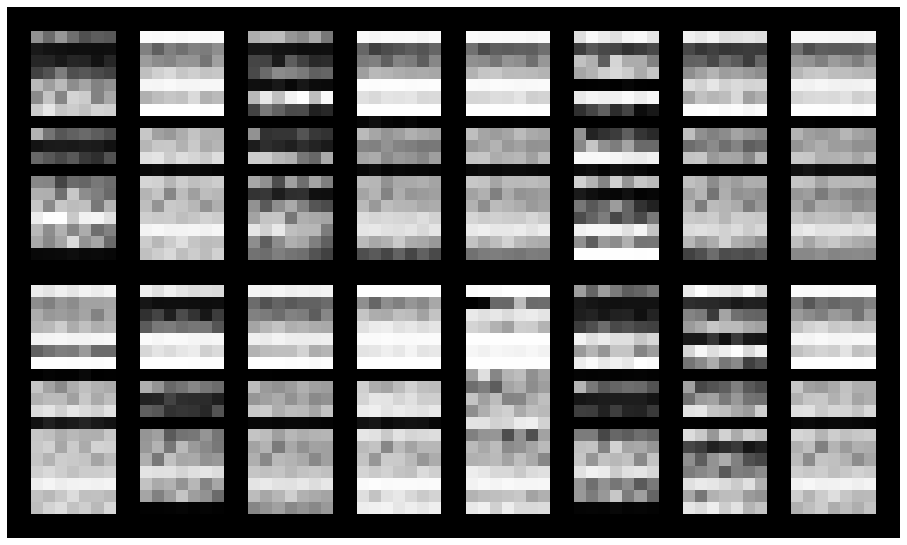

Epoch: [85/200], Batch Num: [0/54]
Discriminator Loss: 0.0290, Generator Loss: 6.6247
D(x): 0.9961, D(G(z)): 0.0061


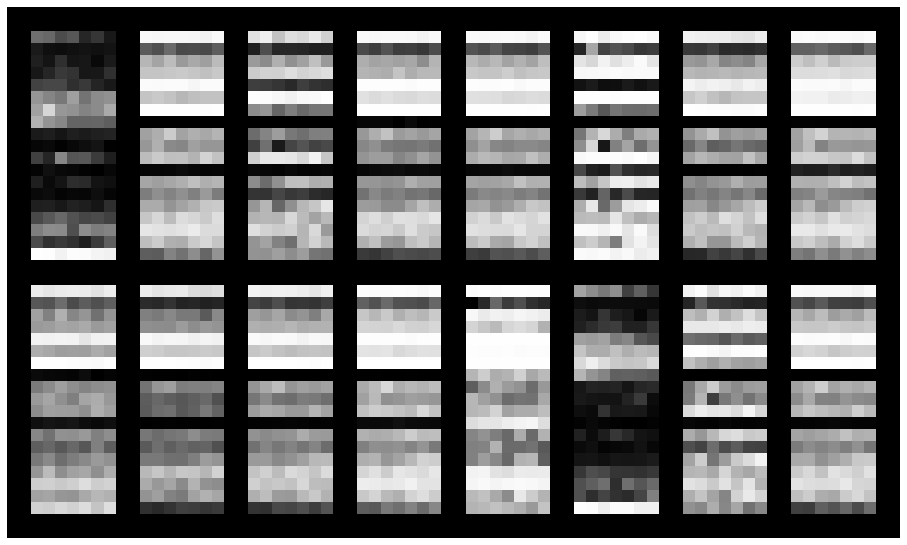

Epoch: [86/200], Batch Num: [0/54]
Discriminator Loss: 0.0531, Generator Loss: 6.1483
D(x): 0.9923, D(G(z)): 0.0099


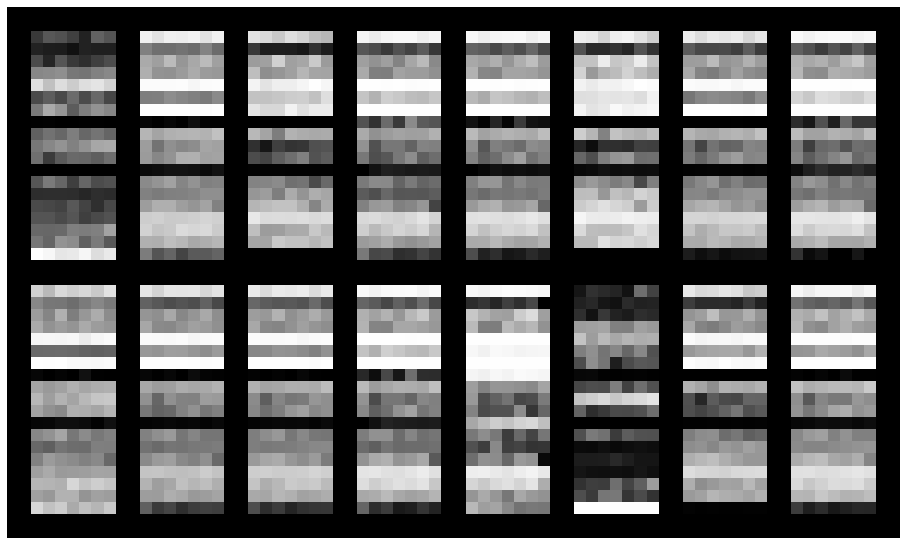

Epoch: [87/200], Batch Num: [0/54]
Discriminator Loss: 0.0258, Generator Loss: 6.8179
D(x): 0.9943, D(G(z)): 0.0064


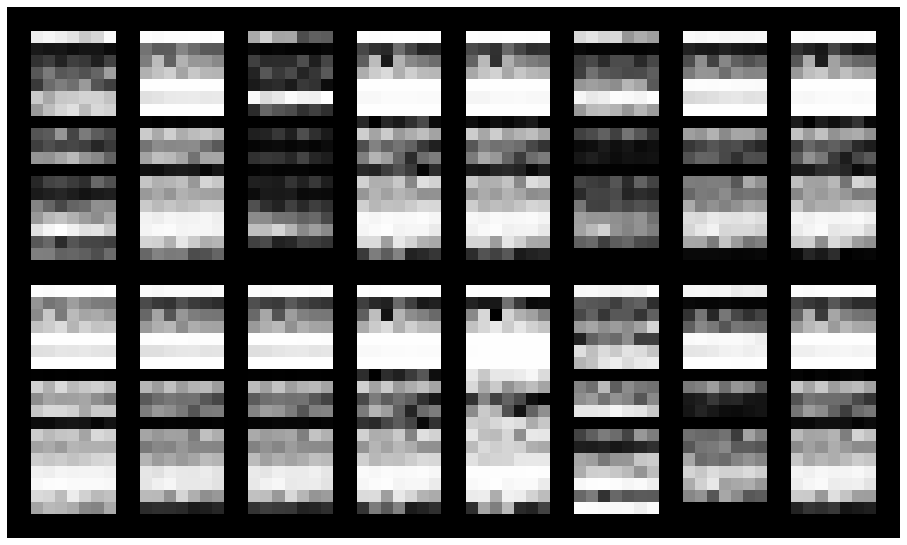

Epoch: [88/200], Batch Num: [0/54]
Discriminator Loss: 0.0095, Generator Loss: 6.1546
D(x): 0.9983, D(G(z)): 0.0061


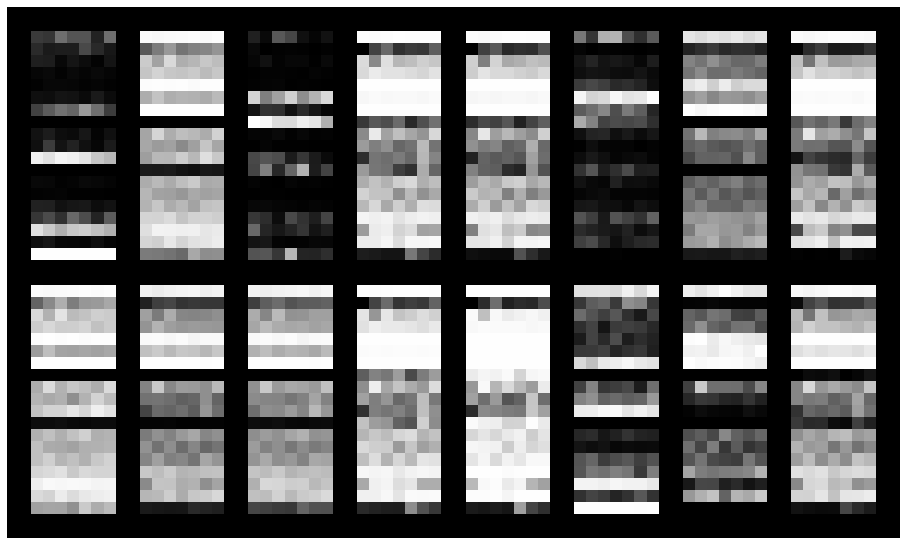

Epoch: [89/200], Batch Num: [0/54]
Discriminator Loss: 0.0632, Generator Loss: 5.9814
D(x): 0.9836, D(G(z)): 0.0069


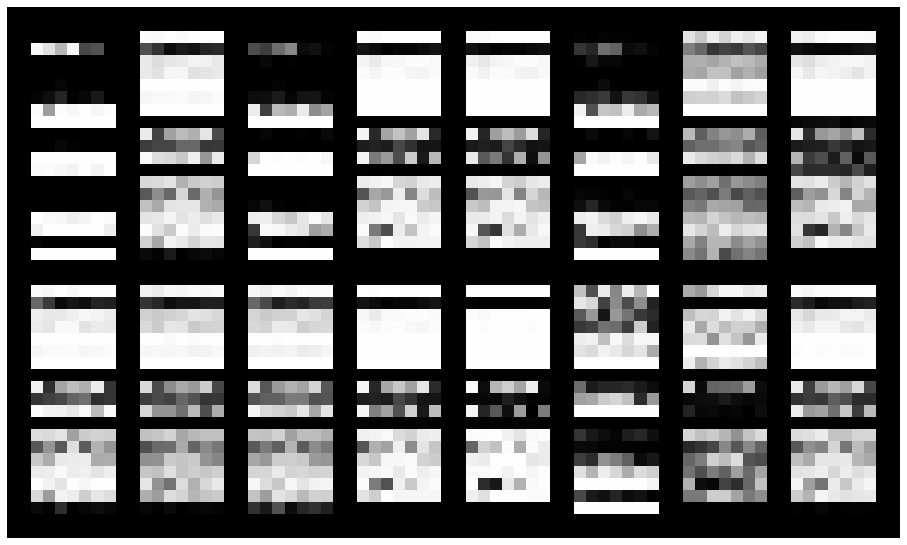

Epoch: [90/200], Batch Num: [0/54]
Discriminator Loss: 0.0265, Generator Loss: 5.7301
D(x): 0.9937, D(G(z)): 0.0063


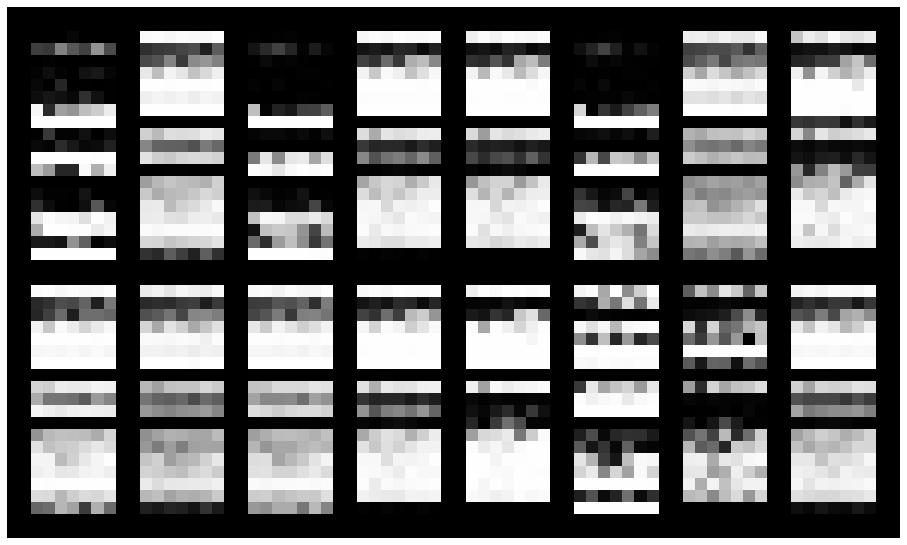

Epoch: [91/200], Batch Num: [0/54]
Discriminator Loss: 0.0474, Generator Loss: 6.2012
D(x): 0.9892, D(G(z)): 0.0046


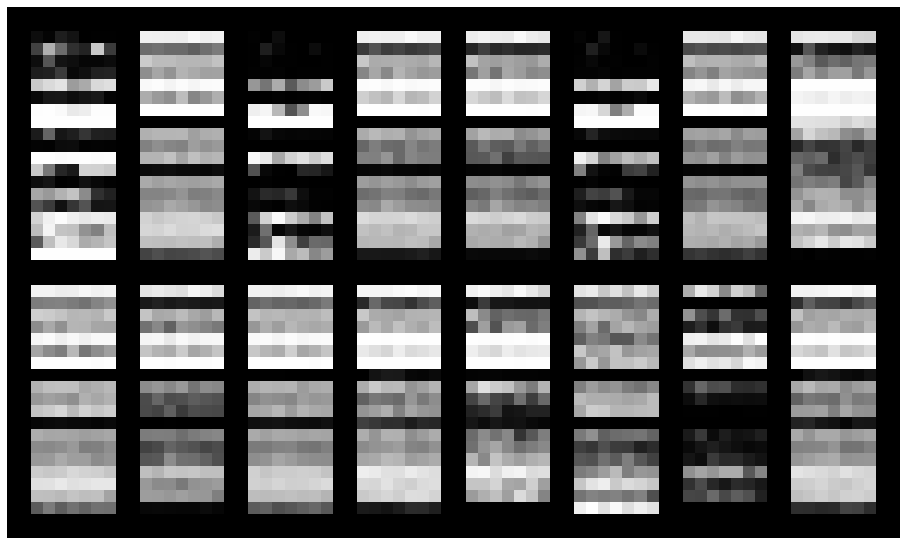

Epoch: [92/200], Batch Num: [0/54]
Discriminator Loss: 0.0513, Generator Loss: 5.9475
D(x): 0.9869, D(G(z)): 0.0067


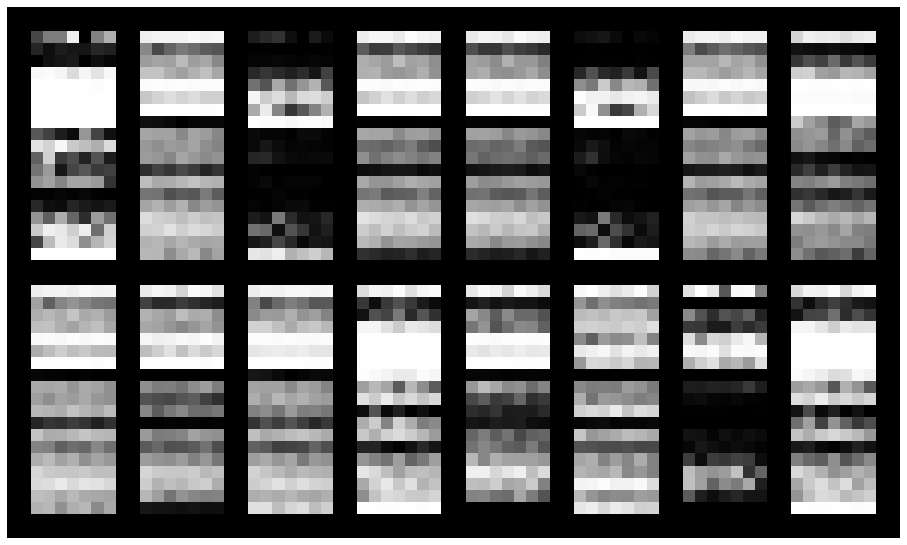

Epoch: [93/200], Batch Num: [0/54]
Discriminator Loss: 0.0747, Generator Loss: 5.6361
D(x): 0.9878, D(G(z)): 0.0138


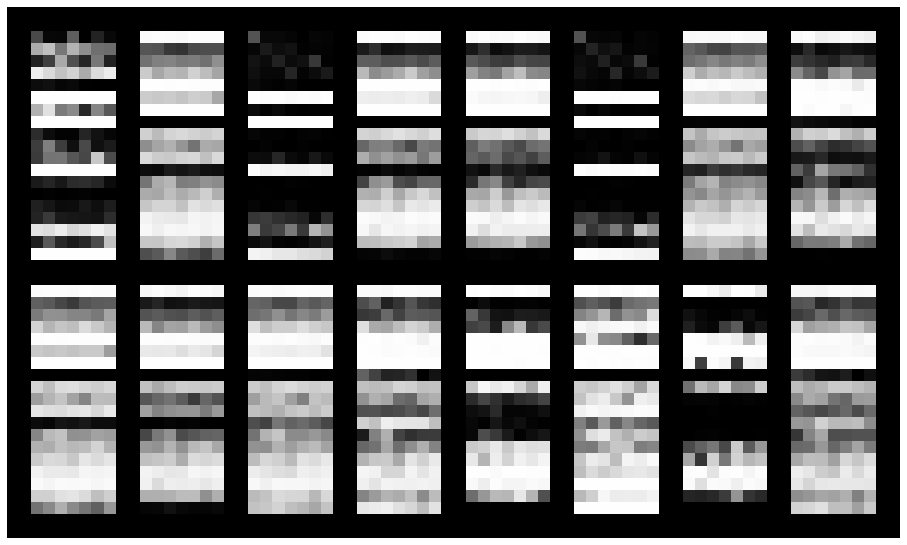

Epoch: [94/200], Batch Num: [0/54]
Discriminator Loss: 0.0402, Generator Loss: 6.5336
D(x): 0.9918, D(G(z)): 0.0033


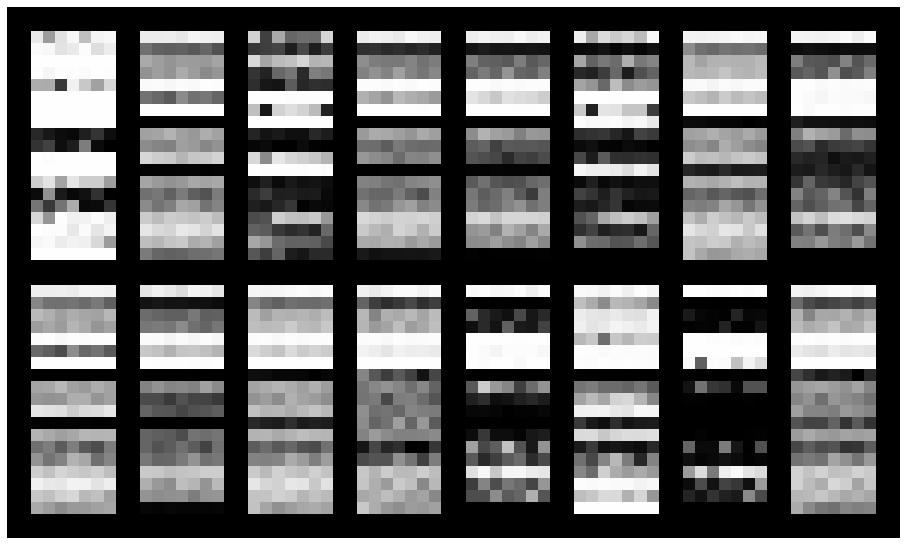

Epoch: [95/200], Batch Num: [0/54]
Discriminator Loss: 0.0676, Generator Loss: 5.4353
D(x): 0.9855, D(G(z)): 0.0128


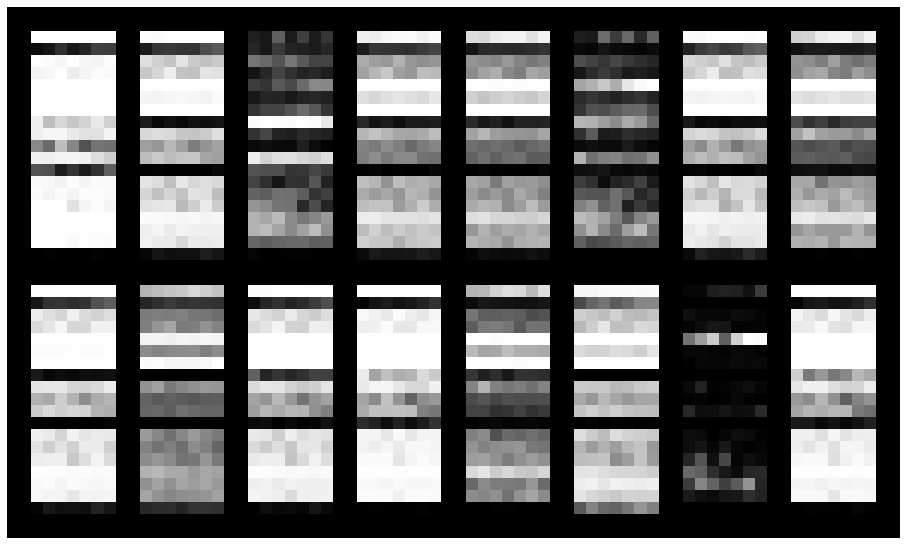

Epoch: [96/200], Batch Num: [0/54]
Discriminator Loss: 0.0517, Generator Loss: 5.3292
D(x): 0.9901, D(G(z)): 0.0103


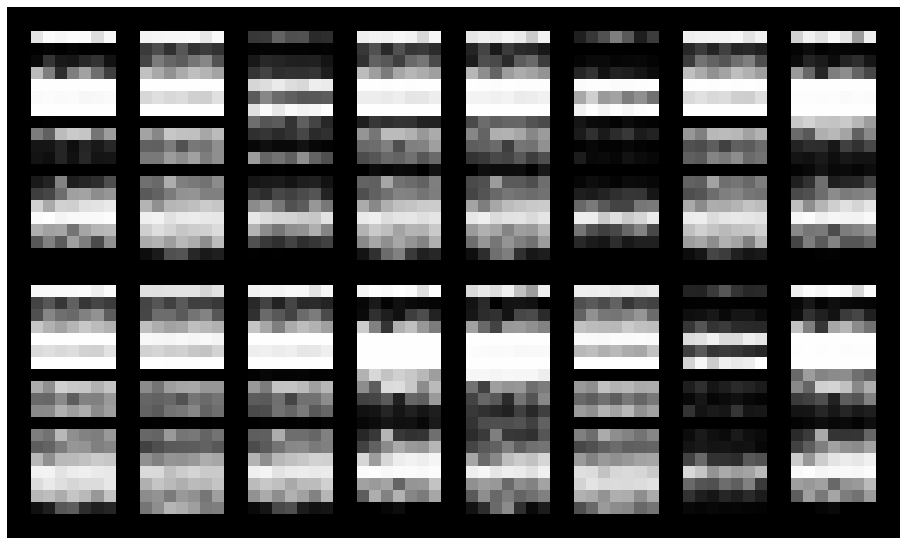

Epoch: [97/200], Batch Num: [0/54]
Discriminator Loss: 0.0280, Generator Loss: 6.5299
D(x): 0.9923, D(G(z)): 0.0030


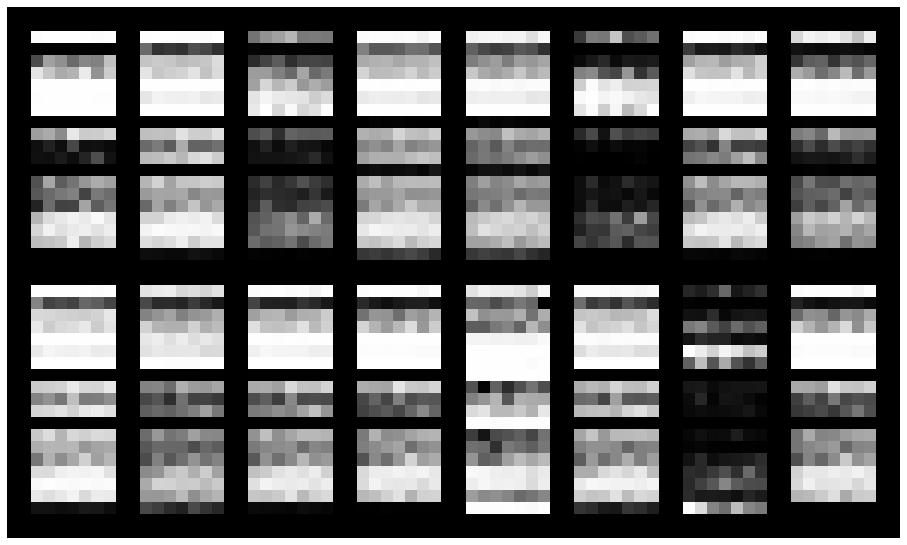

Epoch: [98/200], Batch Num: [0/54]
Discriminator Loss: 0.0198, Generator Loss: 6.2370
D(x): 0.9971, D(G(z)): 0.0072


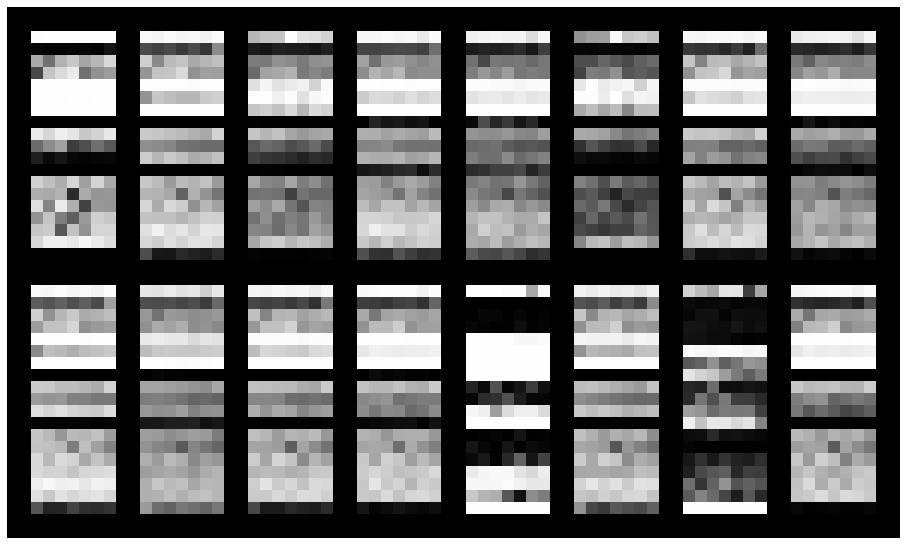

Epoch: [99/200], Batch Num: [0/54]
Discriminator Loss: 0.0227, Generator Loss: 6.1908
D(x): 0.9932, D(G(z)): 0.0061


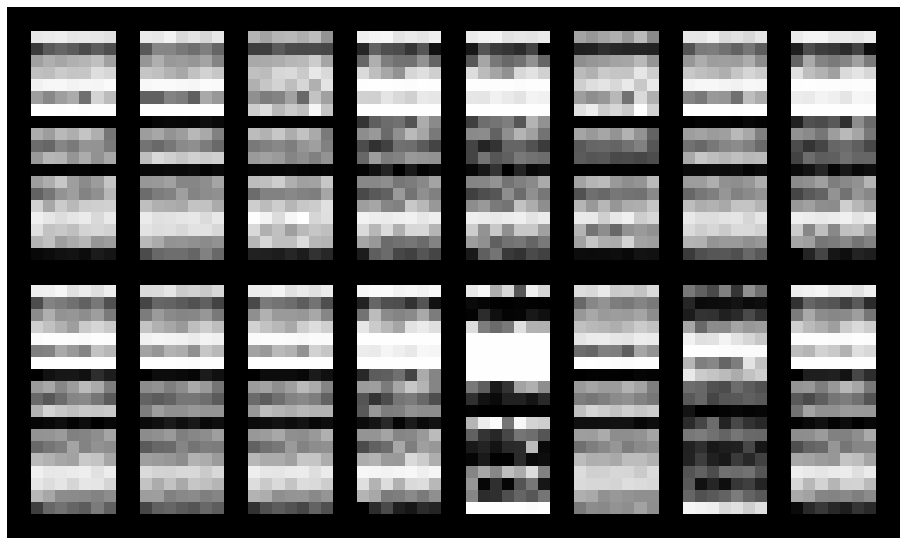

Epoch: [100/200], Batch Num: [0/54]
Discriminator Loss: 0.0563, Generator Loss: 6.0972
D(x): 0.9877, D(G(z)): 0.0078


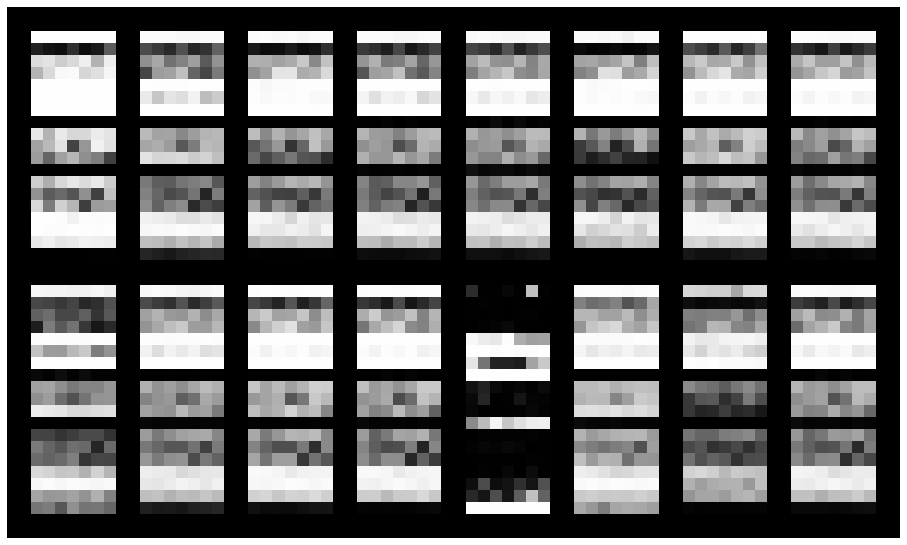

Epoch: [101/200], Batch Num: [0/54]
Discriminator Loss: 0.0421, Generator Loss: 6.3500
D(x): 0.9931, D(G(z)): 0.0033


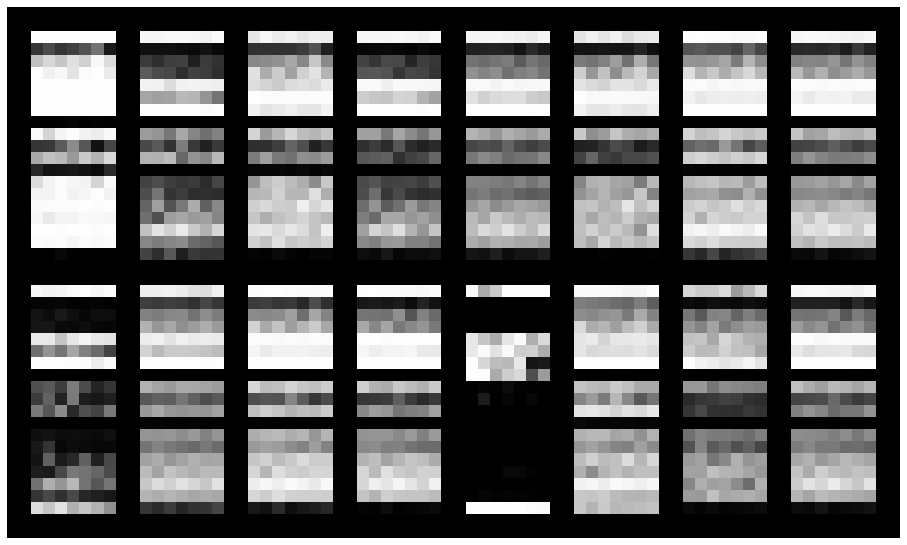

Epoch: [102/200], Batch Num: [0/54]
Discriminator Loss: 0.0214, Generator Loss: 7.5114
D(x): 0.9948, D(G(z)): 0.0012


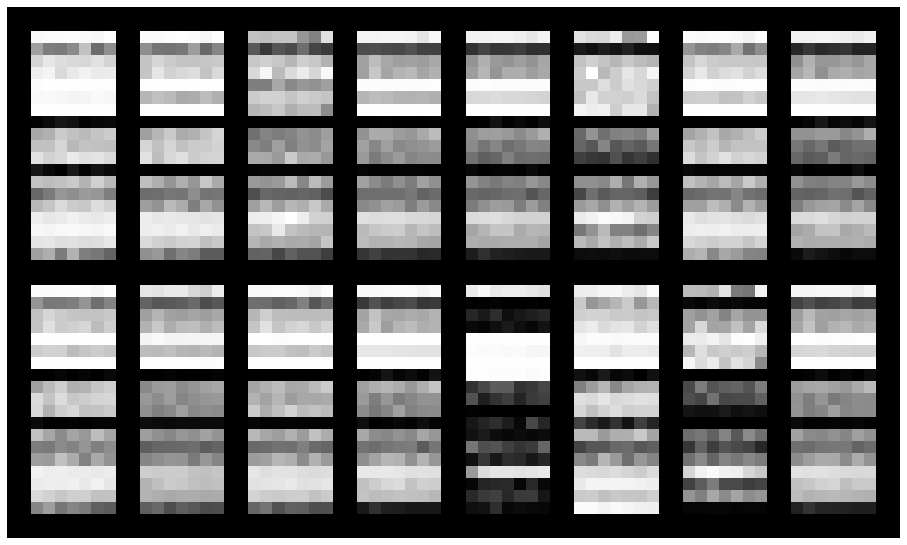

Epoch: [103/200], Batch Num: [0/54]
Discriminator Loss: 0.0110, Generator Loss: 6.4525
D(x): 0.9980, D(G(z)): 0.0069


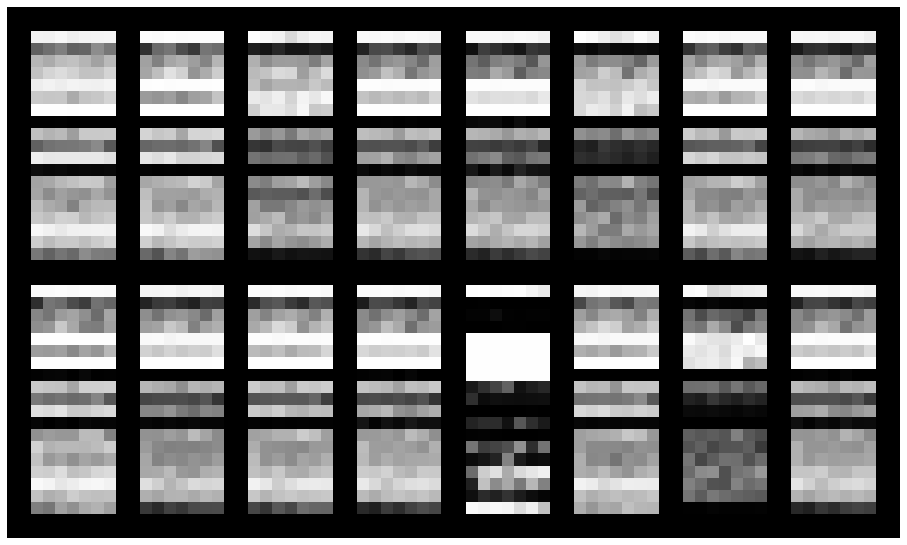

Epoch: [104/200], Batch Num: [0/54]
Discriminator Loss: 0.0556, Generator Loss: 5.8133
D(x): 0.9918, D(G(z)): 0.0081


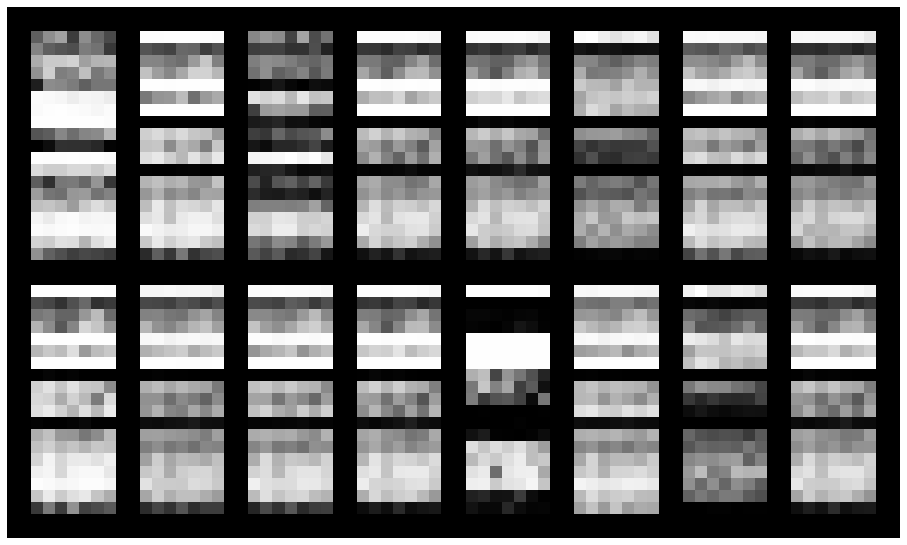

Epoch: [105/200], Batch Num: [0/54]
Discriminator Loss: 0.0428, Generator Loss: 5.9920
D(x): 0.9915, D(G(z)): 0.0070


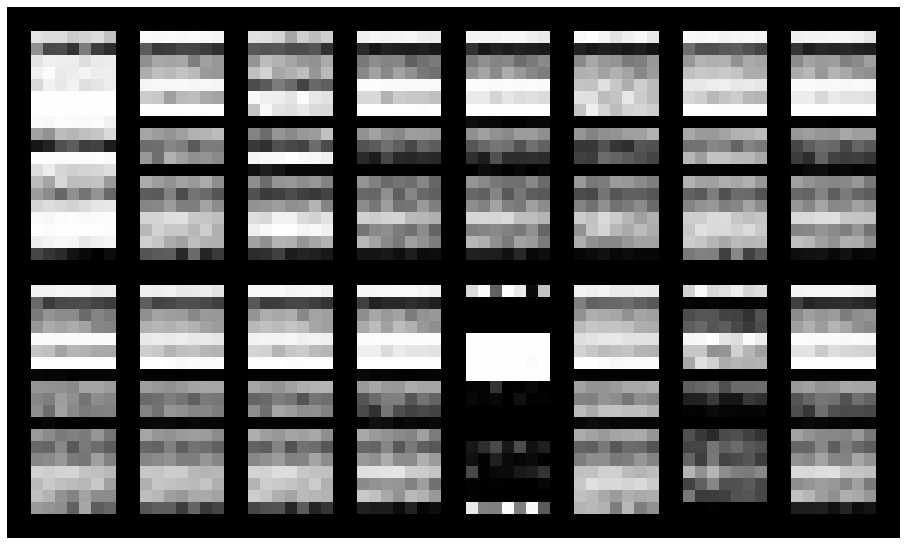

Epoch: [106/200], Batch Num: [0/54]
Discriminator Loss: 0.0099, Generator Loss: 6.0712
D(x): 0.9978, D(G(z)): 0.0049


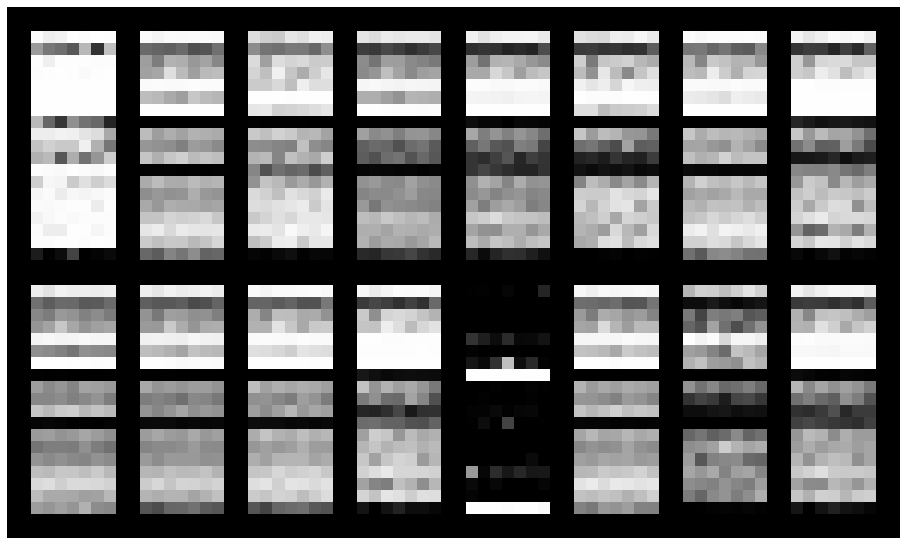

Epoch: [107/200], Batch Num: [0/54]
Discriminator Loss: 0.0613, Generator Loss: 5.8922
D(x): 0.9874, D(G(z)): 0.0063


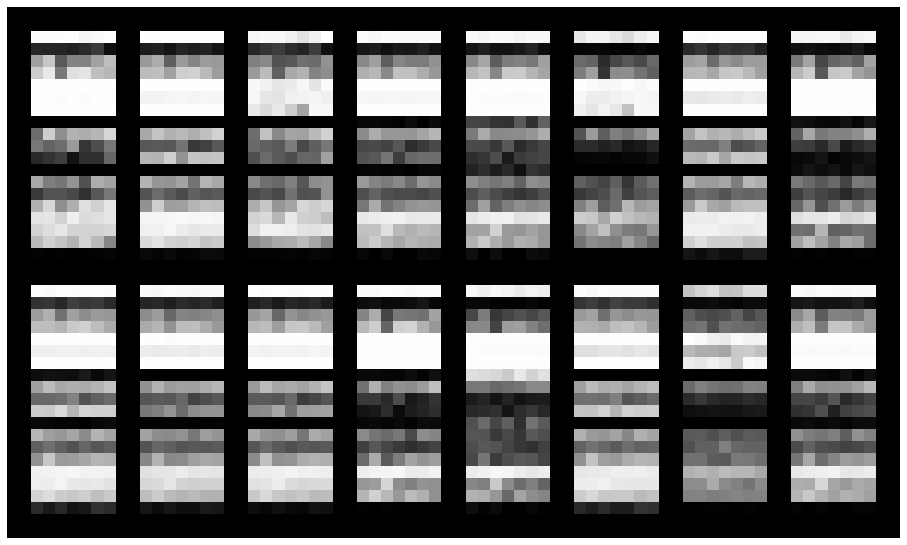

Epoch: [108/200], Batch Num: [0/54]
Discriminator Loss: 0.0292, Generator Loss: 5.7253
D(x): 0.9961, D(G(z)): 0.0113


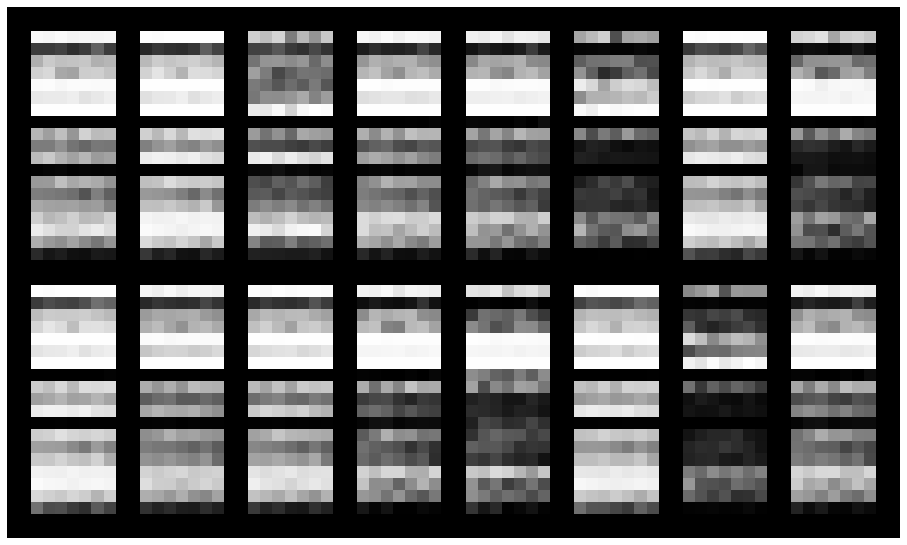

Epoch: [109/200], Batch Num: [0/54]
Discriminator Loss: 0.0373, Generator Loss: 6.1211
D(x): 0.9891, D(G(z)): 0.0055


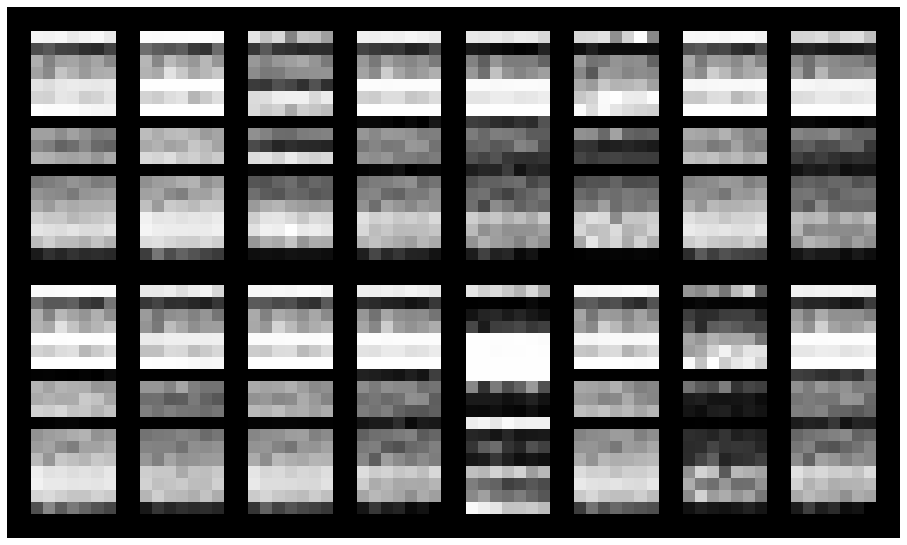

Epoch: [110/200], Batch Num: [0/54]
Discriminator Loss: 0.0395, Generator Loss: 5.6279
D(x): 0.9932, D(G(z)): 0.0092


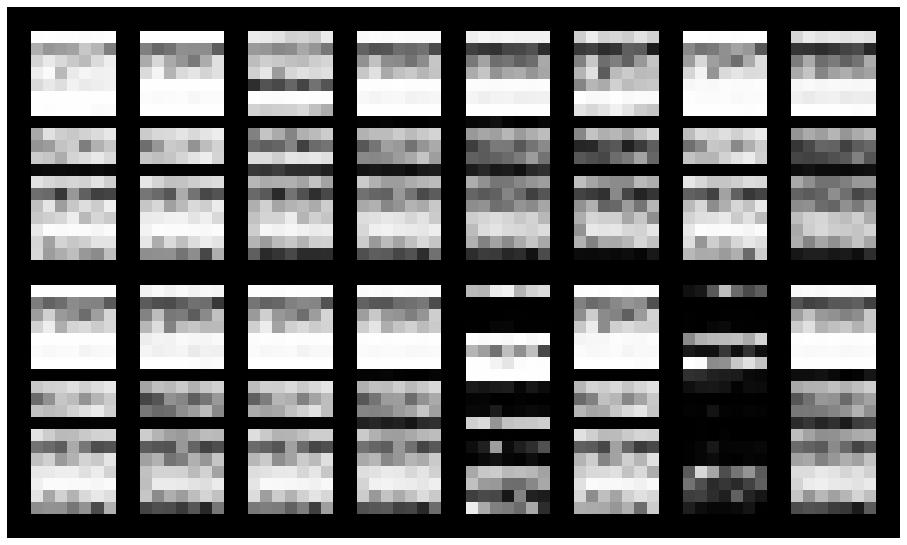

Epoch: [111/200], Batch Num: [0/54]
Discriminator Loss: 0.0152, Generator Loss: 7.0237
D(x): 0.9963, D(G(z)): 0.0040


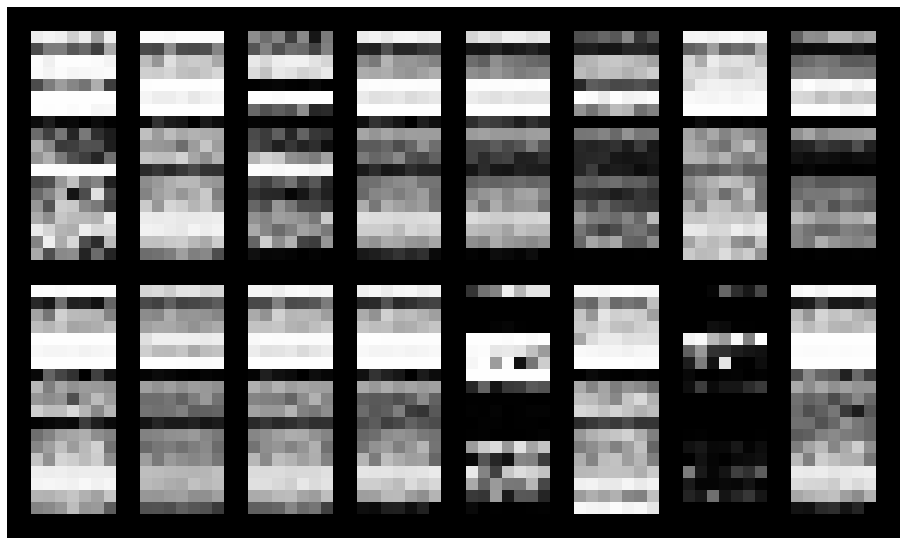

Epoch: [112/200], Batch Num: [0/54]
Discriminator Loss: 0.0550, Generator Loss: 6.0612
D(x): 0.9900, D(G(z)): 0.0090


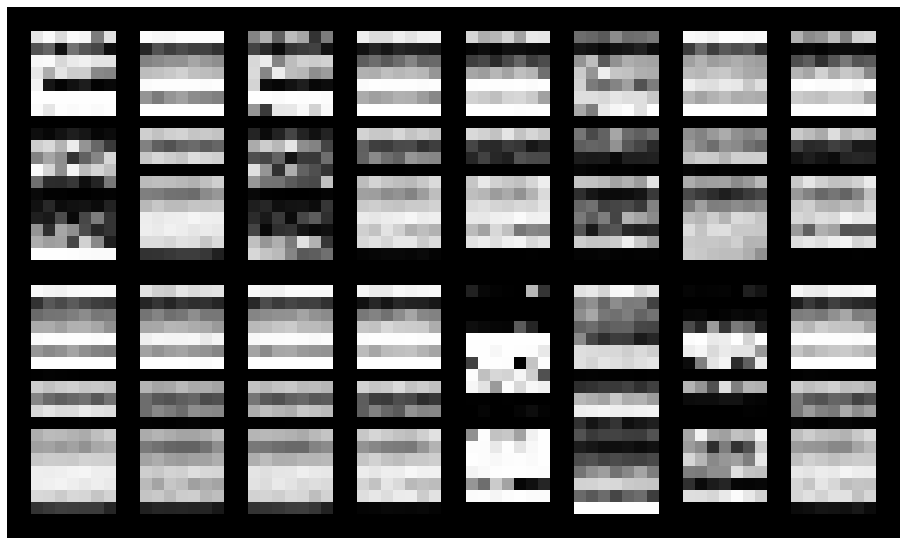

Epoch: [113/200], Batch Num: [0/54]
Discriminator Loss: 0.0702, Generator Loss: 6.0177
D(x): 0.9842, D(G(z)): 0.0082


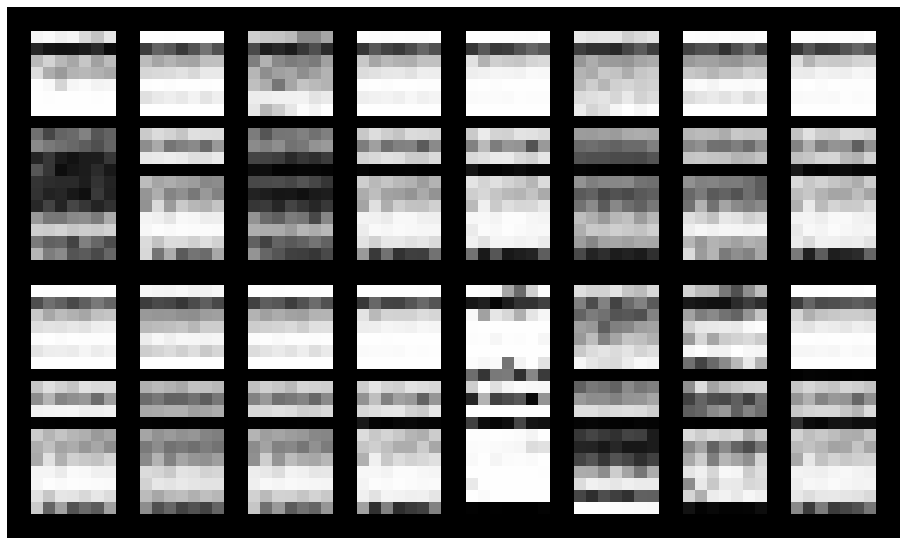

Epoch: [114/200], Batch Num: [0/54]
Discriminator Loss: 0.0264, Generator Loss: 6.5644
D(x): 0.9953, D(G(z)): 0.0062


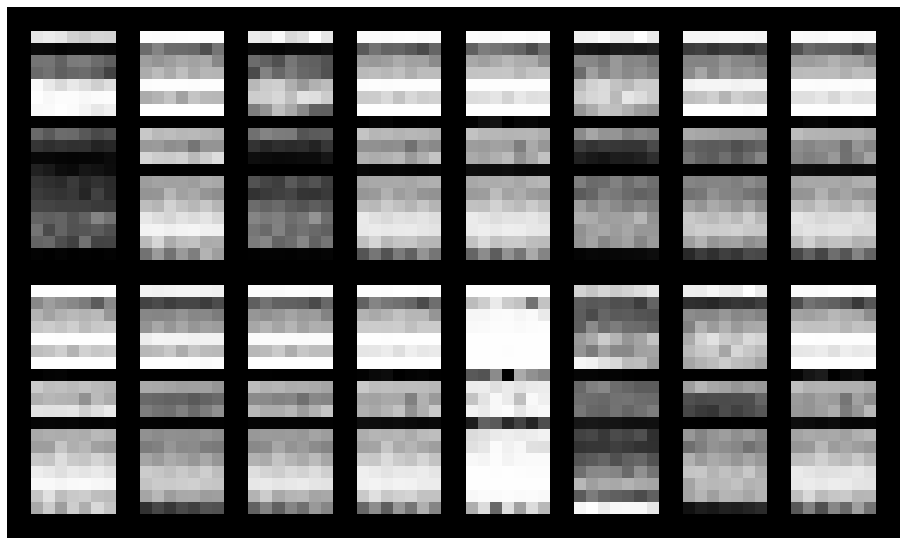

Epoch: [115/200], Batch Num: [0/54]
Discriminator Loss: 0.0312, Generator Loss: 5.5655
D(x): 0.9910, D(G(z)): 0.0080


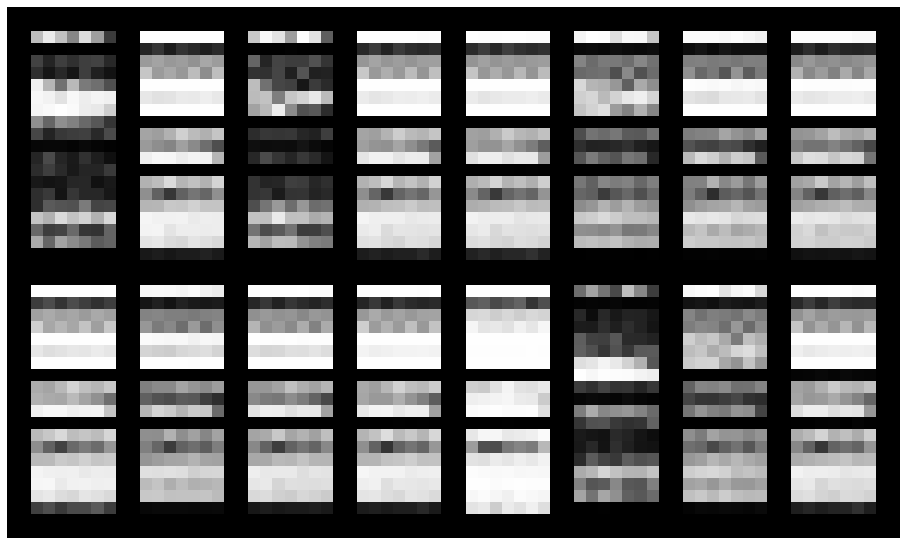

Epoch: [116/200], Batch Num: [0/54]
Discriminator Loss: 0.0541, Generator Loss: 6.1384
D(x): 0.9914, D(G(z)): 0.0075


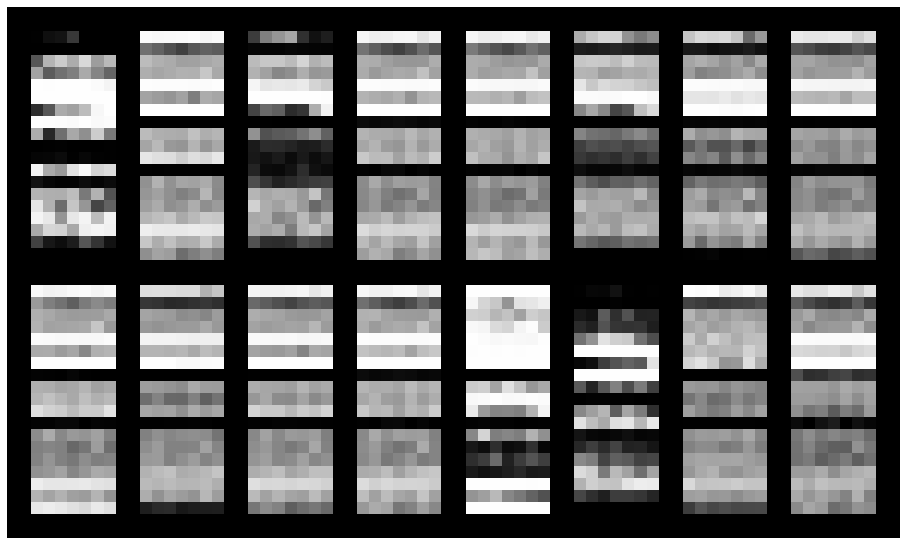

Epoch: [117/200], Batch Num: [0/54]
Discriminator Loss: 0.0190, Generator Loss: 6.3874
D(x): 0.9955, D(G(z)): 0.0081


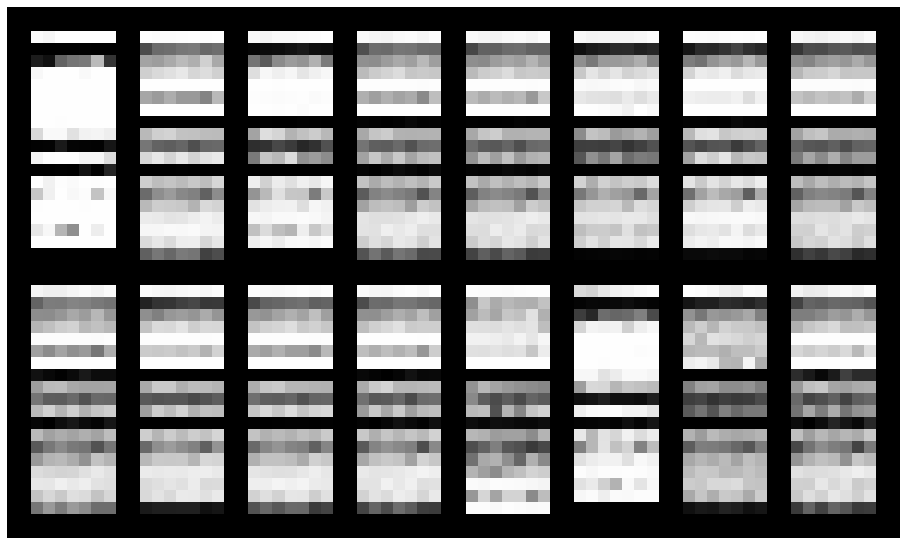

Epoch: [118/200], Batch Num: [0/54]
Discriminator Loss: 0.0237, Generator Loss: 6.2670
D(x): 0.9949, D(G(z)): 0.0041


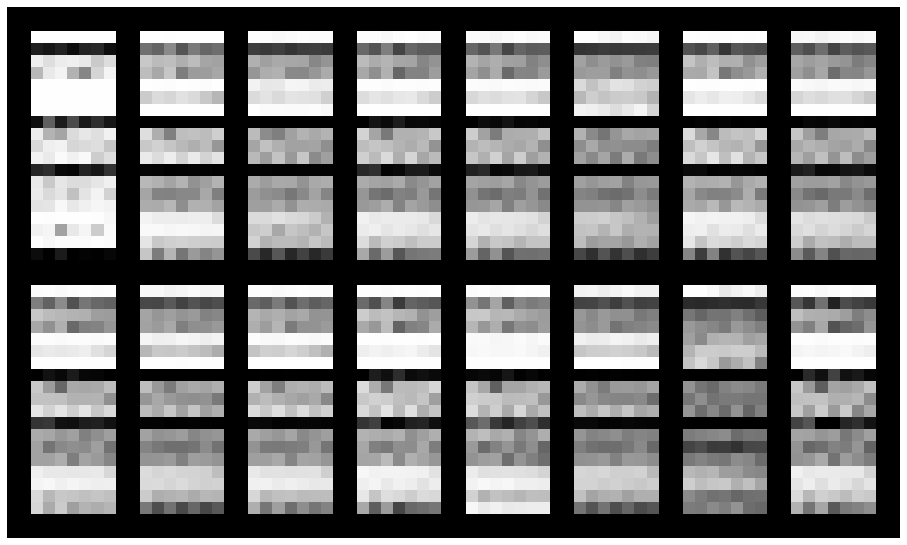

Epoch: [119/200], Batch Num: [0/54]
Discriminator Loss: 0.0144, Generator Loss: 5.8215
D(x): 0.9978, D(G(z)): 0.0082


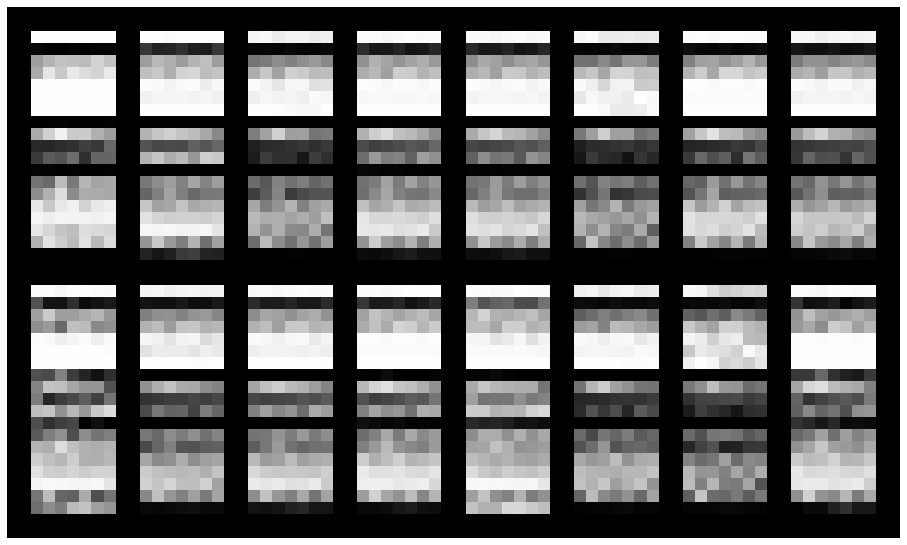

Epoch: [120/200], Batch Num: [0/54]
Discriminator Loss: 0.0208, Generator Loss: 5.7338
D(x): 0.9964, D(G(z)): 0.0095


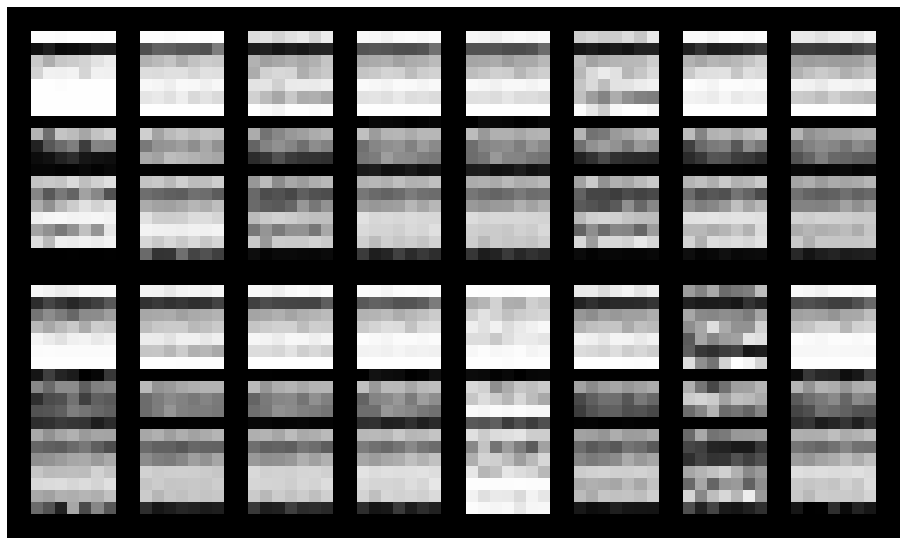

Epoch: [121/200], Batch Num: [0/54]
Discriminator Loss: 0.0164, Generator Loss: 6.1160
D(x): 0.9963, D(G(z)): 0.0057


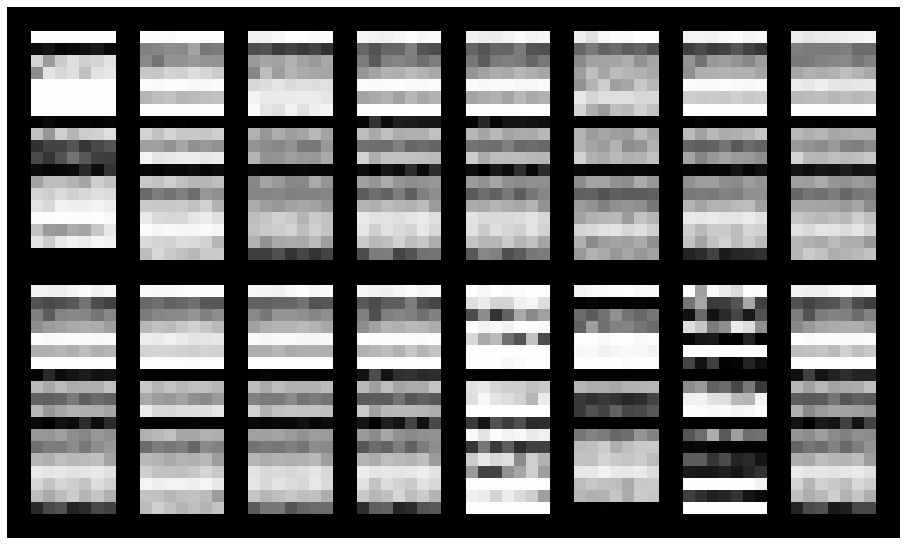

Epoch: [122/200], Batch Num: [0/54]
Discriminator Loss: 0.0592, Generator Loss: 6.3277
D(x): 0.9900, D(G(z)): 0.0110


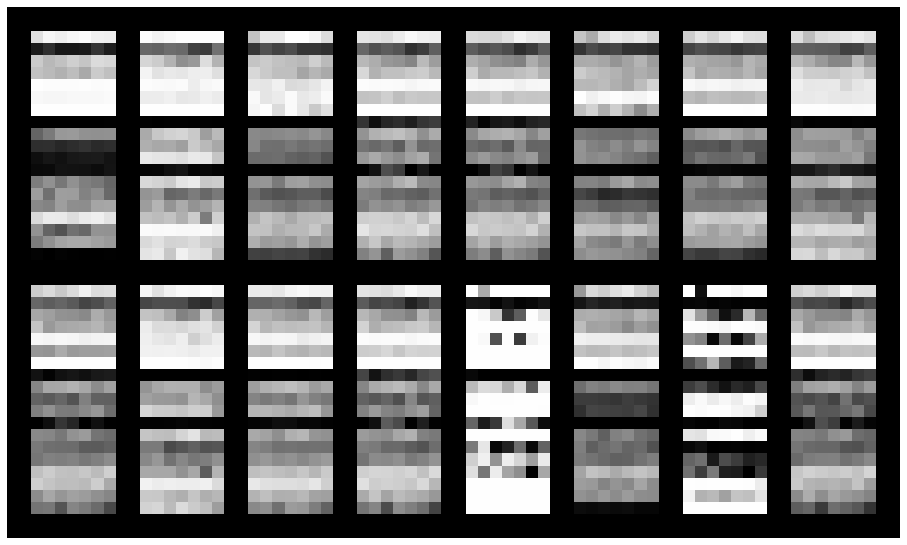

Epoch: [123/200], Batch Num: [0/54]
Discriminator Loss: 0.0206, Generator Loss: 5.9525
D(x): 0.9962, D(G(z)): 0.0058


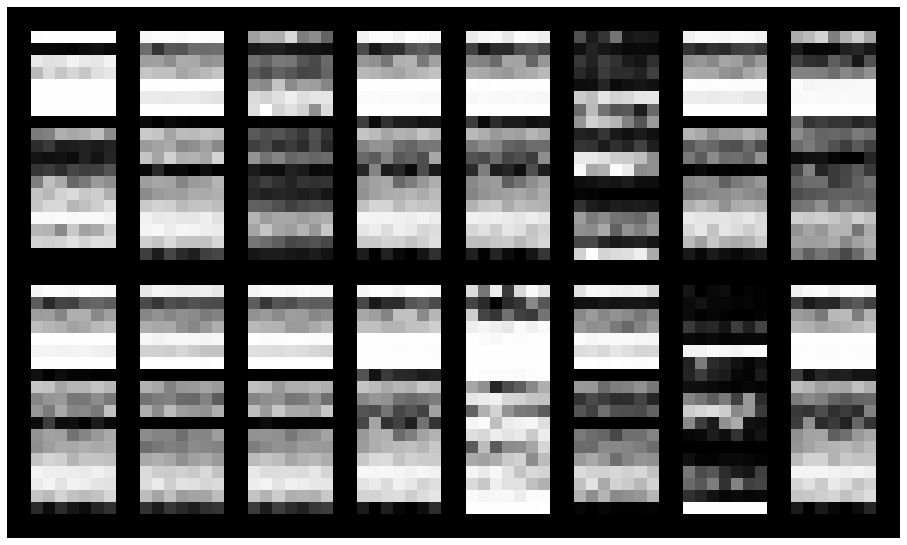

Epoch: [124/200], Batch Num: [0/54]
Discriminator Loss: 0.0102, Generator Loss: 6.0604
D(x): 0.9971, D(G(z)): 0.0056


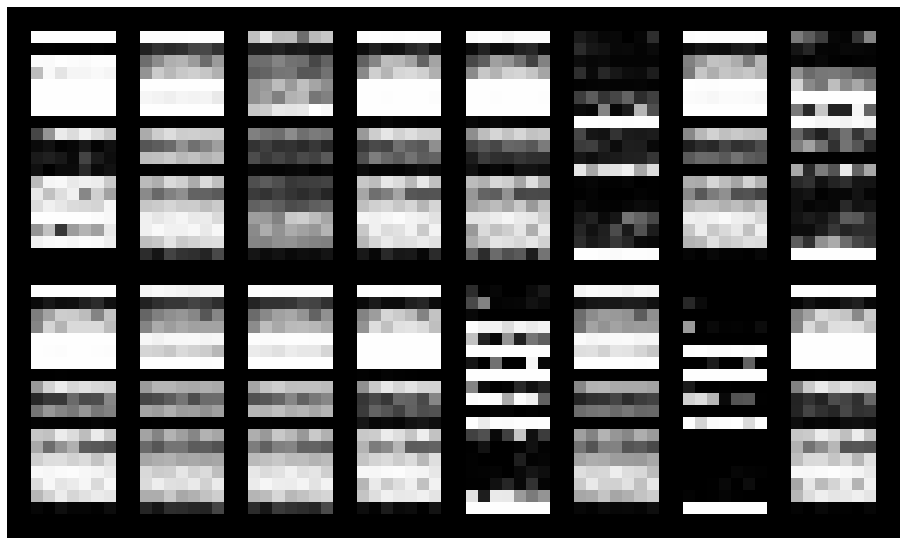

Epoch: [125/200], Batch Num: [0/54]
Discriminator Loss: 0.0080, Generator Loss: 6.9087
D(x): 0.9975, D(G(z)): 0.0028


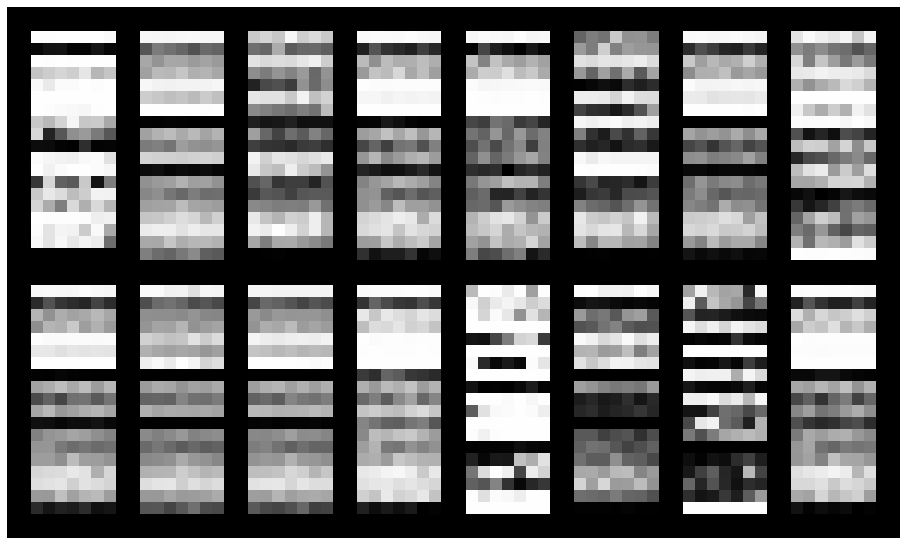

Epoch: [126/200], Batch Num: [0/54]
Discriminator Loss: 0.0250, Generator Loss: 5.8987
D(x): 0.9951, D(G(z)): 0.0068


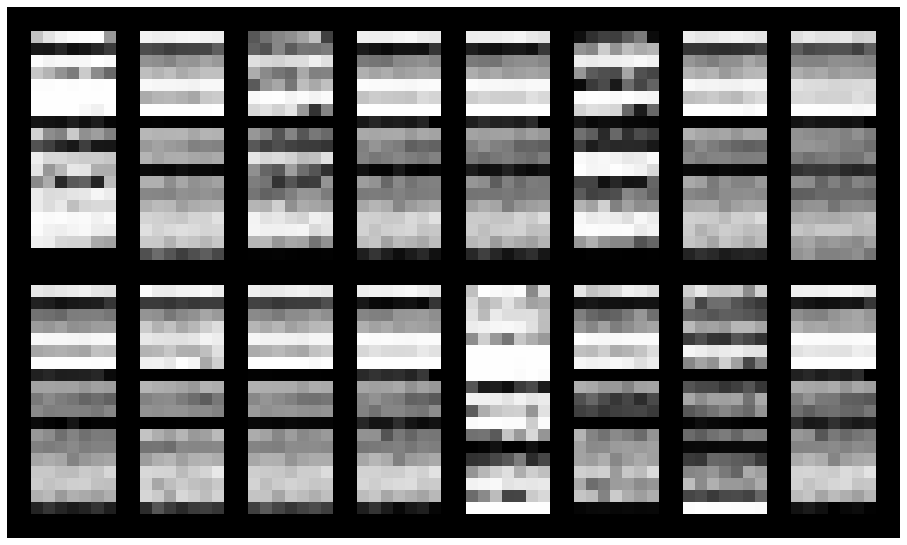

Epoch: [127/200], Batch Num: [0/54]
Discriminator Loss: 0.0078, Generator Loss: 6.0160
D(x): 0.9997, D(G(z)): 0.0068


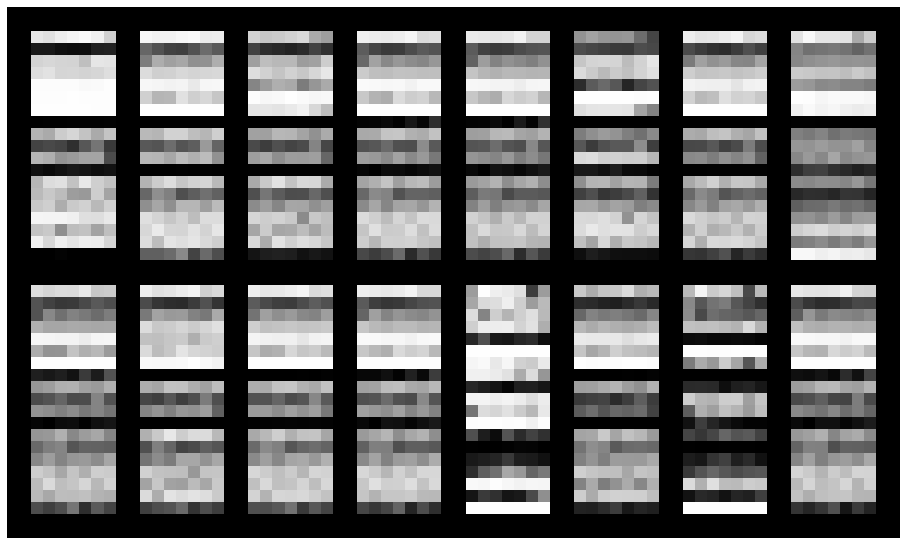

Epoch: [128/200], Batch Num: [0/54]
Discriminator Loss: 0.0279, Generator Loss: 6.1143
D(x): 0.9929, D(G(z)): 0.0031


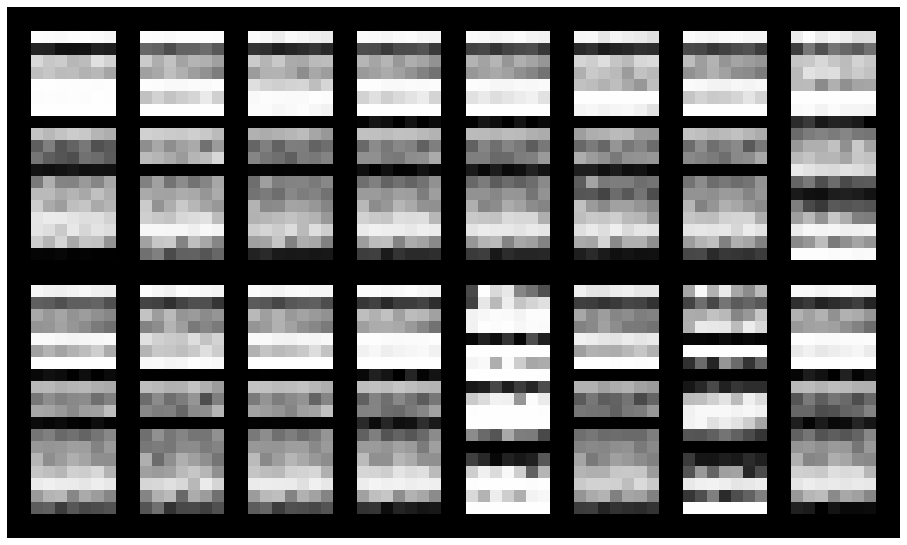

Epoch: [129/200], Batch Num: [0/54]
Discriminator Loss: 0.0171, Generator Loss: 6.1135
D(x): 0.9961, D(G(z)): 0.0049


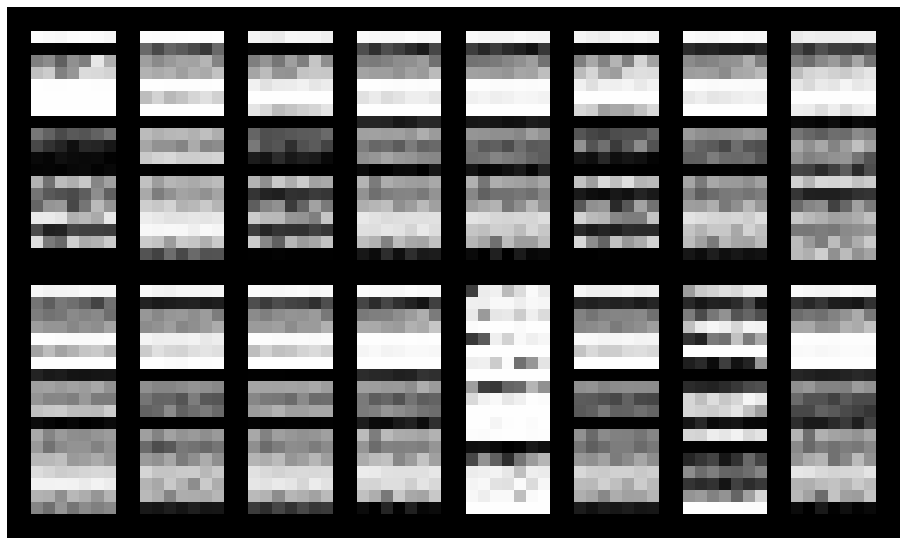

Epoch: [130/200], Batch Num: [0/54]
Discriminator Loss: 0.0565, Generator Loss: 5.6460
D(x): 0.9873, D(G(z)): 0.0046


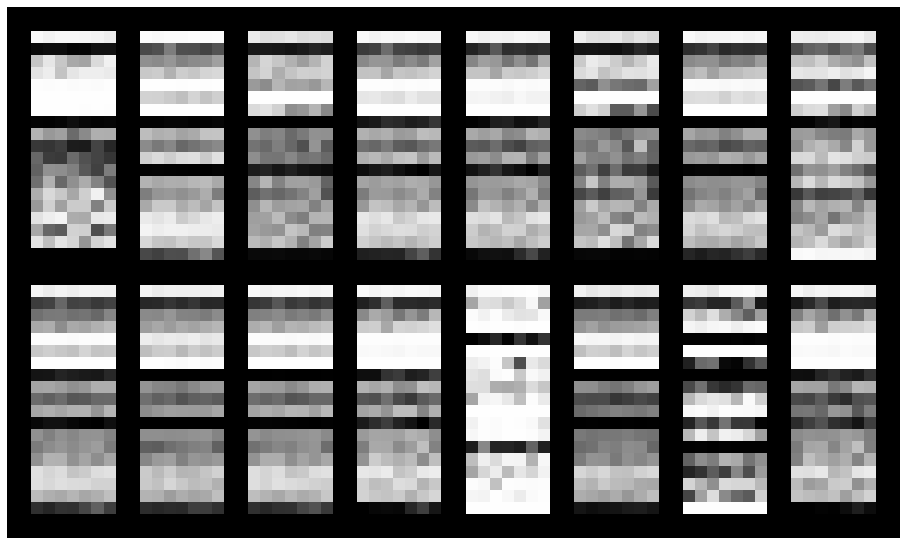

Epoch: [131/200], Batch Num: [0/54]
Discriminator Loss: 0.0370, Generator Loss: 6.8472
D(x): 0.9915, D(G(z)): 0.0026


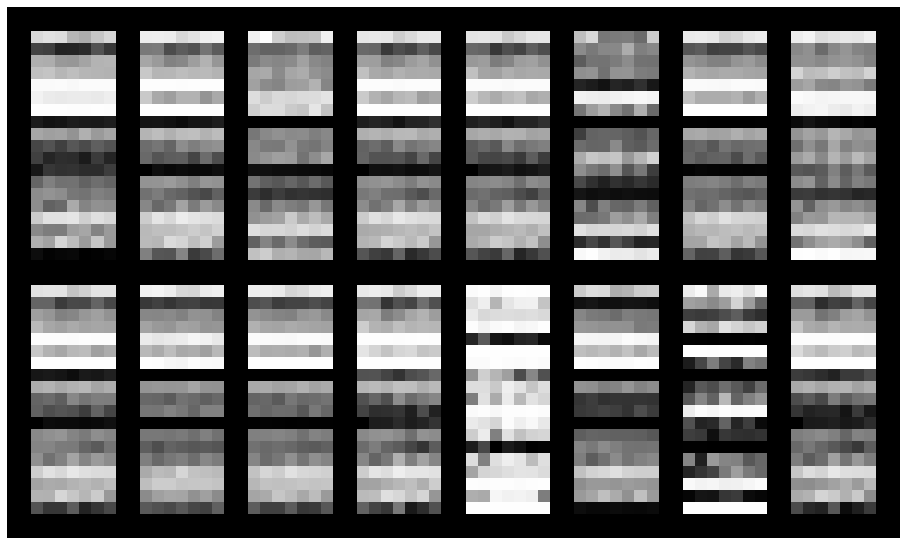

Epoch: [132/200], Batch Num: [0/54]
Discriminator Loss: 0.0120, Generator Loss: 6.0266
D(x): 0.9978, D(G(z)): 0.0082


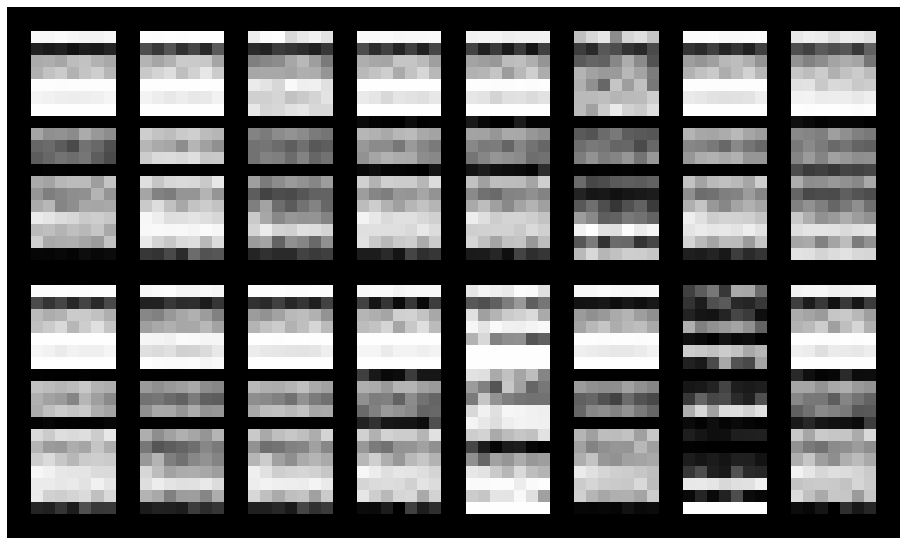

Epoch: [133/200], Batch Num: [0/54]
Discriminator Loss: 0.0262, Generator Loss: 6.3072
D(x): 0.9936, D(G(z)): 0.0029


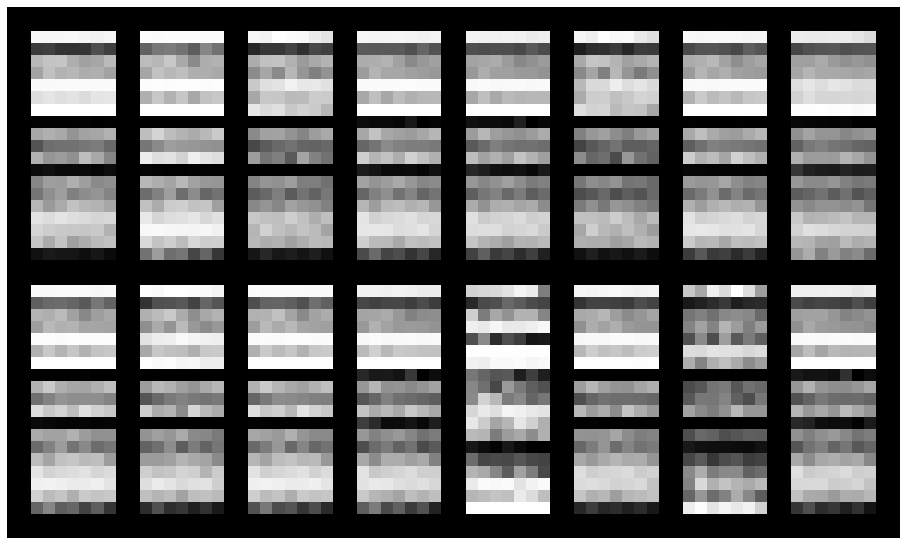

Epoch: [134/200], Batch Num: [0/54]
Discriminator Loss: 0.0352, Generator Loss: 5.6178
D(x): 0.9941, D(G(z)): 0.0059


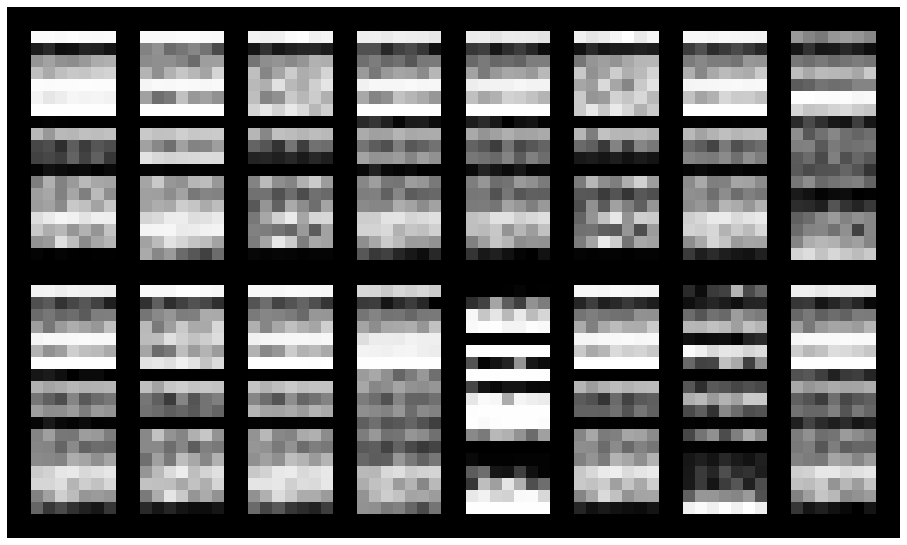

Epoch: [135/200], Batch Num: [0/54]
Discriminator Loss: 0.0490, Generator Loss: 5.7736
D(x): 0.9917, D(G(z)): 0.0085


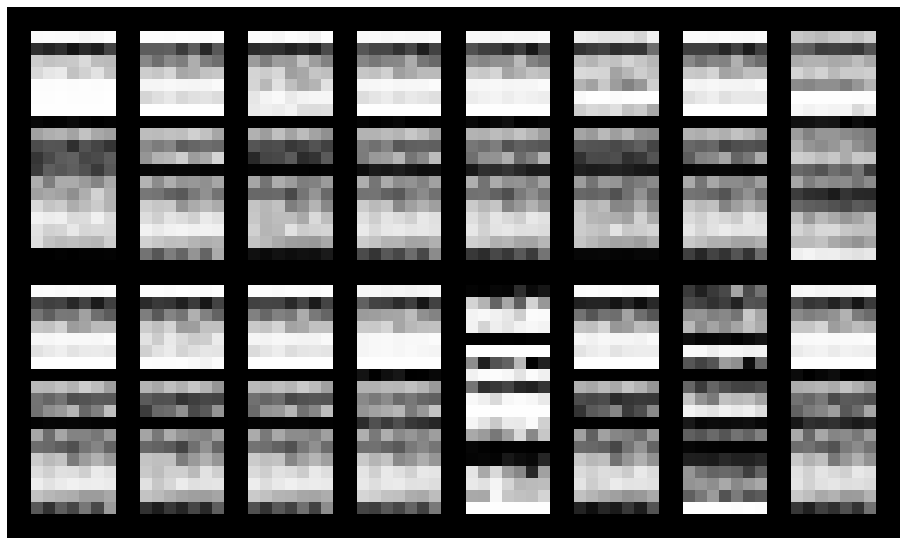

Epoch: [136/200], Batch Num: [0/54]
Discriminator Loss: 0.0240, Generator Loss: 5.6684
D(x): 0.9967, D(G(z)): 0.0065


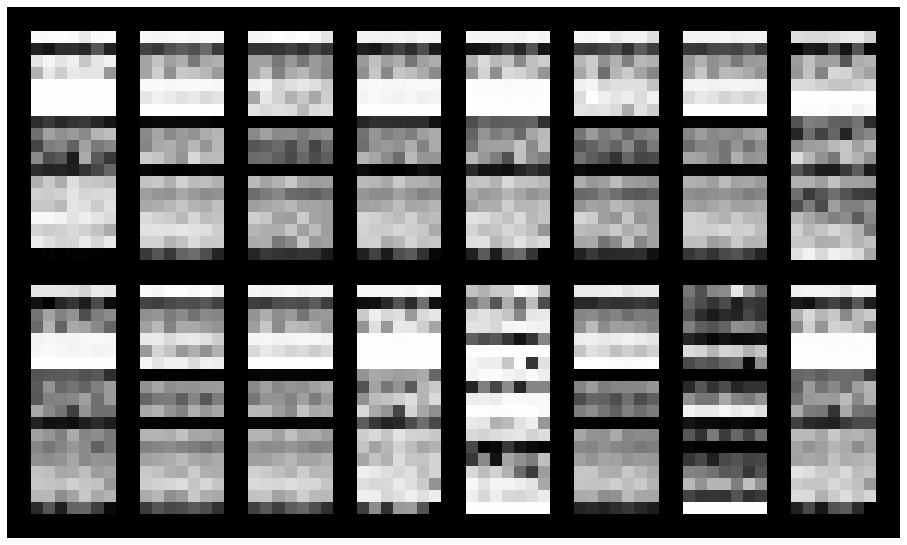

Epoch: [137/200], Batch Num: [0/54]
Discriminator Loss: 0.0524, Generator Loss: 6.2738
D(x): 0.9887, D(G(z)): 0.0030


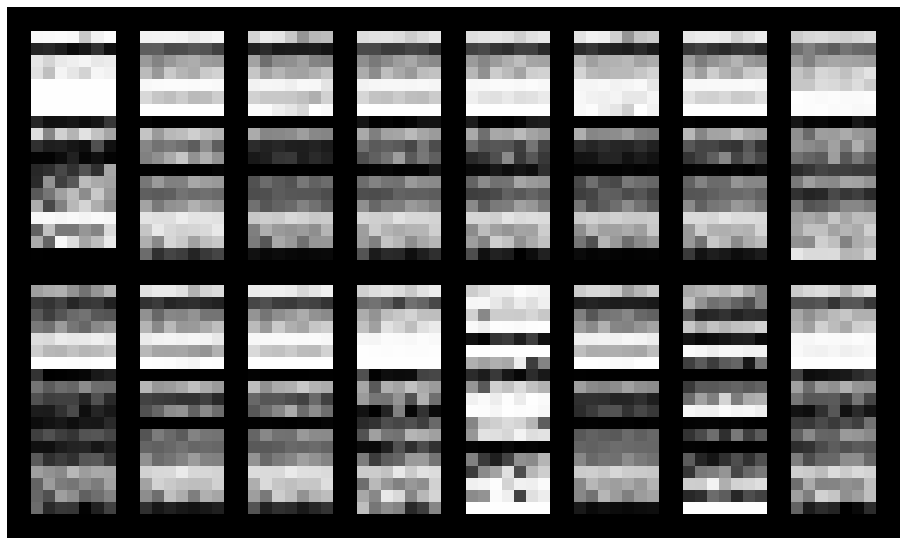

Epoch: [138/200], Batch Num: [0/54]
Discriminator Loss: 0.0024, Generator Loss: 6.4645
D(x): 0.9997, D(G(z)): 0.0021


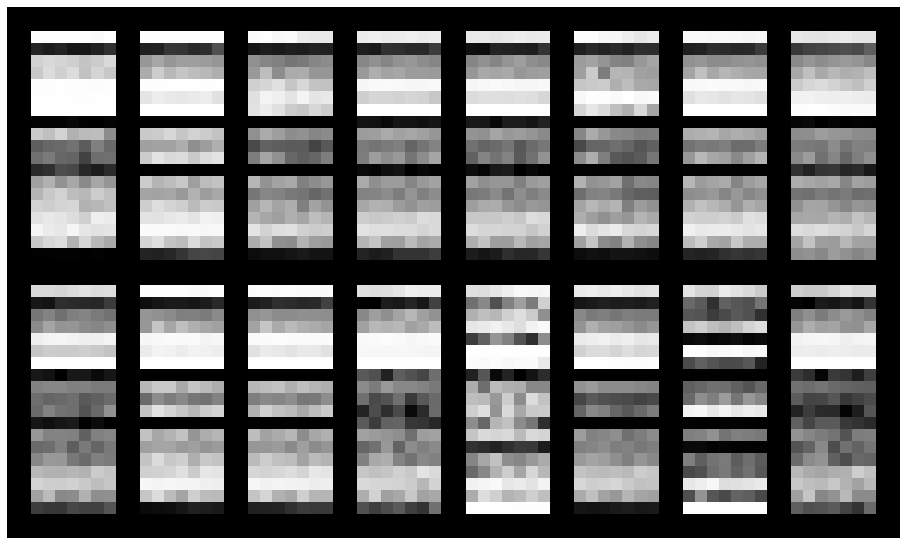

Epoch: [139/200], Batch Num: [0/54]
Discriminator Loss: 0.0195, Generator Loss: 6.5142
D(x): 0.9957, D(G(z)): 0.0029


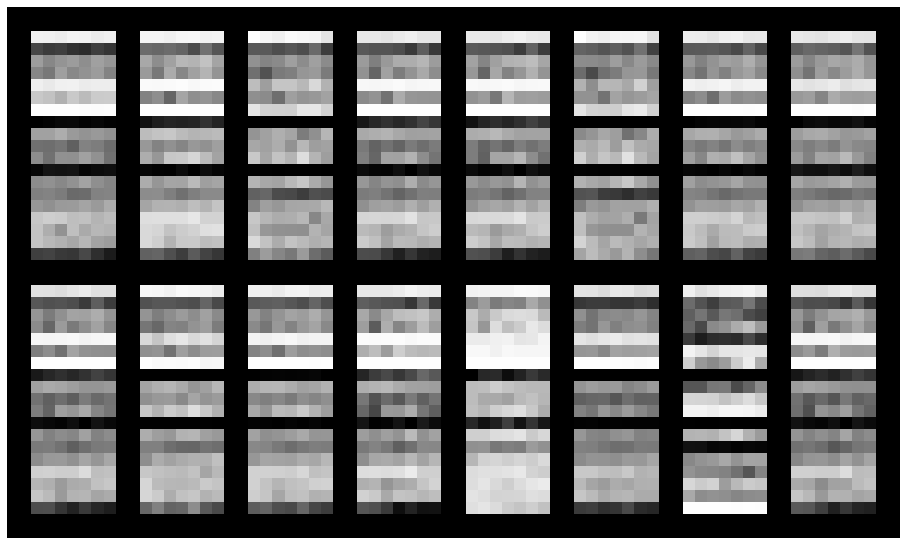

Epoch: [140/200], Batch Num: [0/54]
Discriminator Loss: 0.0095, Generator Loss: 6.1614
D(x): 0.9977, D(G(z)): 0.0055


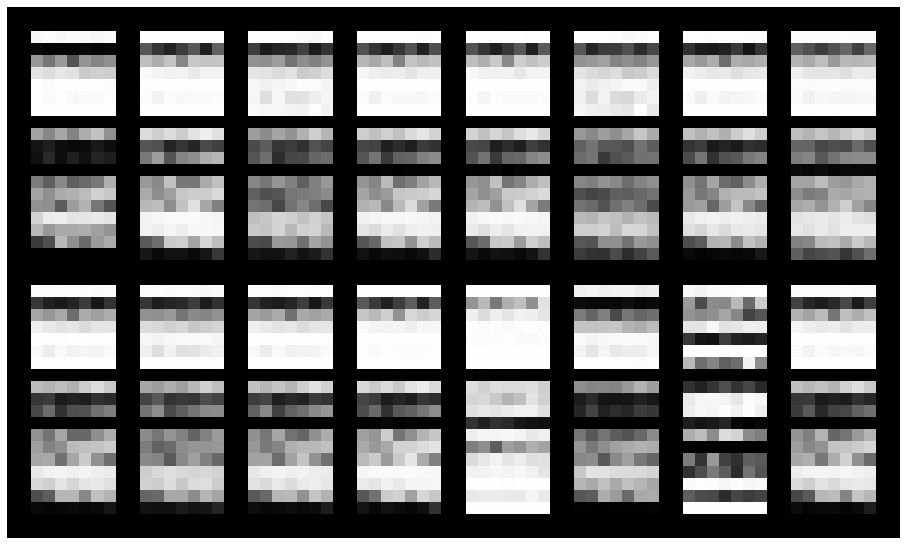

Epoch: [141/200], Batch Num: [0/54]
Discriminator Loss: 0.0057, Generator Loss: 6.2511
D(x): 0.9986, D(G(z)): 0.0034


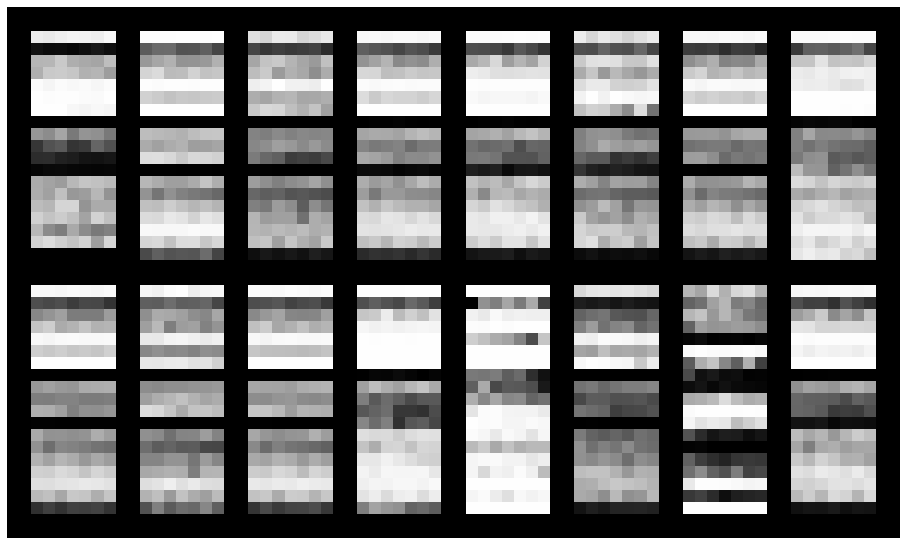

Epoch: [142/200], Batch Num: [0/54]
Discriminator Loss: 0.0505, Generator Loss: 5.7271
D(x): 0.9889, D(G(z)): 0.0068


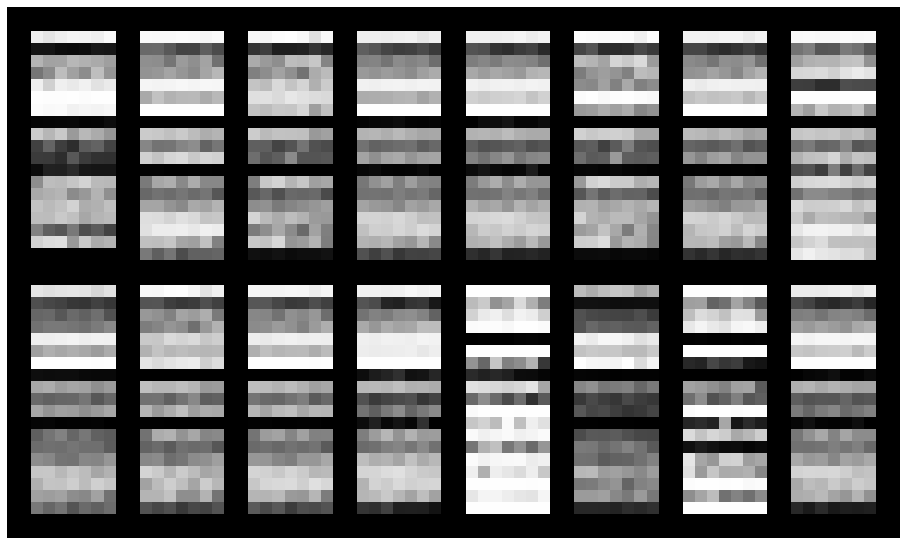

Epoch: [143/200], Batch Num: [0/54]
Discriminator Loss: 0.0130, Generator Loss: 6.3820
D(x): 0.9967, D(G(z)): 0.0049


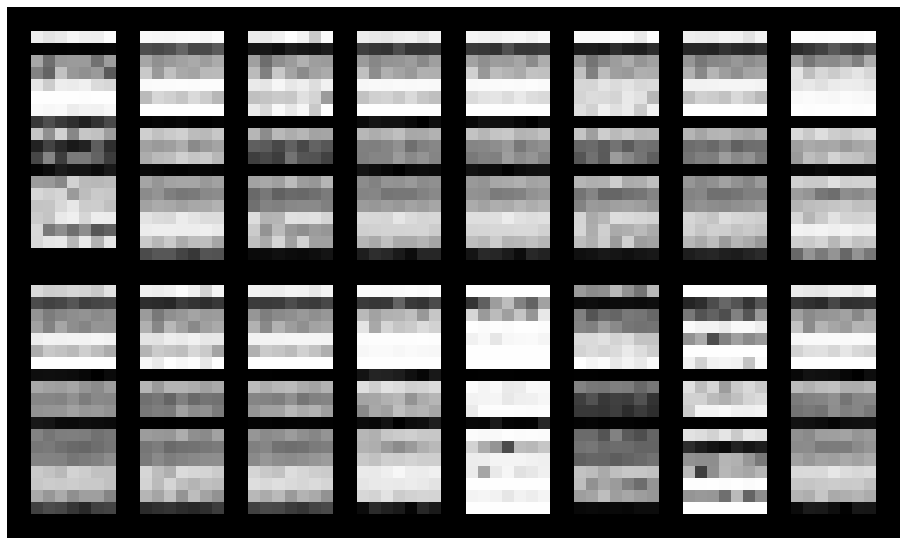

Epoch: [144/200], Batch Num: [0/54]
Discriminator Loss: 0.0112, Generator Loss: 6.5725
D(x): 0.9969, D(G(z)): 0.0045


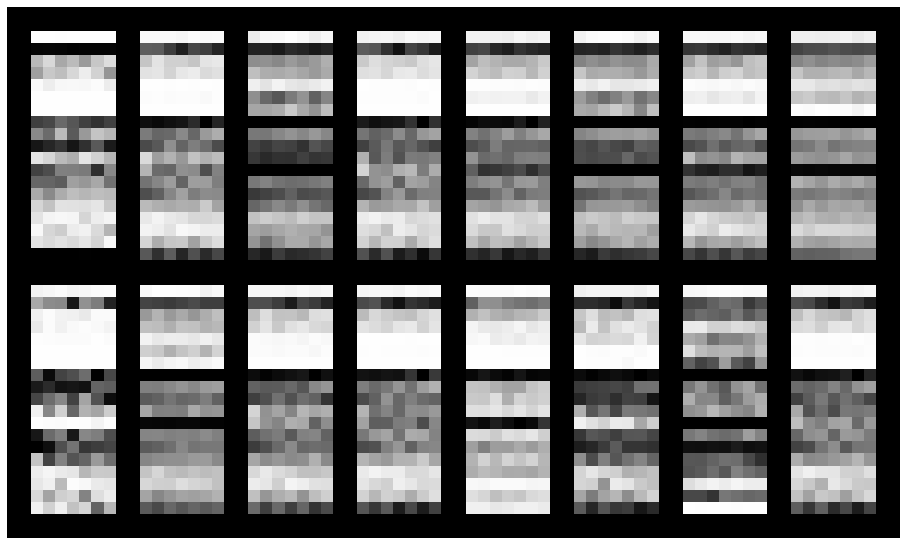

Epoch: [145/200], Batch Num: [0/54]
Discriminator Loss: 0.0246, Generator Loss: 6.4561
D(x): 0.9936, D(G(z)): 0.0060


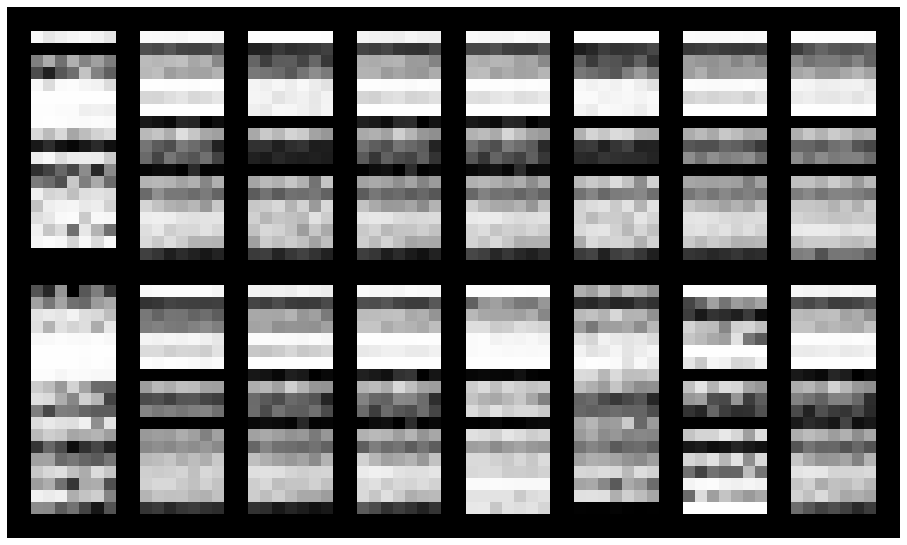

Epoch: [146/200], Batch Num: [0/54]
Discriminator Loss: 0.0062, Generator Loss: 7.1070
D(x): 0.9976, D(G(z)): 0.0025


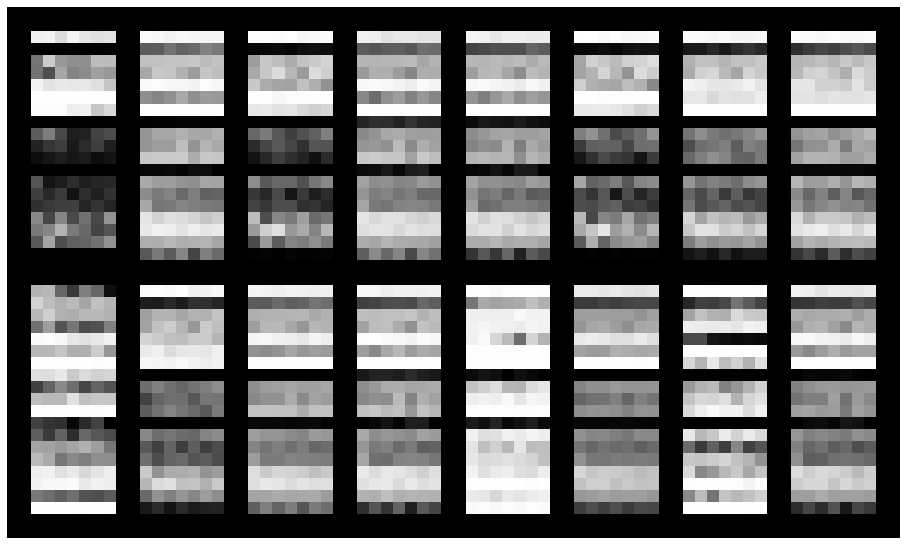

Epoch: [147/200], Batch Num: [0/54]
Discriminator Loss: 0.0243, Generator Loss: 6.0826
D(x): 0.9941, D(G(z)): 0.0065


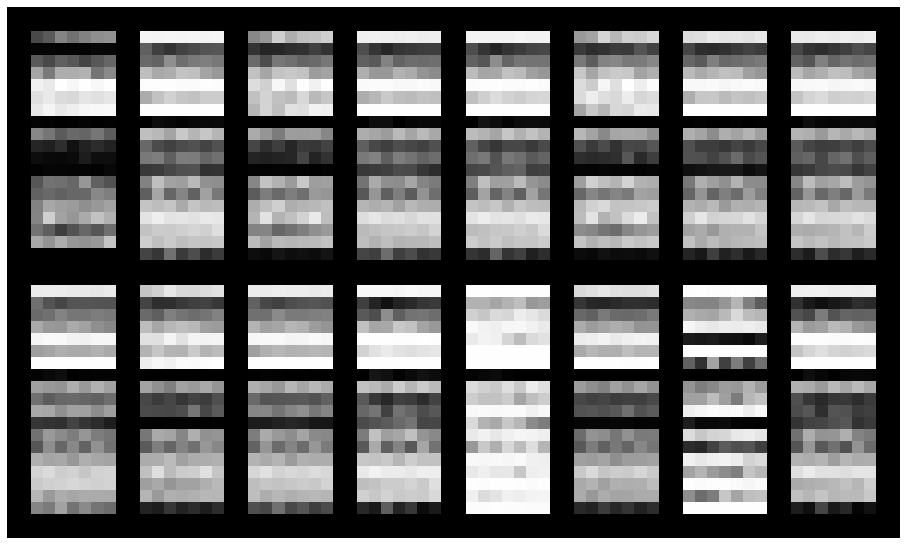

Epoch: [148/200], Batch Num: [0/54]
Discriminator Loss: 0.0093, Generator Loss: 5.9915
D(x): 0.9996, D(G(z)): 0.0079


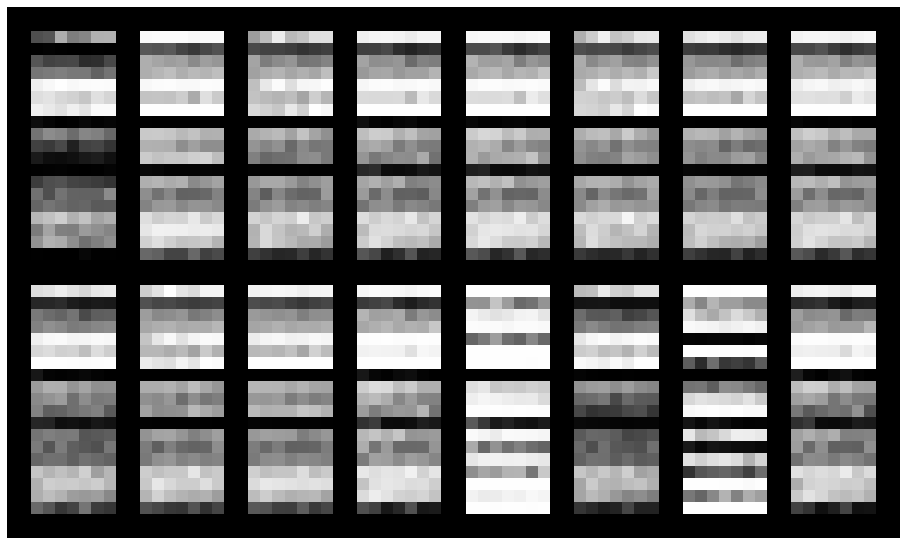

Epoch: [149/200], Batch Num: [0/54]
Discriminator Loss: 0.0090, Generator Loss: 6.2754
D(x): 0.9963, D(G(z)): 0.0024


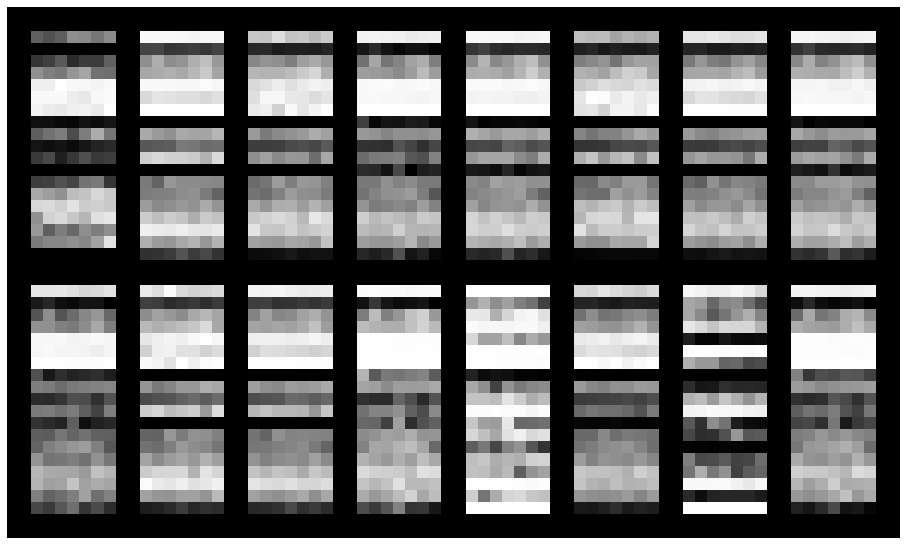

Epoch: [150/200], Batch Num: [0/54]
Discriminator Loss: 0.0490, Generator Loss: 6.4543
D(x): 0.9889, D(G(z)): 0.0073


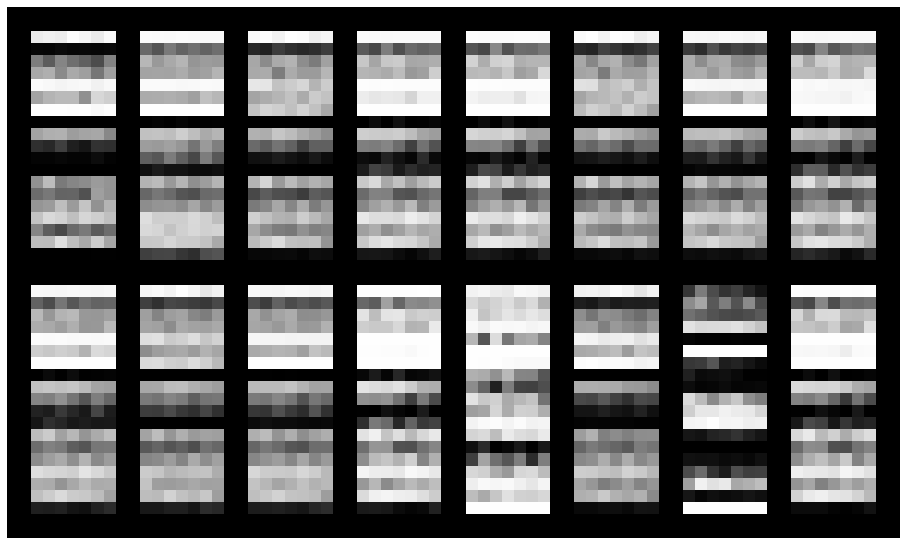

Epoch: [151/200], Batch Num: [0/54]
Discriminator Loss: 0.0216, Generator Loss: 6.1943
D(x): 0.9968, D(G(z)): 0.0060


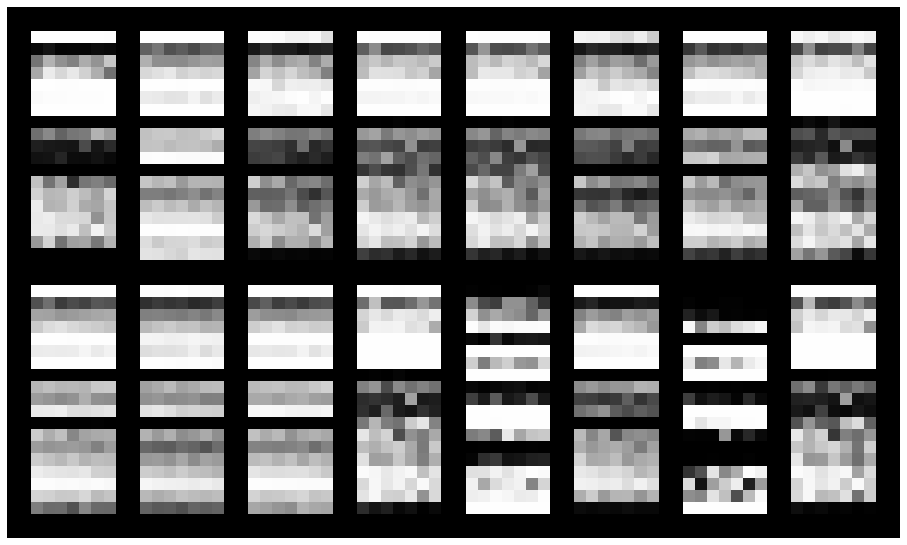

Epoch: [152/200], Batch Num: [0/54]
Discriminator Loss: 0.0037, Generator Loss: 6.5768
D(x): 0.9998, D(G(z)): 0.0033


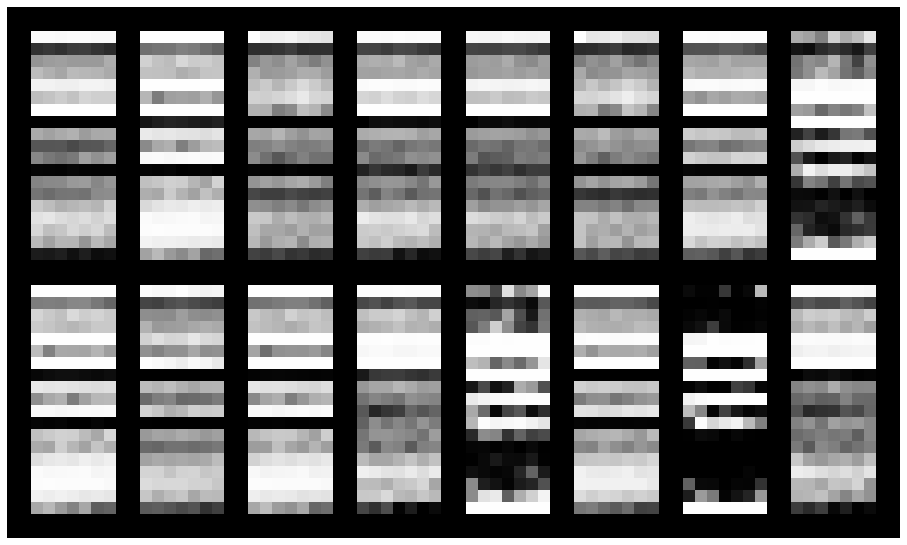

Epoch: [153/200], Batch Num: [0/54]
Discriminator Loss: 0.0369, Generator Loss: 6.6860
D(x): 0.9936, D(G(z)): 0.0041


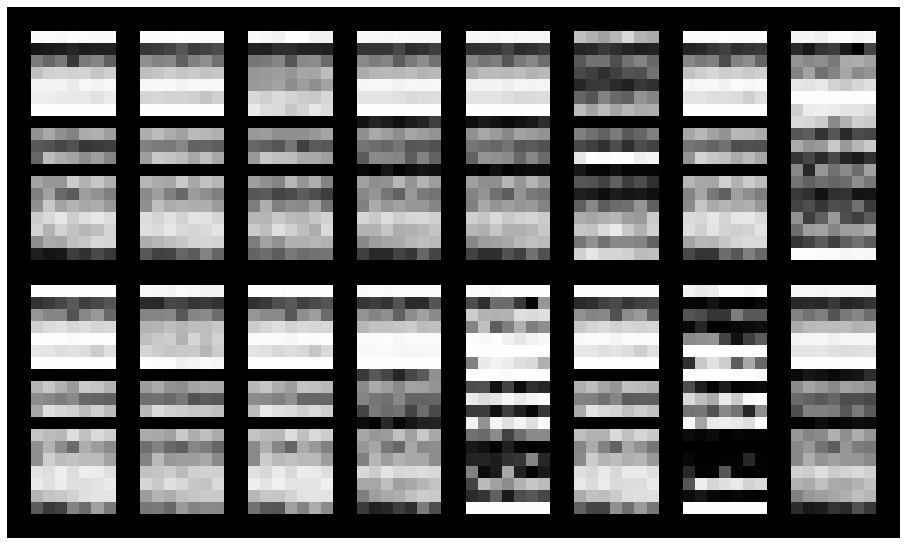

Epoch: [154/200], Batch Num: [0/54]
Discriminator Loss: 0.0143, Generator Loss: 6.0572
D(x): 0.9946, D(G(z)): 0.0036


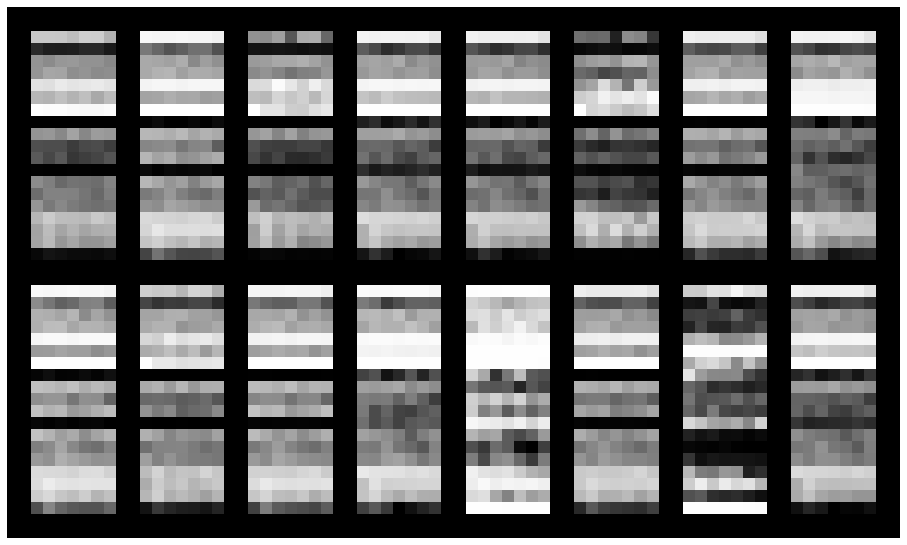

Epoch: [155/200], Batch Num: [0/54]
Discriminator Loss: 0.0346, Generator Loss: 5.8142
D(x): 0.9948, D(G(z)): 0.0047


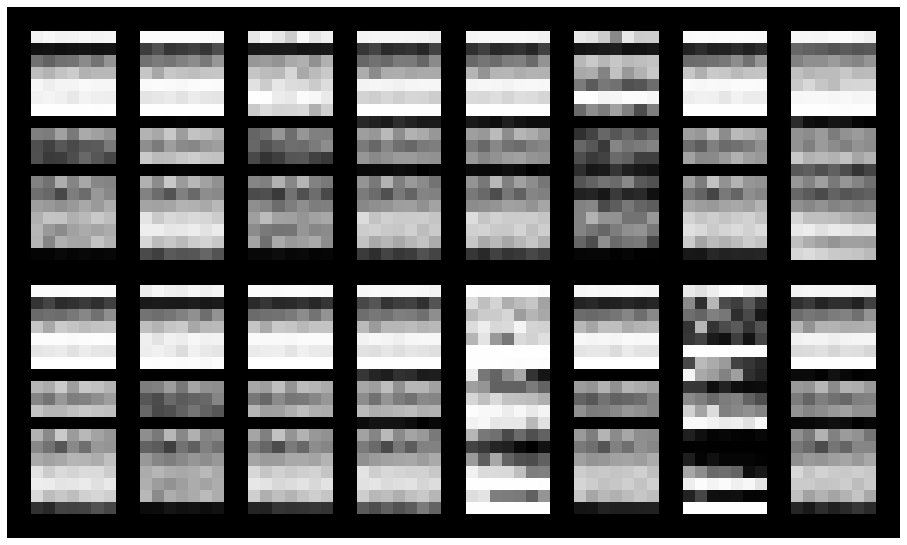

Epoch: [156/200], Batch Num: [0/54]
Discriminator Loss: 0.0197, Generator Loss: 6.4103
D(x): 0.9974, D(G(z)): 0.0054


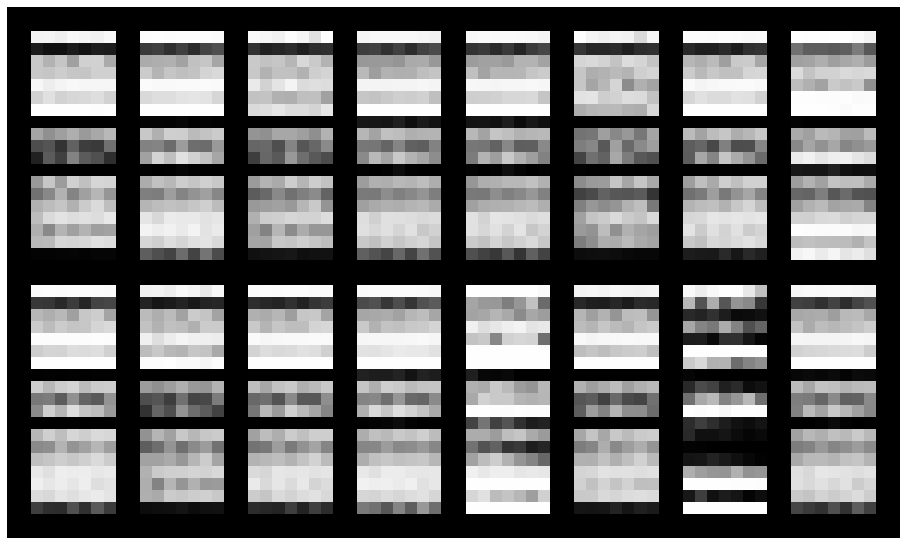

Epoch: [157/200], Batch Num: [0/54]
Discriminator Loss: 0.0270, Generator Loss: 6.6714
D(x): 0.9941, D(G(z)): 0.0048


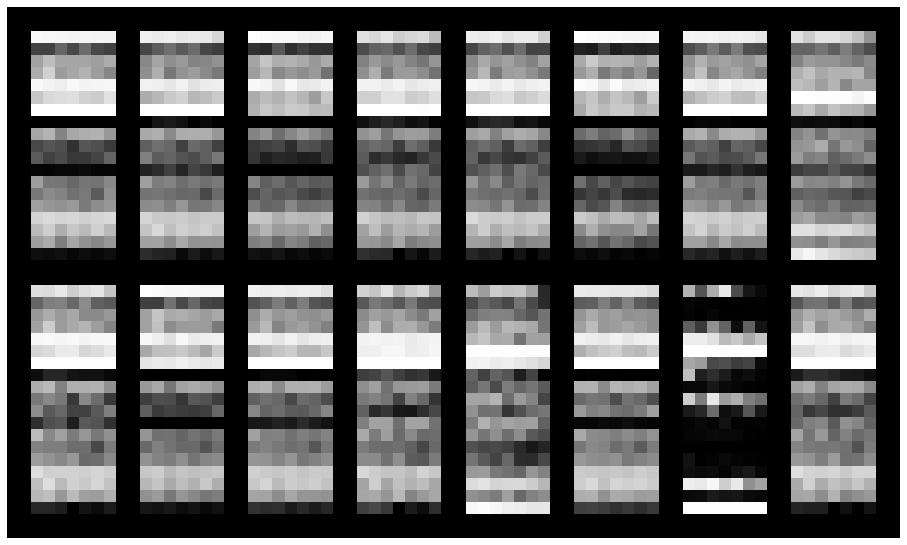

Epoch: [158/200], Batch Num: [0/54]
Discriminator Loss: 0.0309, Generator Loss: 7.2209
D(x): 0.9960, D(G(z)): 0.0024


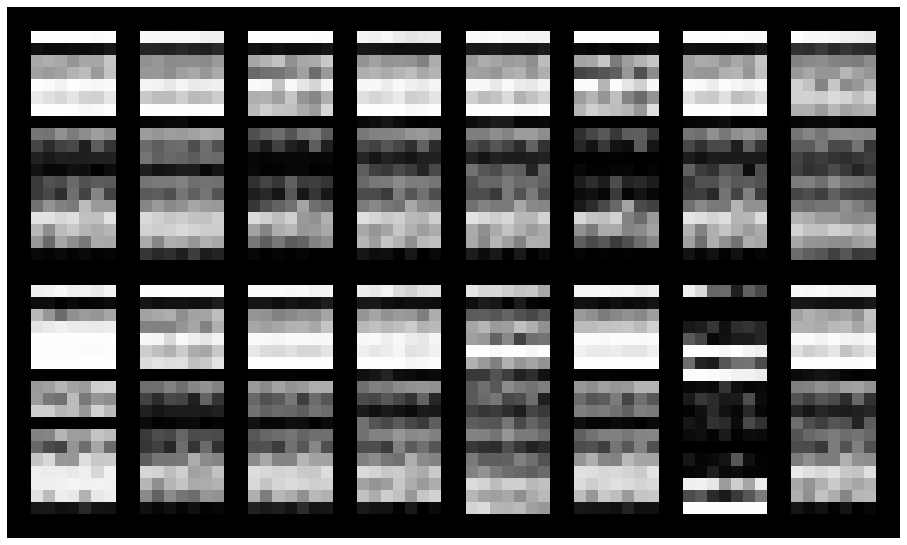

Epoch: [159/200], Batch Num: [0/54]
Discriminator Loss: 0.0263, Generator Loss: 6.4263
D(x): 0.9960, D(G(z)): 0.0031


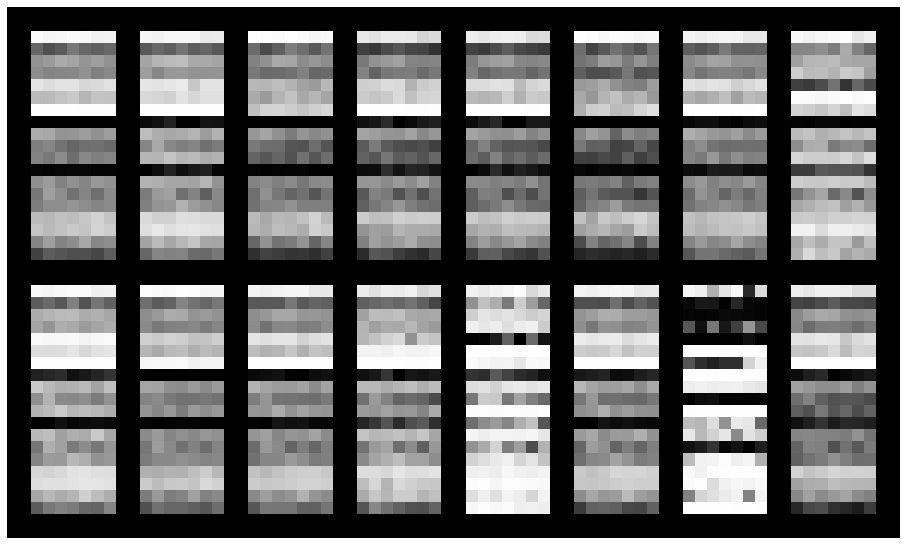

Epoch: [160/200], Batch Num: [0/54]
Discriminator Loss: 0.0314, Generator Loss: 6.2590
D(x): 0.9959, D(G(z)): 0.0041


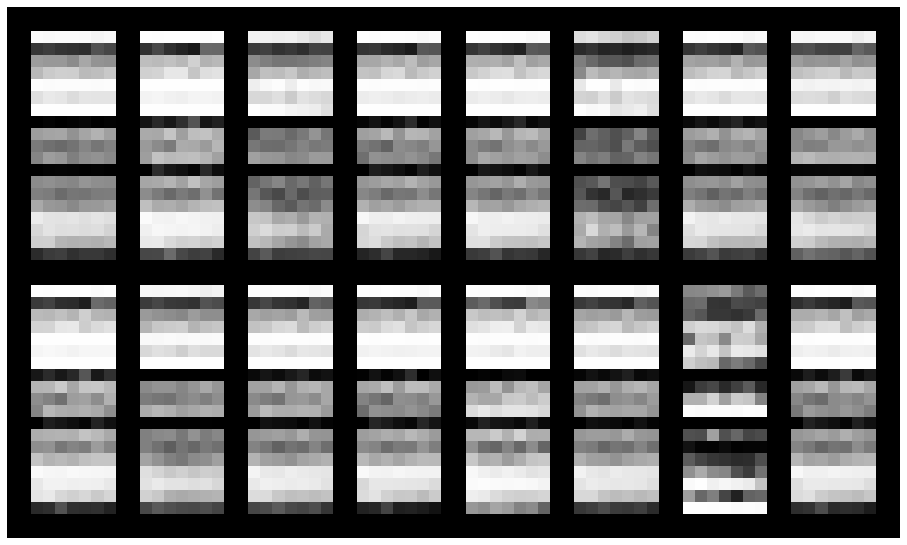

Epoch: [161/200], Batch Num: [0/54]
Discriminator Loss: 0.0240, Generator Loss: 6.5173
D(x): 0.9960, D(G(z)): 0.0023


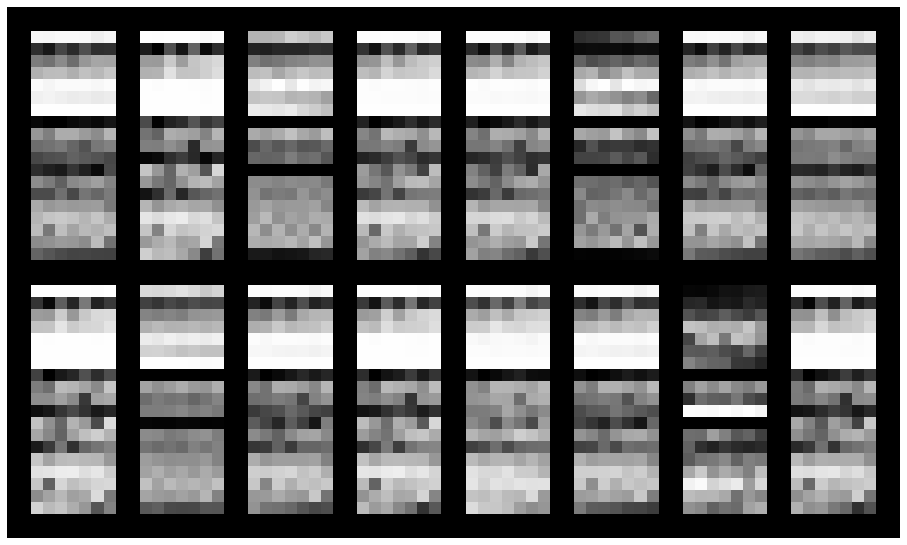

Epoch: [162/200], Batch Num: [0/54]
Discriminator Loss: 0.0021, Generator Loss: 6.7613
D(x): 0.9999, D(G(z)): 0.0020


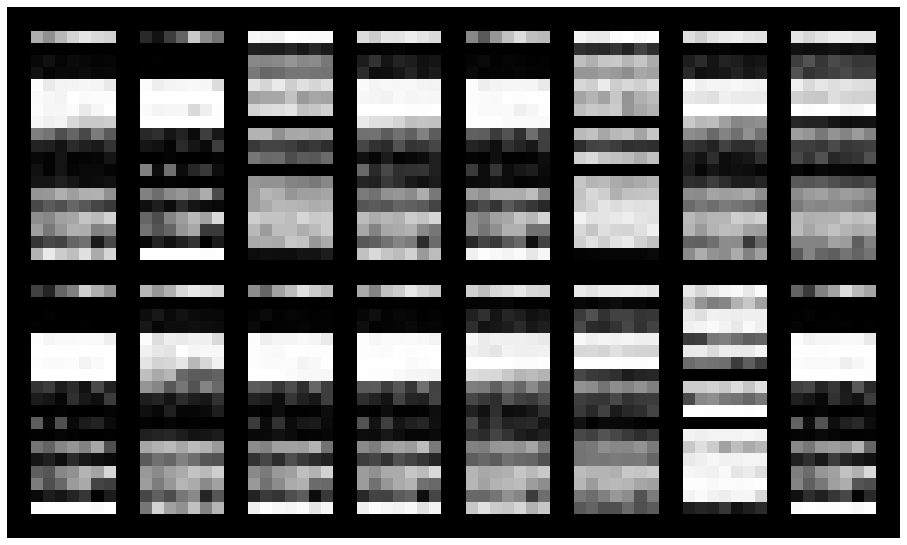

Epoch: [163/200], Batch Num: [0/54]
Discriminator Loss: 0.0168, Generator Loss: 5.8846
D(x): 0.9950, D(G(z)): 0.0047


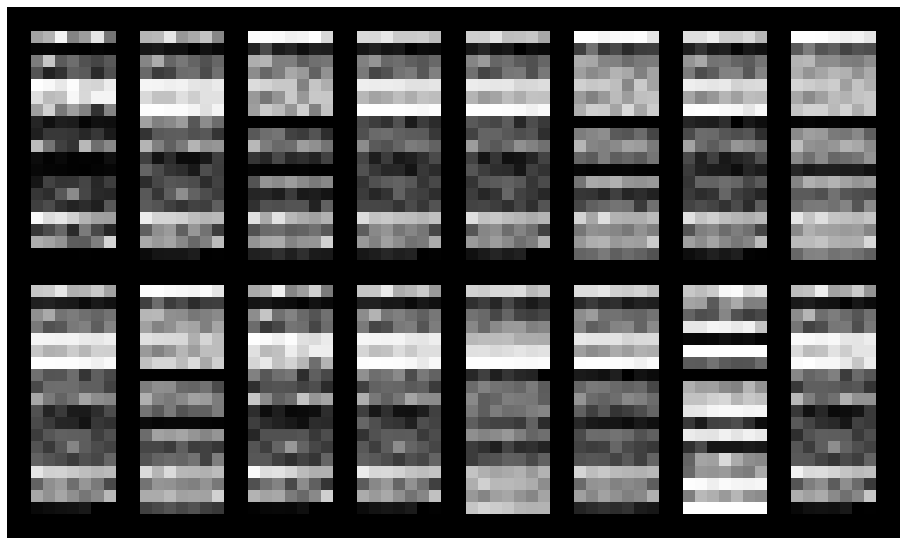

Epoch: [164/200], Batch Num: [0/54]
Discriminator Loss: 0.0187, Generator Loss: 6.6094
D(x): 0.9973, D(G(z)): 0.0032


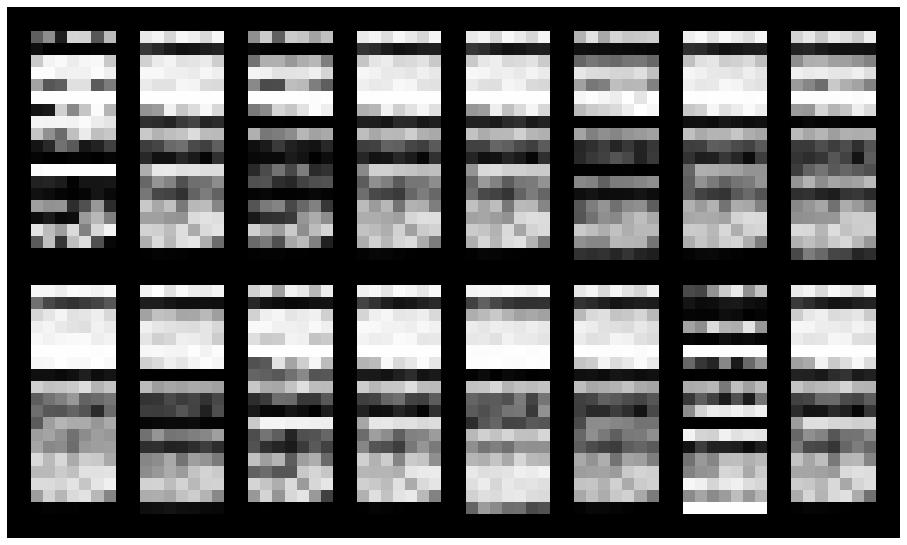

Epoch: [165/200], Batch Num: [0/54]
Discriminator Loss: 0.0342, Generator Loss: 7.4393
D(x): 0.9924, D(G(z)): 0.0012


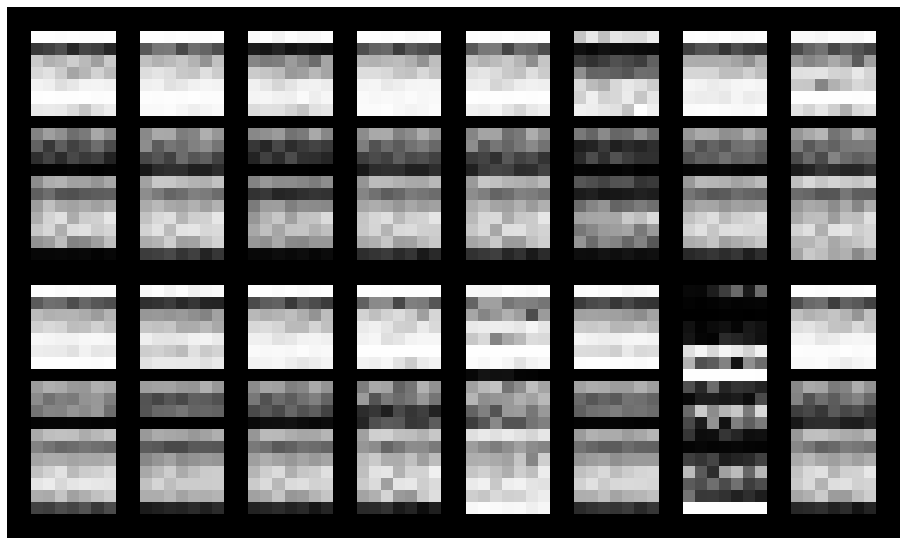

Epoch: [166/200], Batch Num: [0/54]
Discriminator Loss: 0.0256, Generator Loss: 6.1518
D(x): 0.9947, D(G(z)): 0.0033


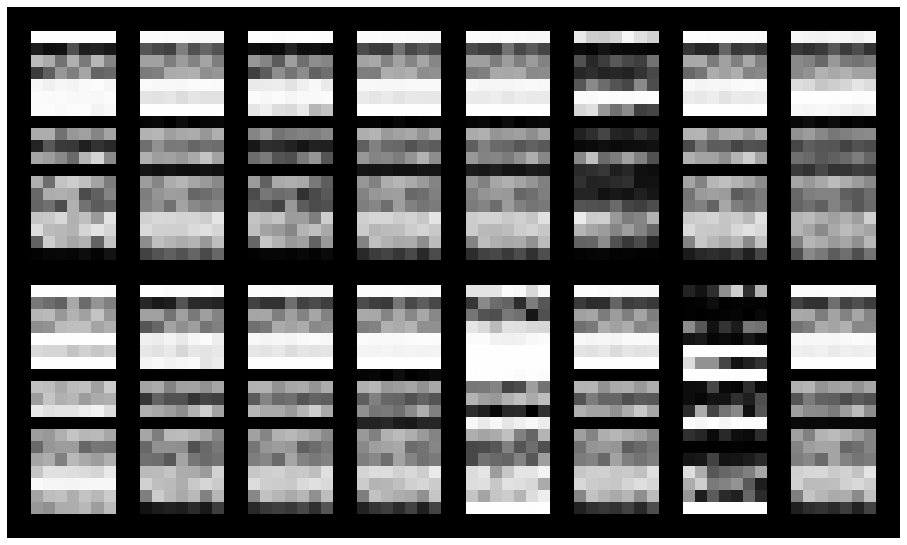

Epoch: [167/200], Batch Num: [0/54]
Discriminator Loss: 0.0322, Generator Loss: 5.8314
D(x): 0.9971, D(G(z)): 0.0114


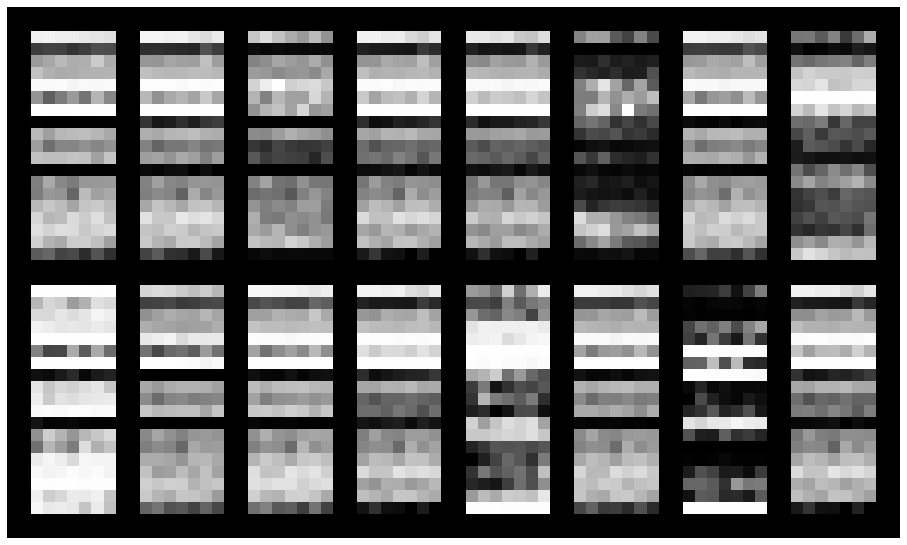

Epoch: [168/200], Batch Num: [0/54]
Discriminator Loss: 0.0250, Generator Loss: 6.3570
D(x): 0.9960, D(G(z)): 0.0060


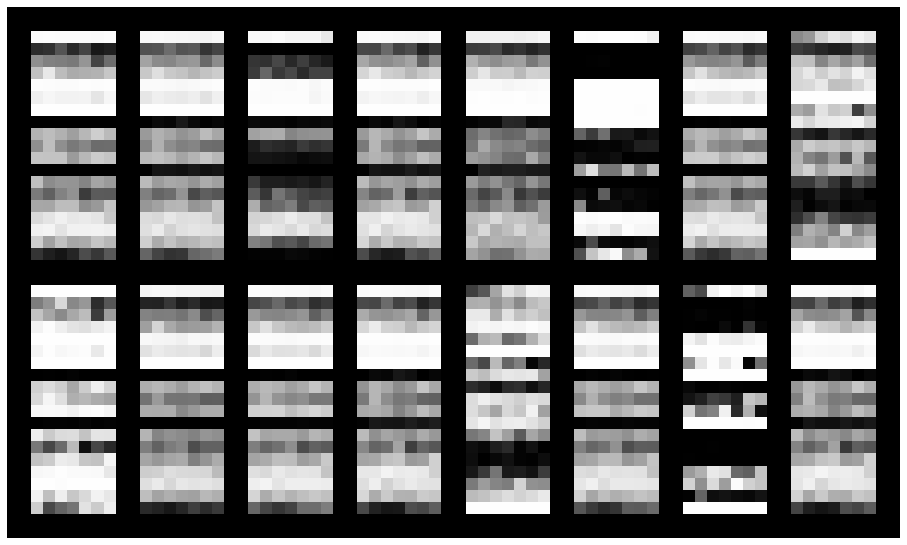

Epoch: [169/200], Batch Num: [0/54]
Discriminator Loss: 0.0182, Generator Loss: 6.3160
D(x): 0.9978, D(G(z)): 0.0075


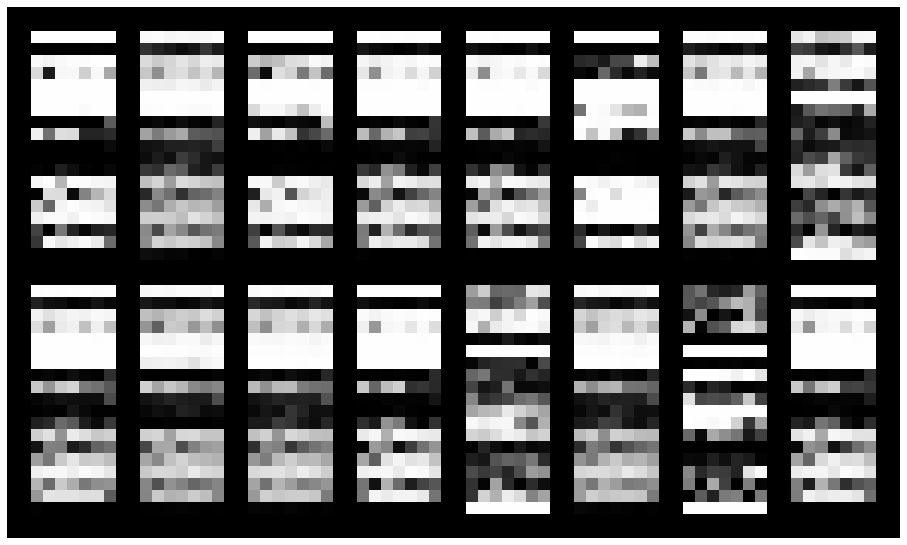

Epoch: [170/200], Batch Num: [0/54]
Discriminator Loss: 0.0169, Generator Loss: 7.0403
D(x): 0.9990, D(G(z)): 0.0081


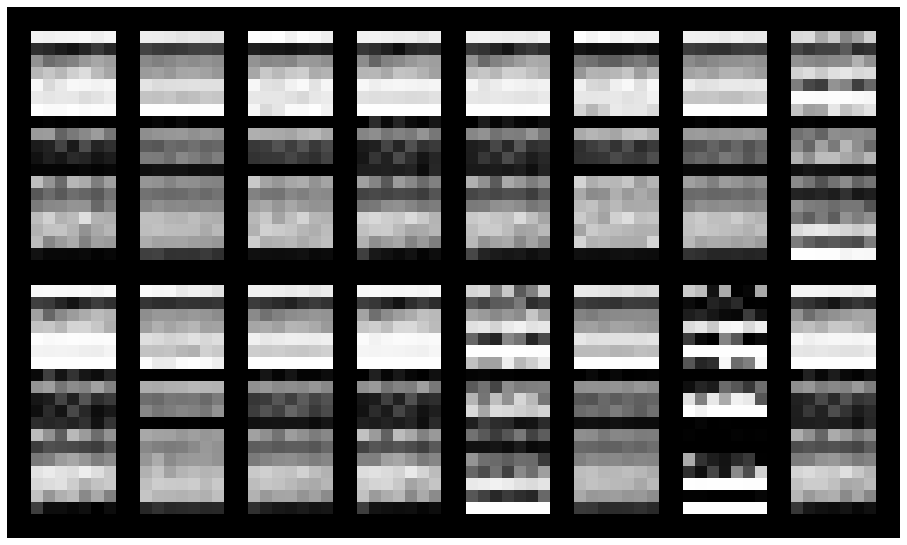

Epoch: [171/200], Batch Num: [0/54]
Discriminator Loss: 0.0071, Generator Loss: 6.2901
D(x): 0.9999, D(G(z)): 0.0064


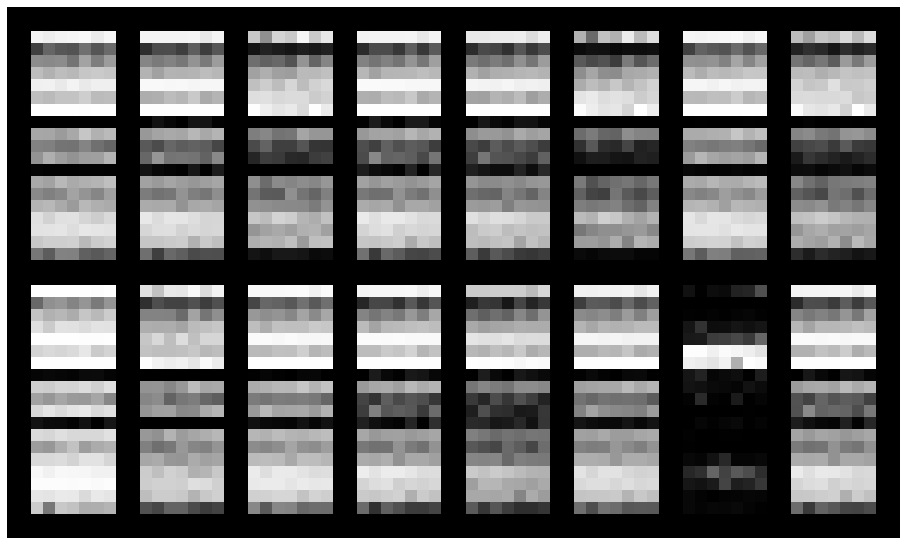

Epoch: [172/200], Batch Num: [0/54]
Discriminator Loss: 0.0419, Generator Loss: 6.7887
D(x): 0.9922, D(G(z)): 0.0019


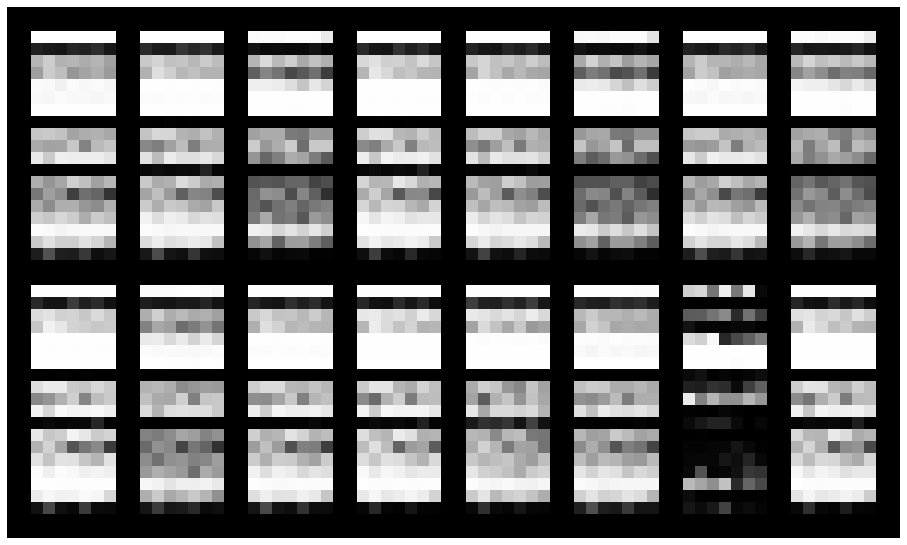

Epoch: [173/200], Batch Num: [0/54]
Discriminator Loss: 0.0179, Generator Loss: 7.3730
D(x): 0.9980, D(G(z)): 0.0019


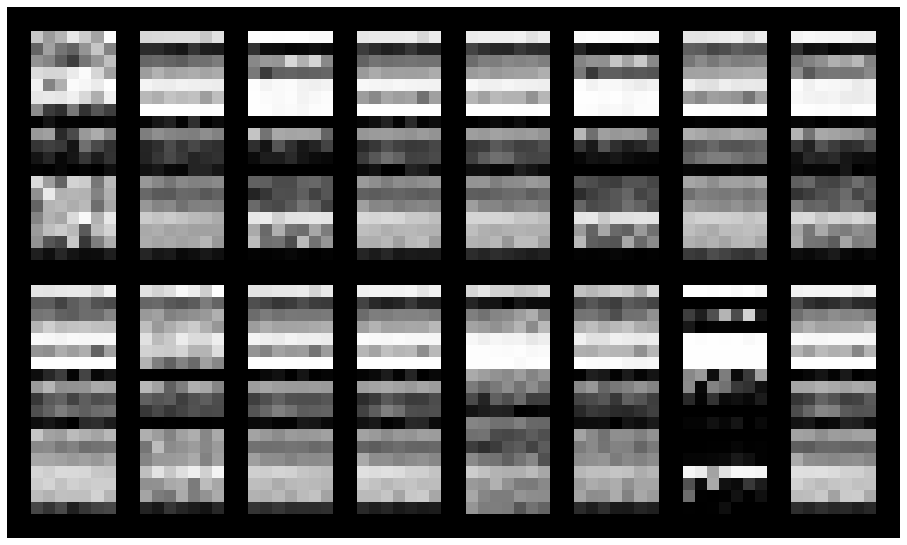

Epoch: [174/200], Batch Num: [0/54]
Discriminator Loss: 0.0053, Generator Loss: 6.8158
D(x): 0.9981, D(G(z)): 0.0027


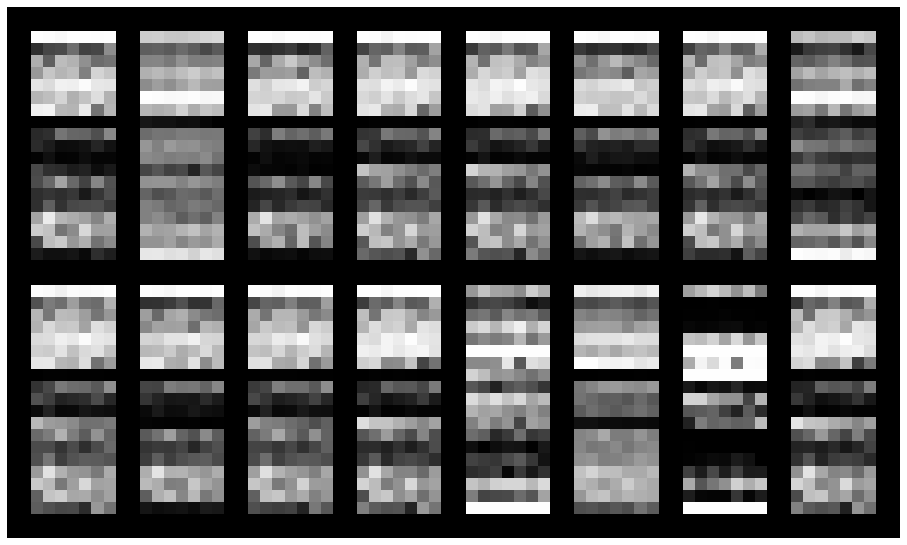

Epoch: [175/200], Batch Num: [0/54]
Discriminator Loss: 0.0239, Generator Loss: 7.1843
D(x): 0.9980, D(G(z)): 0.0024


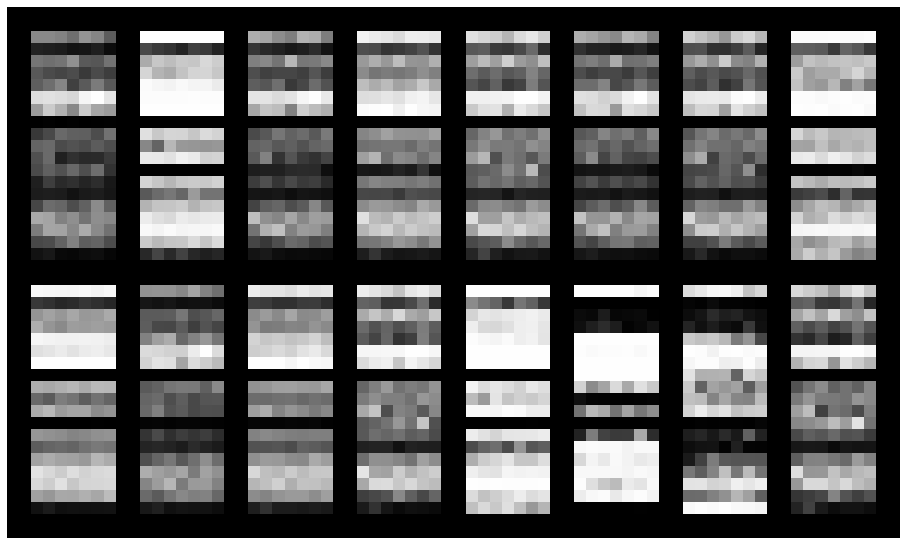

Epoch: [176/200], Batch Num: [0/54]
Discriminator Loss: 0.0323, Generator Loss: 7.2363
D(x): 0.9940, D(G(z)): 0.0083


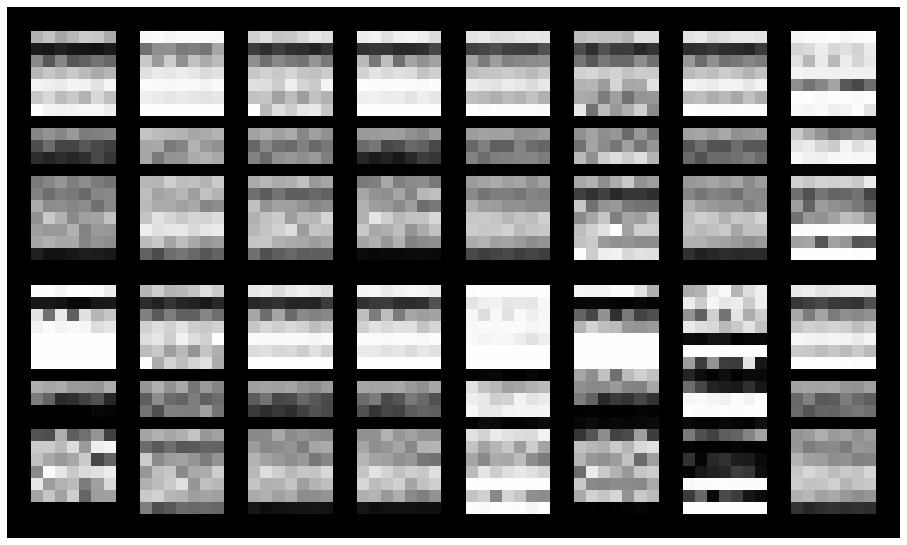

Epoch: [177/200], Batch Num: [0/54]
Discriminator Loss: 0.0048, Generator Loss: 6.7699
D(x): 0.9996, D(G(z)): 0.0042


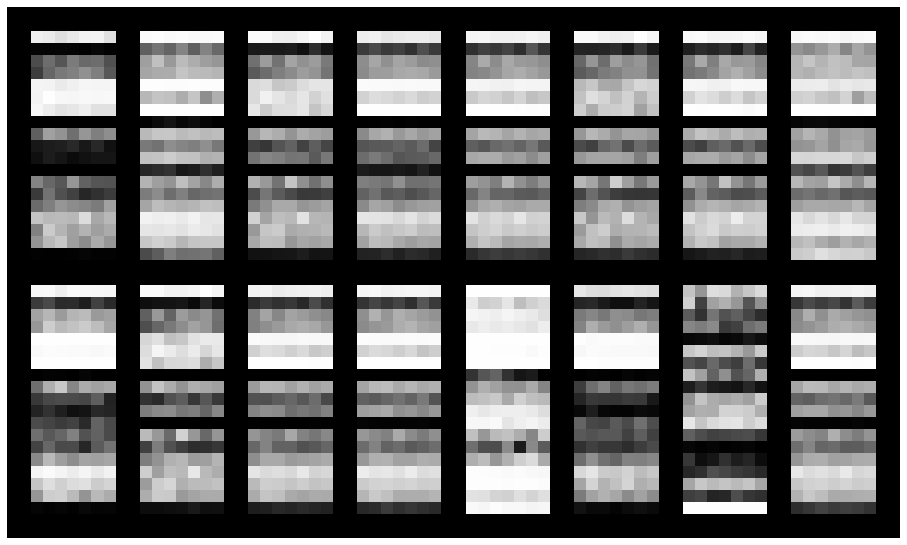

Epoch: [178/200], Batch Num: [0/54]
Discriminator Loss: 0.0069, Generator Loss: 6.5775
D(x): 0.9983, D(G(z)): 0.0028


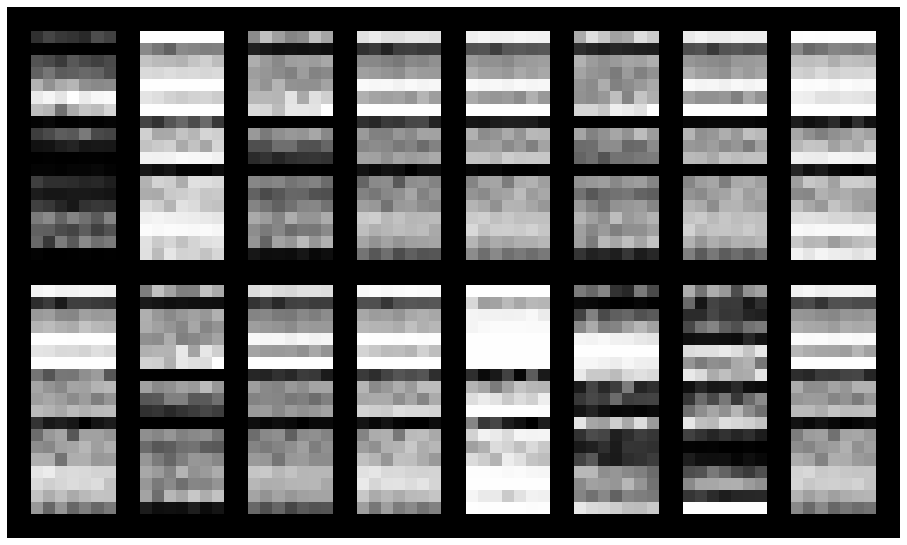

Epoch: [179/200], Batch Num: [0/54]
Discriminator Loss: 0.0121, Generator Loss: 6.4210
D(x): 0.9968, D(G(z)): 0.0030


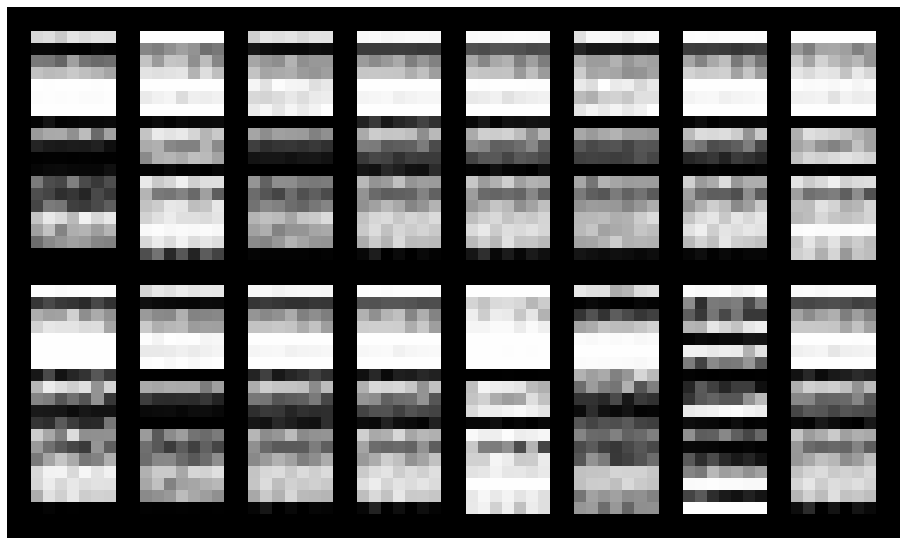

Epoch: [180/200], Batch Num: [0/54]
Discriminator Loss: 0.0025, Generator Loss: 6.9797
D(x): 0.9999, D(G(z)): 0.0023


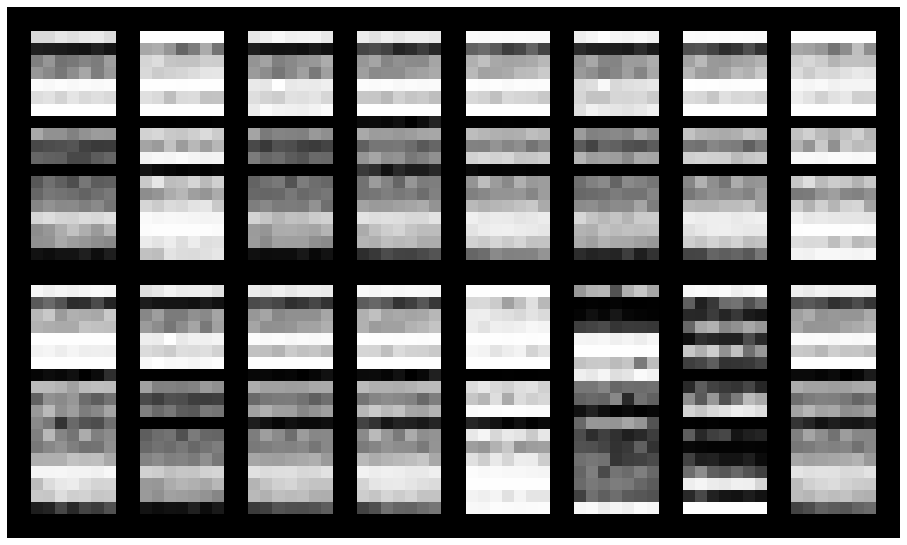

Epoch: [181/200], Batch Num: [0/54]
Discriminator Loss: 0.0059, Generator Loss: 6.5197
D(x): 0.9992, D(G(z)): 0.0046


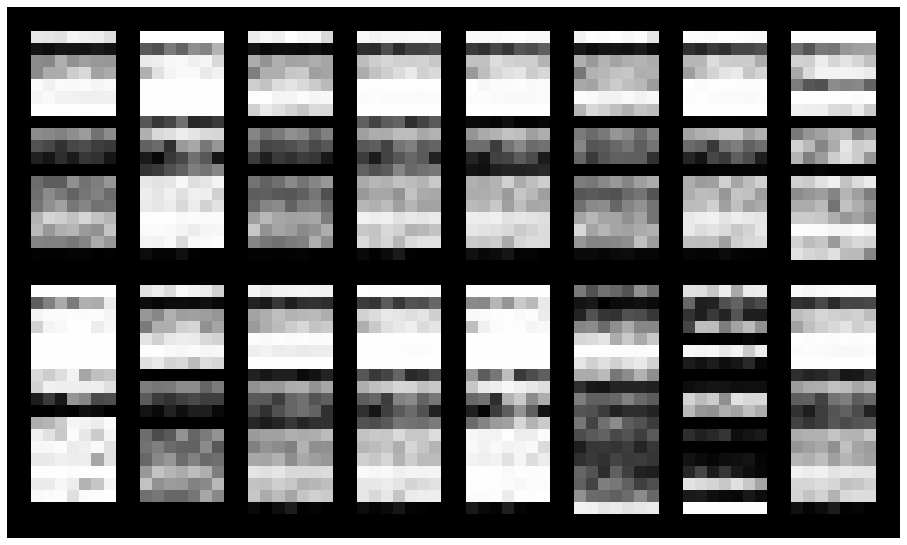

Epoch: [182/200], Batch Num: [0/54]
Discriminator Loss: 0.0147, Generator Loss: 6.6931
D(x): 0.9968, D(G(z)): 0.0033


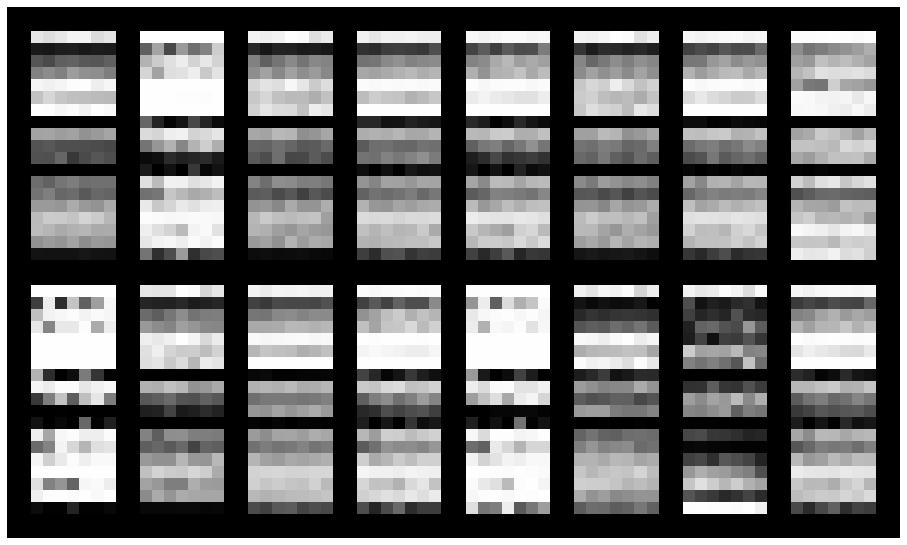

Epoch: [183/200], Batch Num: [0/54]
Discriminator Loss: 0.0422, Generator Loss: 6.7135
D(x): 0.9941, D(G(z)): 0.0027


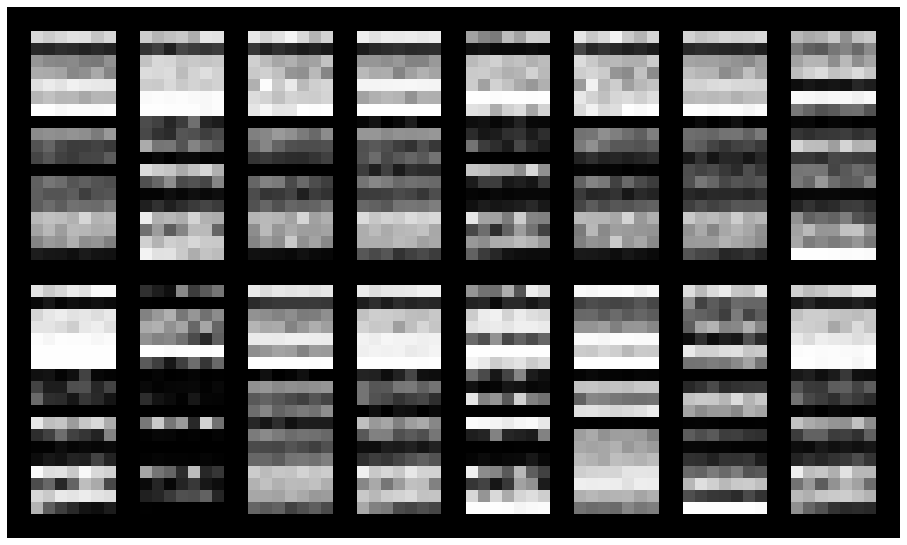

Epoch: [184/200], Batch Num: [0/54]
Discriminator Loss: 0.0671, Generator Loss: 7.5533
D(x): 0.9909, D(G(z)): 0.0104


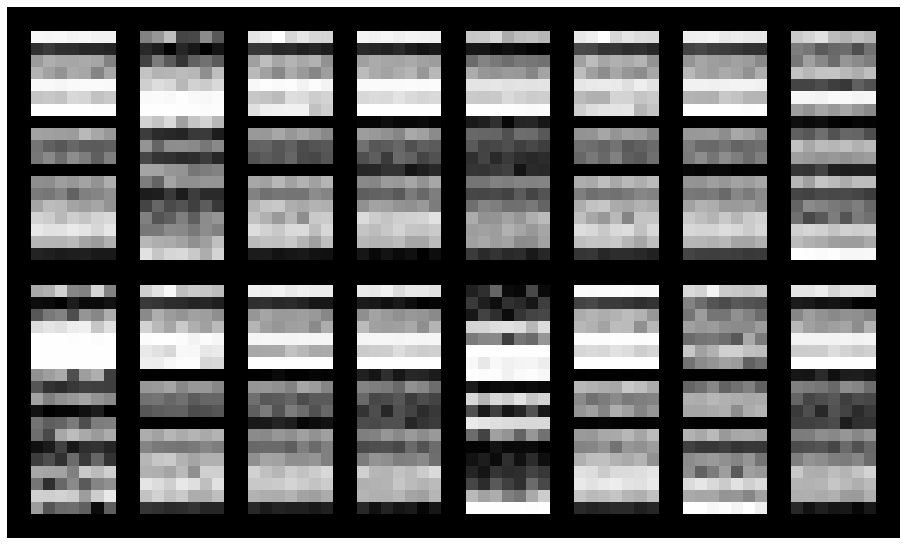

Epoch: [185/200], Batch Num: [0/54]
Discriminator Loss: 0.0444, Generator Loss: 5.9945
D(x): 0.9905, D(G(z)): 0.0044


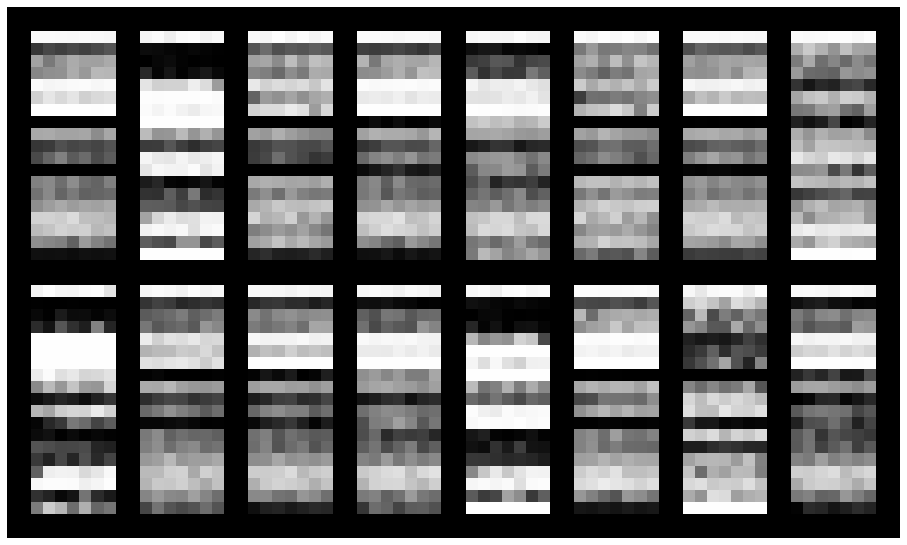

Epoch: [186/200], Batch Num: [0/54]
Discriminator Loss: 0.0043, Generator Loss: 6.5845
D(x): 0.9996, D(G(z)): 0.0038


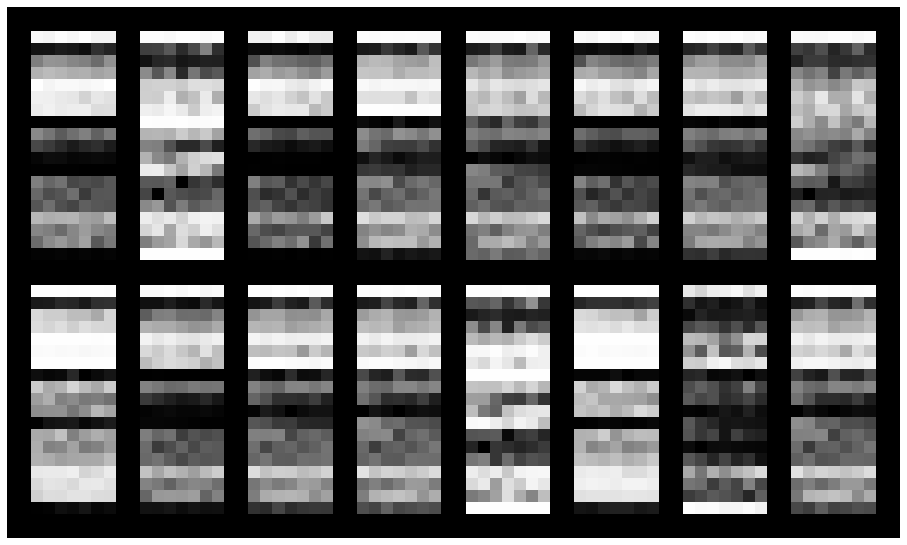

Epoch: [187/200], Batch Num: [0/54]
Discriminator Loss: 0.0230, Generator Loss: 7.2560
D(x): 0.9956, D(G(z)): 0.0013


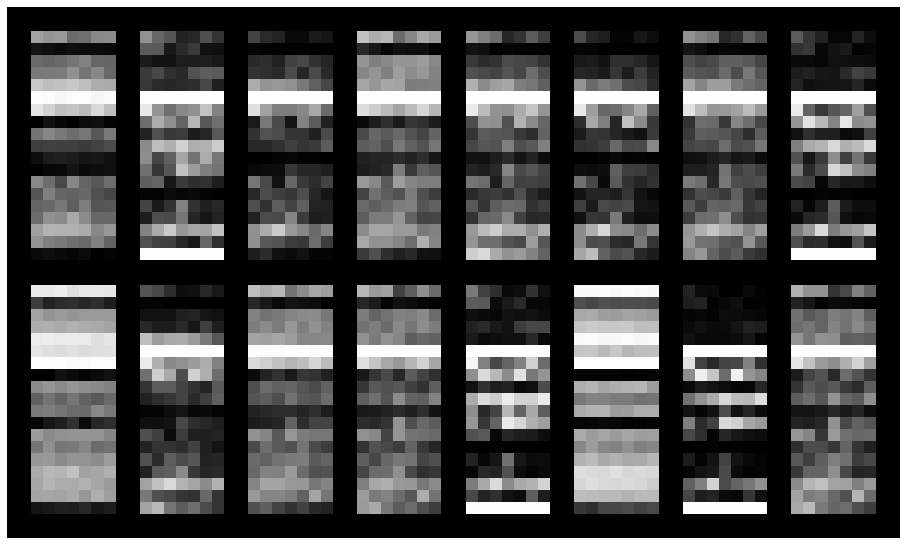

Epoch: [188/200], Batch Num: [0/54]
Discriminator Loss: 0.0090, Generator Loss: 6.5820
D(x): 0.9977, D(G(z)): 0.0051


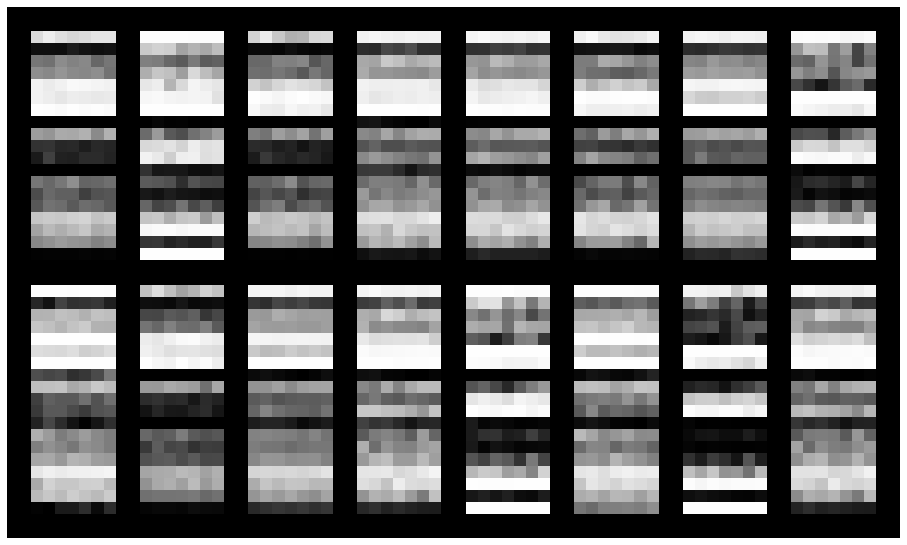

Epoch: [189/200], Batch Num: [0/54]
Discriminator Loss: 0.0210, Generator Loss: 6.7704
D(x): 0.9978, D(G(z)): 0.0083


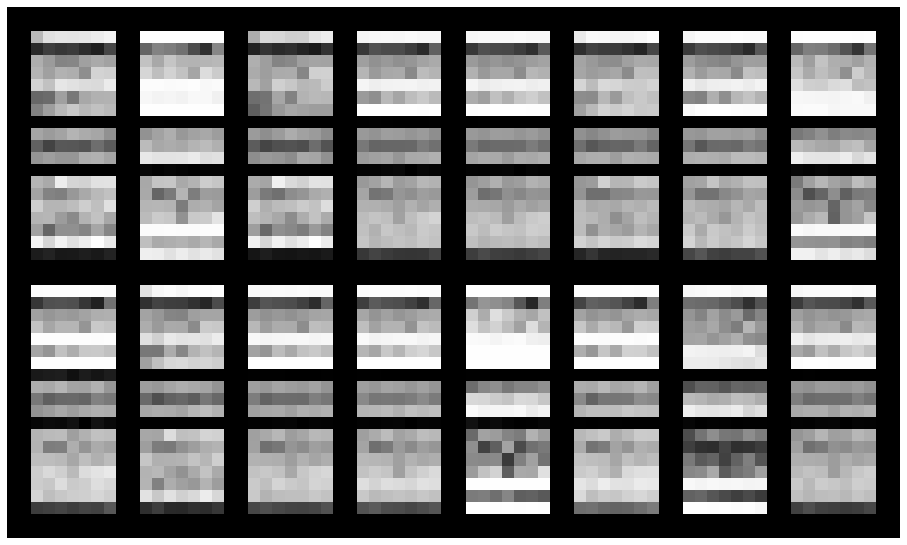

Epoch: [190/200], Batch Num: [0/54]
Discriminator Loss: 0.0239, Generator Loss: 6.8234
D(x): 0.9947, D(G(z)): 0.0024


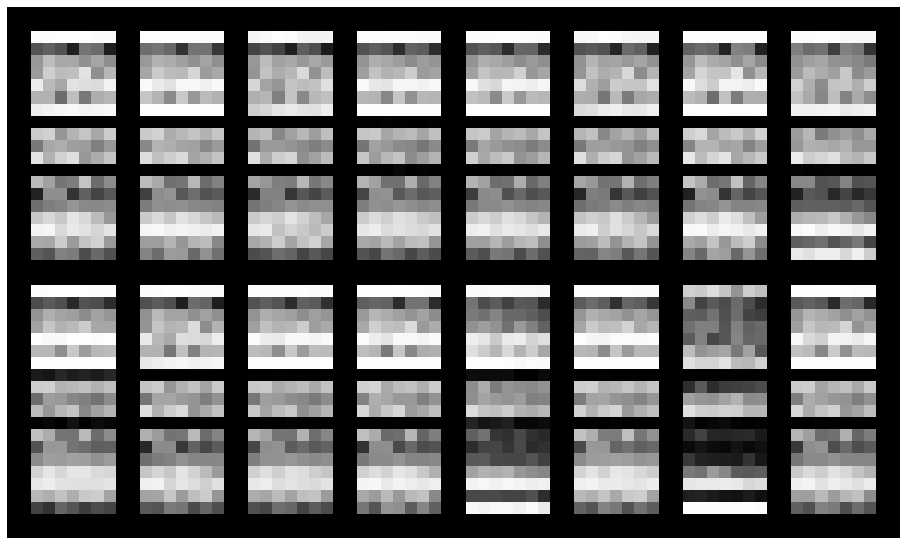

Epoch: [191/200], Batch Num: [0/54]
Discriminator Loss: 0.0099, Generator Loss: 6.8119
D(x): 0.9973, D(G(z)): 0.0020


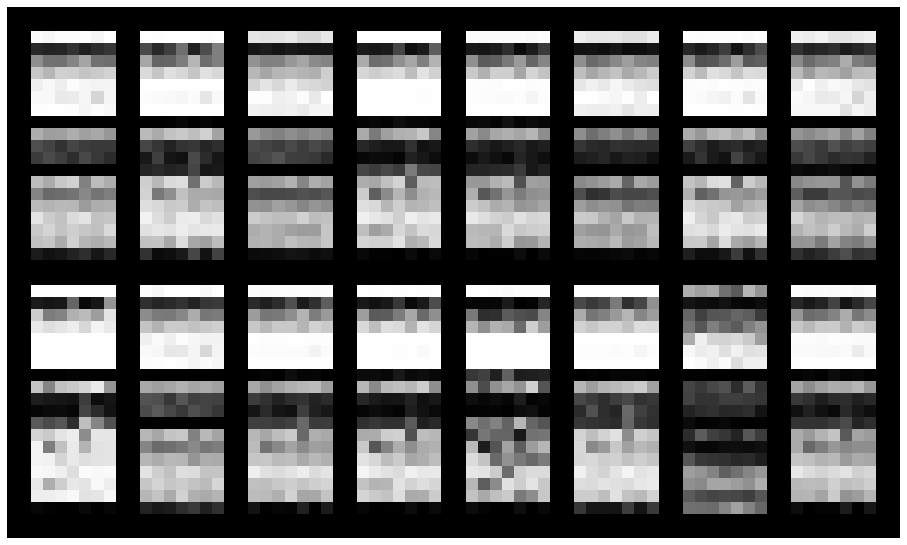

Epoch: [192/200], Batch Num: [0/54]
Discriminator Loss: 0.0134, Generator Loss: 6.8565
D(x): 0.9980, D(G(z)): 0.0027


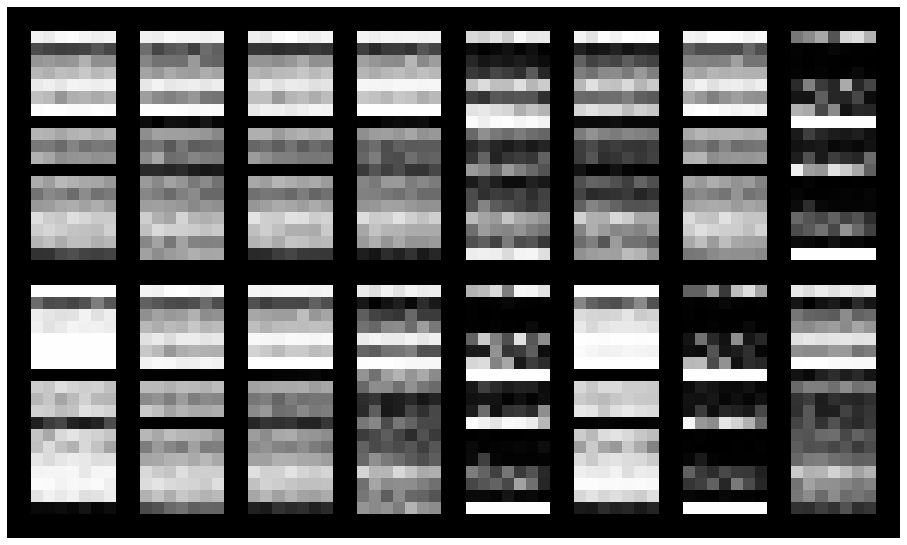

Epoch: [193/200], Batch Num: [0/54]
Discriminator Loss: 0.0104, Generator Loss: 5.7535
D(x): 0.9999, D(G(z)): 0.0096


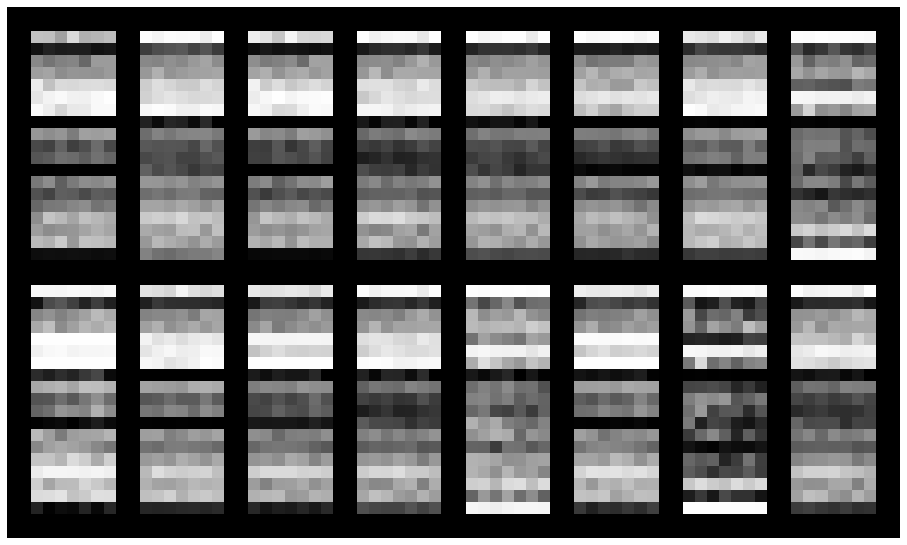

Epoch: [194/200], Batch Num: [0/54]
Discriminator Loss: 0.0165, Generator Loss: 6.3479
D(x): 0.9960, D(G(z)): 0.0027


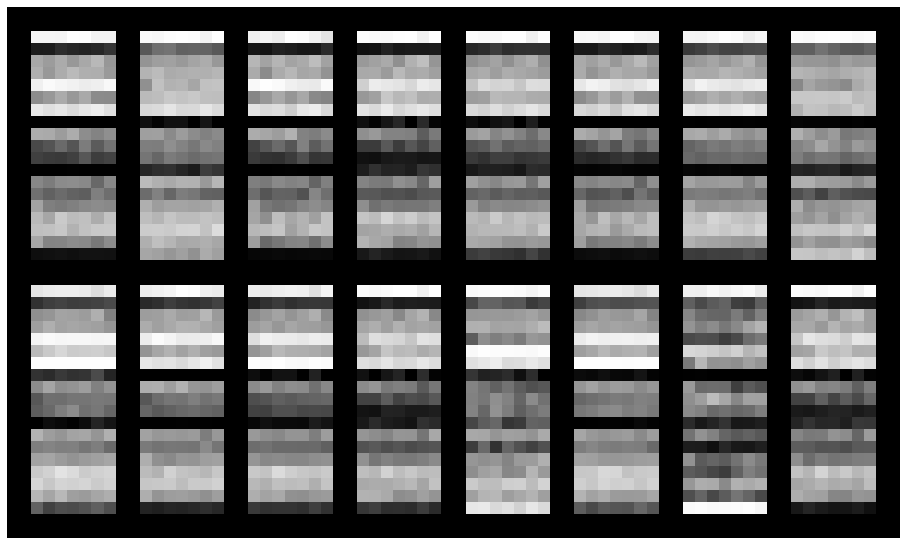

Epoch: [195/200], Batch Num: [0/54]
Discriminator Loss: 0.0115, Generator Loss: 5.8340
D(x): 0.9968, D(G(z)): 0.0034


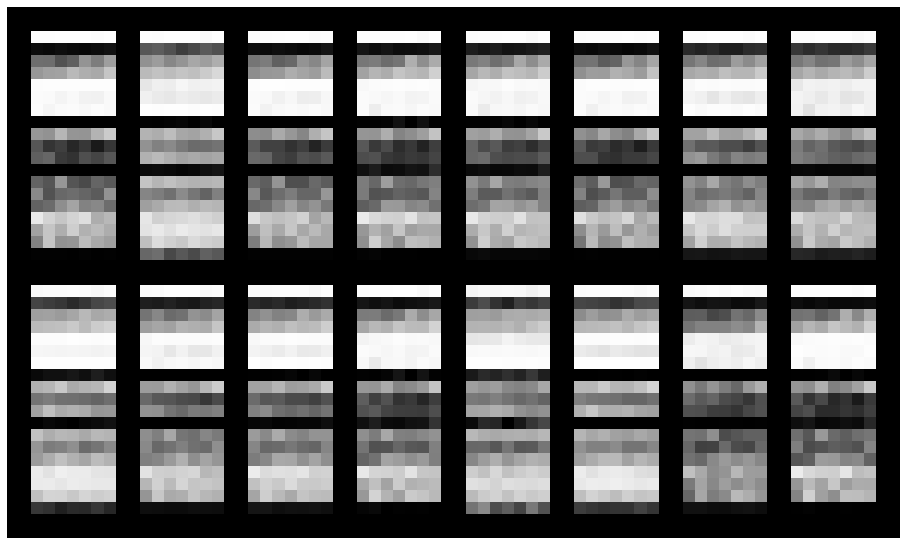

Epoch: [196/200], Batch Num: [0/54]
Discriminator Loss: 0.0142, Generator Loss: 6.0480
D(x): 0.9980, D(G(z)): 0.0047


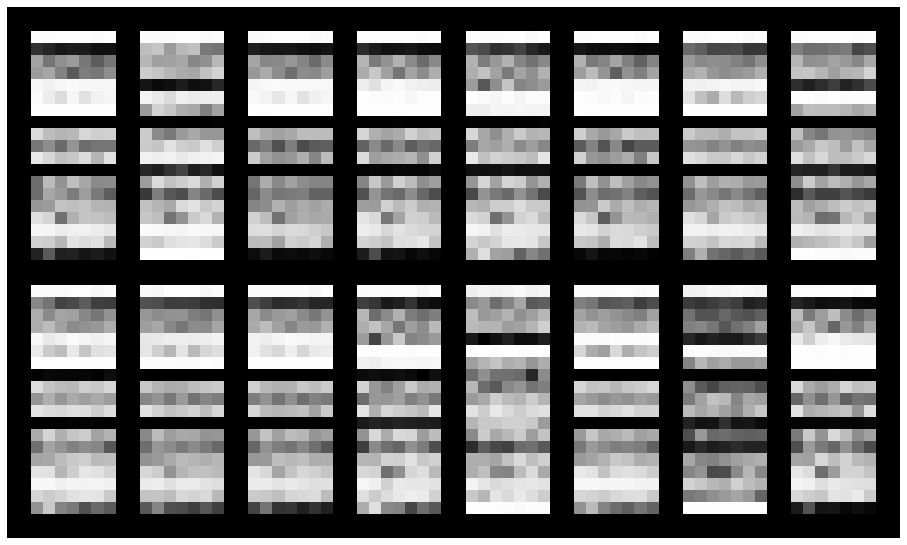

Epoch: [197/200], Batch Num: [0/54]
Discriminator Loss: 0.0171, Generator Loss: 6.2622
D(x): 0.9971, D(G(z)): 0.0044


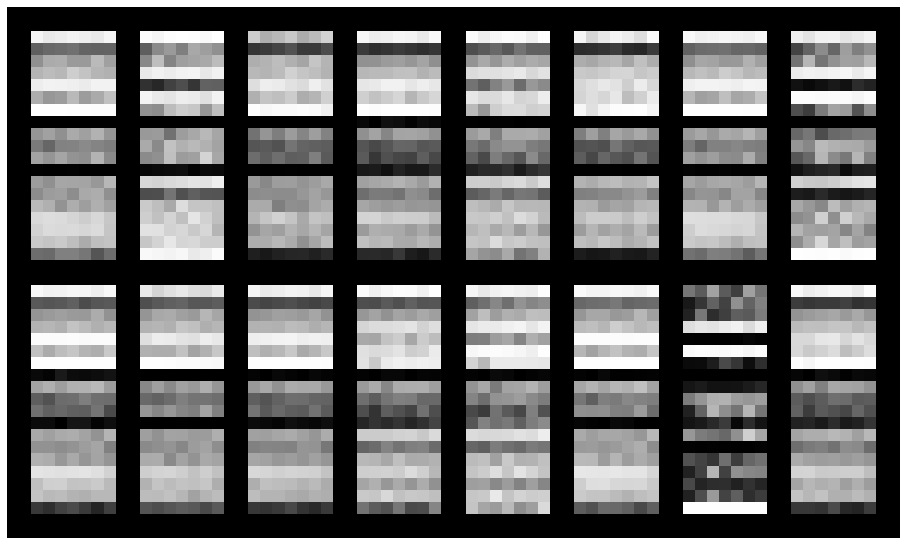

Epoch: [198/200], Batch Num: [0/54]
Discriminator Loss: 0.0057, Generator Loss: 6.0709
D(x): 0.9997, D(G(z)): 0.0050


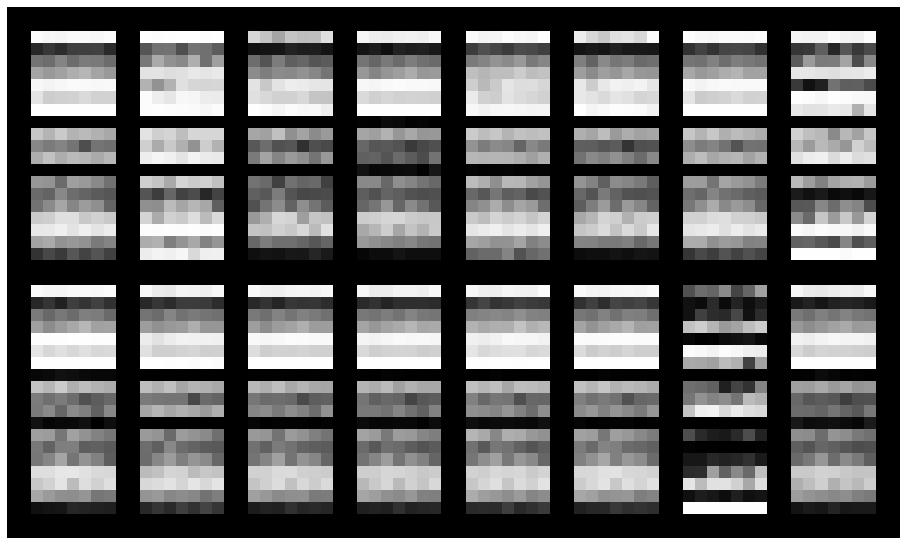

Epoch: [199/200], Batch Num: [0/54]
Discriminator Loss: 0.0111, Generator Loss: 6.3509
D(x): 1.0000, D(G(z)): 0.0080


In [18]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch) in enumerate(train_dataloader):
        N = real_batch.size(0)
        # print('real')
        # print(real_batch.dtype)
        # 1. Train Discriminator
        real_batch = real_batch - real_batch.mean(axis=0)
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        if torch.isnan(real_data).any():
            break
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches_train)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches_train
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches_train,
                d_error, g_error, d_pred_real, d_pred_fake
            )

In [ ]:
test_data = generator(noise(1))

In [ ]:
print(discriminator(test_data))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
test_data = generator(noise(10))
plt.imshow(test_data[6].reshape(19,7).detach().numpy())
plt.colorbar()

In [ ]:
for j,i in enumerate(real_data):
    if torch.isnan(i).any():
        pass
    else:
        print(j)

In [ ]:
real_data

In [ ]:
generator(noise(1))

In [ ]:
noise(1)

In [ ]:
generator(noise(1))

In [ ]:
tt1 = noise(1)
print(tt1)
t1 = generator(tt1)
print(t1)
print(t1.mean())
print(t1.std())

In [ ]:
tt2 = noise(1)
print(tt2)
t2 = generator(tt2)
print(t2)
print(t2.mean())
print(t2.std())

In [ ]:
t2-t2.mean()

In [ ]:
discriminator(real_batch[0]-real_batch[0].mean())

In [ ]:
plt.imshow((real_batch[0]-real_batch[0].mean()).reshape(11,4))
plt.colorbar()

In [ ]:
means = []
for i in range(len(real_batch)):
    means.append(real_batch[i].mean())

In [ ]:
import numpy as np

In [ ]:
means[3]

In [ ]:
discriminator(real_batch[0])

In [ ]:
real_batch[0].mean()

In [ ]:
real_batch[0].std()

In [ ]:
means = real_batch.mean(axis=1)

In [ ]:
ff = (real_batch.T-means).T

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
tmp1 = real_batch[0] - real_batch[0].mean()
print(tmp1)
print(real_batch[0].std())

In [ ]:
tmp2 = real_batch[1] - real_batch[1].mean()
print(tmp2)
print(real_batch[1].mean())
print(real_batch[1])
print(real_batch[1].std())

In [ ]:
real_batch.std(axis=1)
plt.hist(real_batch.std(axis=1),bins=100)

In [ ]:
a = generator(noise(1))
a = a.detach().numpy()
plt.imshow(a.reshape(11,4))
plt.colorbar()

In [ ]:
c = torch.tensor(a)

In [ ]:
c += b.mean()

In [ ]:
plt.imshow(c.reshape(11,4))
plt.colorbar()

In [ ]:
plt.imshow(b.reshape(11,4))
plt.colorbar()

In [ ]:
b

In [ ]:
abs(c+b.mean()-b).sum()

In [ ]:
c += b.mean()

In [ ]:
print(abs(c-b))
print(abs(c-b).sum())

In [ ]:
b = real_data[50]
print(b.mean())
print(b.std())
plt.imshow(b.reshape(11,4))
plt.colorbar()

In [ ]:
print(b.mean())
print(b.std())

In [ ]:
plt.imshow(b.reshape(11,4))
plt.colorbar()